In [1]:
#This focuses on more detailed and complex analysis than part 1
# to help, we start with some feature engineering that can allow us incorporate some marketing domain 
#knowledge into the model to improve performance

#we introduce advertising adstock principles
#1 saturation : dimininishing returns on ad spend
#2 carryover or lagged effect: sales on week T+x may be influenced by Adspend on week T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#creating an exponential saturation class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        if a > 0:
            self.a = a
        else:
            print("a entered is less than 0, using default value of 1.0")
            self.a = 1.
            
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) #from BaseEstimator
        return self
        
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) #from BaseEstimator
        return 1 - np.exp(-self.a*X)

In [3]:
#creating a carryover effect
# if we want this carryover effect to be exponential in nature and the carryover is 50%, 
# 0.5 * sales = week 2
# 0.5 * 0.5 * sales = week 3. And so on

#we then introduce 2 new hyperparameters, strength and length.
#strength = how much gets carried over
#length = how long does it get carried over for

#the above can be implemented using loops or convolutions. code below is for convolutions
from scipy.signal import convolve2d

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) #from BaseEstimator
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1,1)
        return self
    
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) #from BaseEstimator
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution


#note that the decay does not not have to be exponential and the peak advertising effect can be modelled to not
#be on the week money is first spent, perhaps on it starts on the second week.

In [4]:
#The final model

#we will use different saturations and carryovers for each channel since they have different longevity
#e.g a tv ad usually sticks longer in your head than online banners, etc

#This can be implemented using ColumnTransformer and Pipeline in sk-learn. 
#The former allows us use a different transformation for each channel, while the latter
# enables us chain operations for a single channel

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
        #TV block#
        ('tv_pipe', Pipeline([
                              ('carryover', ExponentialCarryover()),
                              ('saturation', ExponentialSaturation())
        ]), ['TV']),
        
        #radio block#
        ('radio_pipe', Pipeline([
                              ('carryover', ExponentialCarryover()),
                              ('saturation', ExponentialSaturation())
        ]), ['Radio']),
        
        #Banners block#
        ('banners_pipe', Pipeline([
                              ('carryover', ExponentialCarryover()),
                              ('saturation', ExponentialSaturation())
        ]), ['Banners']),
    ],
    remainder='passthrough'
)

model = Pipeline([
                    ('adstock', adstock),
                    ('regression', LinearRegression())
])

In [48]:
#get dataset, apply pipeline and build regression model
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

df = pd.read_csv('mmm.csv', parse_dates=['Date'], index_col='Date')

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

model.fit(X, y)

print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.552719007323667


In [9]:
#The result we got (0.55) cross validated r2 is worse than the original model, but this is only because
#we used default parameter, now we can tune our model

#Hyparameter Tuning using Optuna
#Optuna is an advance library for optimization, it is a smarter version of RandomizedSearchCV which is 
#also a better version of the brute force GridSearchCV

from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)

C:\Users\david\AppData\Local\Temp\ipykernel_38552\2883942985.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model = OptunaSearchCV(


In [11]:
#get optimized model cross eval scores
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()))

C:\Users\david\anaconda3\lib\site-packages\sklearn\base.py:88: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-11-02 00:21:53,845] A new study created in memory with name: no-name-5c2c7060-807e-4c09-8a53-291c44607088
[I 2023-11-02 00:21:53,903] Trial 0 finished with value: -347726.5739233339 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: -347726.5739233339.
[I 2023-11-02 00:

[I 2023-11-02 00:21:54,634] Trial 13 finished with value: -0.17565124091875783 and parameters: {'adstock__tv_pipe__carryover__strength': 0.974113410518705, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007515109949576203, 'adstock__radio_pipe__carryover__strength': 0.5776718446952127, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0049083254537242195, 'adstock__banners_pipe__carryover__strength': 0.9992866967535544, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.002293913888974222}. Best is trial 10 with value: 0.4509638901227861.
[I 2023-11-02 00:21:54,706] Trial 14 finished with value: -12.673728540865316 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6425960749800443, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007812832837910922, 'adstock__radio_pipe__carryover__strength': 0.3573202228222948, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:21:55,567] Trial 26 finished with value: -0.3109037447830468 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8295517028772771, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005907603737703634, 'adstock__radio_pipe__carryover__strength': 0.5258413718515487, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00746857519042207, 'adstock__banners_pipe__carryover__strength': 0.610239978443941, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 1.2668327433382486e-05}. Best is trial 21 with value: 0.45358639319651334.
[I 2023-11-02 00:21:55,643] Trial 27 finished with value: -0.5404672783704372 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7175735491580628, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006620116773384378, 'adstock__radio_pipe__carryover__strength': 0.4316448486645055, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:21:56,559] Trial 39 finished with value: -1.3606053098563113e+29 and parameters: {'adstock__tv_pipe__carryover__strength': 0.769688522173698, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00988235564888745, 'adstock__radio_pipe__carryover__strength': 0.07555075273431011, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0025932471811984112, 'adstock__banners_pipe__carryover__strength': 0.06393060054345426, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.001239704935782196}. Best is trial 35 with value: 0.5861255251318662.
[I 2023-11-02 00:21:56,634] Trial 40 finished with value: 0.5800032761279642 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8777366850732852, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007893836249085346, 'adstock__radio_pipe__carryover__strength': 0.5686896625700928, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:21:57,539] Trial 52 finished with value: 0.5654923296078964 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8883762146814003, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00688006934329075, 'adstock__radio_pipe__carryover__strength': 0.4843598533208868, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0036776080490039673, 'adstock__banners_pipe__carryover__strength': 0.14793220450651745, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0004116671070442903}. Best is trial 45 with value: 0.6047892322856366.
[I 2023-11-02 00:21:57,616] Trial 53 finished with value: 0.6041218292442643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967172538456964, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008442335455948684, 'adstock__radio_pipe__carryover__strength': 0.5961943638076623, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:21:58,524] Trial 65 finished with value: 0.5916796325197318 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8081490744694155, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007206271303503073, 'adstock__radio_pipe__carryover__strength': 0.6778681933968519, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0030887802797424685, 'adstock__banners_pipe__carryover__strength': 0.1395513110704881, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0020192707309768694}. Best is trial 56 with value: 0.6072171121480386.
[I 2023-11-02 00:21:58,600] Trial 66 finished with value: 0.03011278863471707 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7957289505212, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00704035619388734, 'adstock__radio_pipe__carryover__strength': 0.6852202202995553, 'adstock__radio_pipe__carryover__le

[I 2023-11-02 00:21:59,519] Trial 78 finished with value: -0.8882619479245287 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5542488396433586, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006079883463355841, 'adstock__radio_pipe__carryover__strength': 0.8254099804281545, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0015006160201053325, 'adstock__banners_pipe__carryover__strength': 0.20095596473304617, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0029724035501565984}. Best is trial 56 with value: 0.6072171121480386.
[I 2023-11-02 00:21:59,595] Trial 79 finished with value: 0.03396412237529978 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6717281359412653, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.006250538896342749, 'adstock__radio_pipe__carryover__strength': 0.7528847464937354, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:00,509] Trial 91 finished with value: 0.6087424289099866 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6001225543907085, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004884691367167421, 'adstock__radio_pipe__carryover__strength': 0.7006887007749177, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0017938344988762843, 'adstock__banners_pipe__carryover__strength': 0.1974592763334066, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0032430464482276875}. Best is trial 91 with value: 0.6087424289099866.
[I 2023-11-02 00:22:00,583] Trial 92 finished with value: 0.6095366417855173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5240166245005324, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004810299781639403, 'adstock__radio_pipe__carryover__strength': 0.707055766405856, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:22:01,498] Trial 104 finished with value: 0.6147425624453513 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5830592621799864, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005216347261359261, 'adstock__radio_pipe__carryover__strength': 0.7411544549609732, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0008306576605888977, 'adstock__banners_pipe__carryover__strength': 0.18811838351238747, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0031923837480209503}. Best is trial 104 with value: 0.6147425624453513.
[I 2023-11-02 00:22:01,575] Trial 105 finished with value: 0.6144219763571266 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6077340682776786, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005112679300140494, 'adstock__radio_pipe__carryover__strength': 0.7436337413562835, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:02,496] Trial 117 finished with value: 0.5921514315596581 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46937971057167405, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0053167245707783795, 'adstock__radio_pipe__carryover__strength': 0.8559401447553234, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0004042879753991933, 'adstock__banners_pipe__carryover__strength': 0.3349015716253776, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004302812021330032}. Best is trial 116 with value: 0.621676169271829.
[I 2023-11-02 00:22:02,576] Trial 118 finished with value: 0.6177926797258234 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43322649046402883, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00504038754578493, 'adstock__radio_pipe__carryover__strength': 0.7981183215989722, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:03,518] Trial 130 finished with value: 0.6207512602363513 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4546352220710675, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0055444143058476884, 'adstock__radio_pipe__carryover__strength': 0.822922856505494, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0005754607183133117, 'adstock__banners_pipe__carryover__strength': 0.34767675588902625, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005319980747415839}. Best is trial 126 with value: 0.6229175903408908.
[I 2023-11-02 00:22:03,594] Trial 131 finished with value: 0.6215963759392948 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4475238688790774, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005490488764255701, 'adstock__radio_pipe__carryover__strength': 0.8285721767860297, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:04,532] Trial 143 finished with value: 0.6198129593096636 and parameters: {'adstock__tv_pipe__carryover__strength': 0.427681304228013, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00581132439788053, 'adstock__radio_pipe__carryover__strength': 0.8631334053262206, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.000604419713496882, 'adstock__banners_pipe__carryover__strength': 0.3235695073682242, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004716782185790855}. Best is trial 126 with value: 0.6229175903408908.
[I 2023-11-02 00:22:04,626] Trial 144 finished with value: 0.6130760715727368 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3506672711403558, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005624862748963165, 'adstock__radio_pipe__carryover__strength': 0.9086449534655011, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:22:05,576] Trial 156 finished with value: 0.621390043824404 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41648800883849957, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006340697296437796, 'adstock__radio_pipe__carryover__strength': 0.9765595048161677, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00034440609783688953, 'adstock__banners_pipe__carryover__strength': 0.38031476038049816, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006003146387265232}. Best is trial 152 with value: 0.6231824784884405.
[I 2023-11-02 00:22:05,655] Trial 157 finished with value: 0.5082746757000993 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4230246217719722, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006316917719342464, 'adstock__radio_pipe__carryover__strength': 0.9929501485478024, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:06,594] Trial 169 finished with value: 0.6098347379154552 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39476859506195183, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006036247507747027, 'adstock__radio_pipe__carryover__strength': 0.9472664382997498, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0010303932859442645, 'adstock__banners_pipe__carryover__strength': 0.3260006688190372, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004746063413612843}. Best is trial 162 with value: 0.6234998424252839.
[I 2023-11-02 00:22:06,671] Trial 170 finished with value: 0.6238438424890752 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4293210214641289, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00662322544610989, 'adstock__radio_pipe__carryover__strength': 0.9129252389517771, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:22:07,612] Trial 182 finished with value: 0.623216176523973 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41405015141821017, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006537504565237712, 'adstock__radio_pipe__carryover__strength': 0.9492380507951667, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00038188580358140573, 'adstock__banners_pipe__carryover__strength': 0.2918624641447681, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005952700610823373}. Best is trial 171 with value: 0.6238477465757224.
[I 2023-11-02 00:22:07,689] Trial 183 finished with value: 0.623352832001282 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41450982072968545, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006564679676739719, 'adstock__radio_pipe__carryover__strength': 0.9536348552659182, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:08,623] Trial 195 finished with value: 0.5862845246673126 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37941438852213494, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0068005191768938, 'adstock__radio_pipe__carryover__strength': 0.8975495778608501, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00014214652066793856, 'adstock__banners_pipe__carryover__strength': 0.5033999734433418, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006744354061501483}. Best is trial 171 with value: 0.6238477465757224.
[I 2023-11-02 00:22:08,699] Trial 196 finished with value: 0.6146418257359368 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35825933425869644, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007102047794562299, 'adstock__radio_pipe__carryover__strength': 0.9178611950868935, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:09,664] Trial 208 finished with value: 0.6237458632719151 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3118116868037998, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006458159318024412, 'adstock__radio_pipe__carryover__strength': 0.8900938933881513, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0003933962776710665, 'adstock__banners_pipe__carryover__strength': 0.48611484287218587, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00660028544384154}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:09,748] Trial 209 finished with value: 0.5981672714601348 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2969153615869139, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006451607990606107, 'adstock__radio_pipe__carryover__strength': 0.8756814278172965, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:22:10,706] Trial 221 finished with value: 0.6239131089022112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3483883432003473, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006232087825463839, 'adstock__radio_pipe__carryover__strength': 0.903450663336588, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0004150783191135757, 'adstock__banners_pipe__carryover__strength': 0.4690408417057976, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007337898077787148}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:10,787] Trial 222 finished with value: 0.6227613049029948 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34109464040960724, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006228688988913334, 'adstock__radio_pipe__carryover__strength': 0.8996203940866511, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:22:11,751] Trial 234 finished with value: 0.6189587647660155 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3288163445750371, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0068765753925313445, 'adstock__radio_pipe__carryover__strength': 0.8800701909951356, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0006251915359343473, 'adstock__banners_pipe__carryover__strength': 0.44516236557862865, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007230439186873313}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:11,837] Trial 235 finished with value: 0.5855670457892269 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3386052735374123, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007122416153492767, 'adstock__radio_pipe__carryover__strength': 0.9120090698493855, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:12,818] Trial 247 finished with value: 0.6173629351814769 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3843053148827207, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0067713624338597905, 'adstock__radio_pipe__carryover__strength': 0.9056862617828918, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0006614154959923537, 'adstock__banners_pipe__carryover__strength': 0.5148635283382851, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006152266487904068}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:12,899] Trial 248 finished with value: 0.6018339743543227 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34125217007557973, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00703789570538003, 'adstock__radio_pipe__carryover__strength': 0.9434360157606292, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:13,852] Trial 260 finished with value: 0.5861624861464052 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38239959773397064, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006798404990052344, 'adstock__radio_pipe__carryover__strength': 0.4440285966495354, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00043547804909467206, 'adstock__banners_pipe__carryover__strength': 0.4985524462703035, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006169075356968626}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:13,934] Trial 261 finished with value: 0.6060863449251226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4138672803031024, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006605397778071324, 'adstock__radio_pipe__carryover__strength': 0.5432878416182506, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:14,905] Trial 273 finished with value: 0.5308320634878827 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3023235865316759, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00706953119166303, 'adstock__radio_pipe__carryover__strength': 0.9041143589285642, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 8.715904628198482e-06, 'adstock__banners_pipe__carryover__strength': 0.5049652186038496, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0068208545346255265}. Best is trial 203 with value: 0.6239223288457355.
[I 2023-11-02 00:22:14,987] Trial 274 finished with value: 0.6109976997220722 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36819049230158035, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006598936097965148, 'adstock__radio_pipe__carryover__strength': 0.9352107273874087, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:15,977] Trial 286 finished with value: 0.5842291909138424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33676841604719837, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006181039754331488, 'adstock__radio_pipe__carryover__strength': 0.3733694629725924, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.000572478561933574, 'adstock__banners_pipe__carryover__strength': 0.4737761337699117, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005823534474079441}. Best is trial 282 with value: 0.6425907779463796.
[I 2023-11-02 00:22:16,059] Trial 287 finished with value: 0.0610154746963949 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37073051191573514, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.006582970408315264, 'adstock__radio_pipe__carryover__strength': 0.1145931764255267, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:17,042] Trial 299 finished with value: 0.6555575974607772 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25758285092183075, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0078035195213839725, 'adstock__radio_pipe__carryover__strength': 0.15086788733170736, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00014890042837243858, 'adstock__banners_pipe__carryover__strength': 0.3915202768483217, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006637921447590055}. Best is trial 290 with value: 0.6589350621323067.
[I 2023-11-02 00:22:17,126] Trial 300 finished with value: 0.6547473896868452 and parameters: {'adstock__tv_pipe__carryover__strength': 0.259652442420448, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008176044187336072, 'adstock__radio_pipe__carryover__strength': 0.14741639784661117, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:18,204] Trial 312 finished with value: 0.6543749965628449 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2375513347463326, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008319167065369963, 'adstock__radio_pipe__carryover__strength': 0.13947713162550235, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 2.0287093427633703e-05, 'adstock__banners_pipe__carryover__strength': 0.39208138036214923, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006608845282553902}. Best is trial 290 with value: 0.6589350621323067.
[I 2023-11-02 00:22:18,290] Trial 313 finished with value: 0.653547695675409 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23423537889265084, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008378822712188908, 'adstock__radio_pipe__carryover__strength': 0.14794426012568881, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:19,307] Trial 325 finished with value: 0.6567559755475362 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2765761986645258, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008581329673746276, 'adstock__radio_pipe__carryover__strength': 0.13402741304033655, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00016272185916490331, 'adstock__banners_pipe__carryover__strength': 0.3723328630623248, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0064999227309919735}. Best is trial 290 with value: 0.6589350621323067.
[I 2023-11-02 00:22:19,399] Trial 326 finished with value: 0.6569601470237547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27187610685145824, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008571675898983186, 'adstock__radio_pipe__carryover__strength': 0.13143512617180358, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:20,449] Trial 338 finished with value: 0.5816578071682419 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18593792737222595, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007805231263224542, 'adstock__radio_pipe__carryover__strength': 0.07721486764467178, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0057646685134029145, 'adstock__banners_pipe__carryover__strength': 0.41558171901292557, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006375546495552157}. Best is trial 331 with value: 0.6601600468166687.
[I 2023-11-02 00:22:20,534] Trial 339 finished with value: 0.6598759708634698 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18900599540302968, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008852836884083434, 'adstock__radio_pipe__carryover__strength': 0.08216781315898496, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:21,566] Trial 351 finished with value: 0.5877849063557882 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1503559463619008, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008833734136036445, 'adstock__radio_pipe__carryover__strength': 0.07830050097129788, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0037205520417739075, 'adstock__banners_pipe__carryover__strength': 0.36115810785510544, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009677008959535154}. Best is trial 347 with value: 0.6613776140237837.
[I 2023-11-02 00:22:21,655] Trial 352 finished with value: 0.5941409226708597 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19853587832397468, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009265086683130532, 'adstock__radio_pipe__carryover__strength': 0.08959175300238828, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:22,692] Trial 364 finished with value: 0.6618121113194804 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1639168972877309, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008999798175549358, 'adstock__radio_pipe__carryover__strength': 0.02679758715899878, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.00028968101451184596, 'adstock__banners_pipe__carryover__strength': 0.3516373871965786, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0089415808765525}. Best is trial 364 with value: 0.6618121113194804.
[I 2023-11-02 00:22:22,788] Trial 365 finished with value: 0.592780616840168 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16514729676680334, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00897839911987148, 'adstock__radio_pipe__carryover__strength': 0.030543386729455738, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:23,852] Trial 377 finished with value: 0.5865989884772227 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12134423571599103, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009600608263501217, 'adstock__radio_pipe__carryover__strength': 0.04526051174768966, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.00672911344801129, 'adstock__banners_pipe__carryover__strength': 0.3412240723389967, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008973320767814126}. Best is trial 364 with value: 0.6618121113194804.
[I 2023-11-02 00:22:23,942] Trial 378 finished with value: 0.6567267148681184 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17582537221347289, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009115885460809058, 'adstock__radio_pipe__carryover__strength': 0.01984505533029934, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:24,989] Trial 390 finished with value: 0.643932743429433 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15896730814631915, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0089949435109731, 'adstock__radio_pipe__carryover__strength': 0.014920144542014863, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.005619796516601027, 'adstock__banners_pipe__carryover__strength': 0.3078417662865962, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00925778662931896}. Best is trial 364 with value: 0.6618121113194804.
[I 2023-11-02 00:22:25,078] Trial 391 finished with value: 0.5894548086042982 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14282623065263456, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008899332523942323, 'adstock__radio_pipe__carryover__strength': 0.06961719534881472, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:22:26,150] Trial 403 finished with value: 0.6576601242340039 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18534192790048834, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00943705234594273, 'adstock__radio_pipe__carryover__strength': 0.043329800300165214, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0007966869706860075, 'adstock__banners_pipe__carryover__strength': 0.3162758531448287, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00896378784888737}. Best is trial 364 with value: 0.6618121113194804.
[I 2023-11-02 00:22:26,240] Trial 404 finished with value: 0.06787751998665843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12642255094081725, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.009077845644850613, 'adstock__radio_pipe__carryover__strength': 0.024551513968822363, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:27,299] Trial 416 finished with value: 0.6460901981720748 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07800390759106103, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009371502281238174, 'adstock__radio_pipe__carryover__strength': 0.02286840726344737, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.003258754516310778, 'adstock__banners_pipe__carryover__strength': 0.3721020391572724, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008446763825333391}. Best is trial 415 with value: 0.6624329869178505.
[I 2023-11-02 00:22:27,391] Trial 417 finished with value: 0.2778856624045069 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07199749798357638, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00971729755360879, 'adstock__radio_pipe__carryover__strength': 0.01748873343450594, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:28,457] Trial 429 finished with value: 0.6590055827132408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03364108548881777, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009829671569739538, 'adstock__radio_pipe__carryover__strength': 0.003723925448109601, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.001031780923325822, 'adstock__banners_pipe__carryover__strength': 0.33357480482652446, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008900757430123446}. Best is trial 415 with value: 0.6624329869178505.
[I 2023-11-02 00:22:28,549] Trial 430 finished with value: 0.6619954047100111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.05253626729853098, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009198708033059291, 'adstock__radio_pipe__carryover__strength': 0.02109740379574296, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:29,639] Trial 442 finished with value: 0.5922267606928899 and parameters: {'adstock__tv_pipe__carryover__strength': 0.007781975932748653, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009191703551796361, 'adstock__radio_pipe__carryover__strength': 0.055130009608748885, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.00481235408367707, 'adstock__banners_pipe__carryover__strength': 0.26536295510793206, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008116538652899368}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:29,724] Trial 443 finished with value: 0.0007835340435576654 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09770629800884059, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.008945204888181941, 'adstock__radio_pipe__carryover__strength': 0.018094924673050513, 'adstock__radio_pipe_

[I 2023-11-02 00:22:30,801] Trial 455 finished with value: 0.16217284259321174 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09359303125091385, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008737374193563343, 'adstock__radio_pipe__carryover__strength': 0.020044460114346085, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0013273526705845644, 'adstock__banners_pipe__carryover__strength': 0.9187627782128635, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009720621587756648}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:30,894] Trial 456 finished with value: 0.6614750398392921 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1086623569623355, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008947035656611558, 'adstock__radio_pipe__carryover__strength': 0.05255640143148609, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:31,993] Trial 468 finished with value: 0.5821824550683693 and parameters: {'adstock__tv_pipe__carryover__strength': 0.062011261305210924, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008969057105239504, 'adstock__radio_pipe__carryover__strength': 0.09661270601082643, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004130000762267716, 'adstock__banners_pipe__carryover__strength': 0.98237269613153, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008838198104395343}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:32,078] Trial 469 finished with value: 0.3427017486794482 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12438182647238899, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00922142669990895, 'adstock__radio_pipe__carryover__strength': 0.03932093576444218, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:33,188] Trial 481 finished with value: 0.6430939207155926 and parameters: {'adstock__tv_pipe__carryover__strength': 0.057318206791816824, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008799471108601156, 'adstock__radio_pipe__carryover__strength': 0.029467026521340887, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.002864423217664688, 'adstock__banners_pipe__carryover__strength': 0.9827845684677167, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009689825709711733}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:33,279] Trial 482 finished with value: 0.6616633339786789 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13441050190476295, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009254964023694388, 'adstock__radio_pipe__carryover__strength': 3.2437094573286446e-05, 'adstock__radio_pipe__

[I 2023-11-02 00:22:34,408] Trial 494 finished with value: 0.6371793909427546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06812265129364627, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009714550383677977, 'adstock__radio_pipe__carryover__strength': 0.02030908245974812, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.002872989943507918, 'adstock__banners_pipe__carryover__strength': 0.9301641487234463, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001197313696585859}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:34,501] Trial 495 finished with value: 0.34285453214276185 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7602577930986824, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00215907521828436, 'adstock__radio_pipe__carryover__strength': 0.00043280187246179684, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:35,620] Trial 507 finished with value: 0.5853888189330894 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08835473966512063, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00911848627510125, 'adstock__radio_pipe__carryover__strength': 0.032886646330779055, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.009540545126682199, 'adstock__banners_pipe__carryover__strength': 0.5339638338776023, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009455328582249532}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:35,710] Trial 508 finished with value: 0.6620861114231068 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4899412104797015, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00858933411329549, 'adstock__radio_pipe__carryover__strength': 0.018188287545385807, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:36,846] Trial 520 finished with value: 0.5960930317610492 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5448744438546744, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002926569691851828, 'adstock__radio_pipe__carryover__strength': 0.27529539314721635, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0034377878213235303, 'adstock__banners_pipe__carryover__strength': 0.6396708018275564, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008285005456341418}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:36,940] Trial 521 finished with value: 0.6554700544308918 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12124370247749738, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008879540110204628, 'adstock__radio_pipe__carryover__strength': 0.0006383202803820417, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:38,070] Trial 533 finished with value: 0.6450116946688756 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6102756856990875, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0036666869920539036, 'adstock__radio_pipe__carryover__strength': 0.03164783120451902, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0024433276115603908, 'adstock__banners_pipe__carryover__strength': 0.9376444291359431, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008637406744741498}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:38,164] Trial 534 finished with value: 0.6614591566880369 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4888279053146979, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001915028527020174, 'adstock__radio_pipe__carryover__strength': 0.053554758815046524, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:39,288] Trial 546 finished with value: 0.6061623553027837 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8398420675664573, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0024615452581967547, 'adstock__radio_pipe__carryover__strength': 0.2253198629155394, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0006654247367367421, 'adstock__banners_pipe__carryover__strength': 0.8137228467531582, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008764815854631484}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:39,379] Trial 547 finished with value: 0.6396635006860685 and parameters: {'adstock__tv_pipe__carryover__strength': 0.987638103555815, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002535633177921653, 'adstock__radio_pipe__carryover__strength': 0.020815469506863, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:22:40,494] Trial 559 finished with value: 0.6281424274407978 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5097006377434209, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009533949864604676, 'adstock__radio_pipe__carryover__strength': 0.07012372497994891, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0017810223525134786, 'adstock__banners_pipe__carryover__strength': 0.9157955390122267, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00865322053201243}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:40,589] Trial 560 finished with value: 0.03610645766040308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7345051336594011, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0018938544458895078, 'adstock__radio_pipe__carryover__strength': 0.016720725803814937, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:41,783] Trial 572 finished with value: 0.6193204031780084 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6452627446567202, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003176408336817033, 'adstock__radio_pipe__carryover__strength': 0.29869243307757626, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0002836245678045343, 'adstock__banners_pipe__carryover__strength': 0.31980794685291075, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004358953205995265}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:41,883] Trial 573 finished with value: 0.6610234846754136 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46154645748344303, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009291155898348058, 'adstock__radio_pipe__carryover__strength': 0.032388941292062864, 'adstock__radio_pipe__car

[I 2023-11-02 00:22:43,061] Trial 585 finished with value: 0.0020137533461093817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7532537803969704, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003067555576713849, 'adstock__radio_pipe__carryover__strength': 0.020276528642933608, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.005942354150399273, 'adstock__banners_pipe__carryover__strength': 0.5657272111719832, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.00887654123352292}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:43,161] Trial 586 finished with value: 0.6224272359300568 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8767844425410931, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0016404469599483713, 'adstock__radio_pipe__carryover__strength': 0.2898021360654586, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:44,320] Trial 598 finished with value: 0.6395868802628826 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6280075041292773, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0029458888232329365, 'adstock__radio_pipe__carryover__strength': 0.01424054543593384, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0069587064527913385, 'adstock__banners_pipe__carryover__strength': 0.26587777314962524, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00940118269162974}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:44,419] Trial 599 finished with value: 0.5896589125101842 and parameters: {'adstock__tv_pipe__carryover__strength': 0.718500957981667, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004609057370841666, 'adstock__radio_pipe__carryover__strength': 0.4197784758944009, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:22:45,582] Trial 611 finished with value: 0.6127661886046849 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9586223097159297, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009583750165887243, 'adstock__radio_pipe__carryover__strength': 0.04706181541642039, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0020881795766790833, 'adstock__banners_pipe__carryover__strength': 0.6265051994192188, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0008554068805483993}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:45,679] Trial 612 finished with value: 0.5934322023860219 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0006468994247413734, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002167801467428866, 'adstock__radio_pipe__carryover__strength': 0.36013003727735415, 'adstock__radio_pipe__ca

[I 2023-11-02 00:22:46,827] Trial 624 finished with value: 0.6247734607771613 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6931383563252741, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005672625449177936, 'adstock__radio_pipe__carryover__strength': 0.07022447951692237, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0017791026954975754, 'adstock__banners_pipe__carryover__strength': 0.33321205800924564, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002147716563148565}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:46,920] Trial 625 finished with value: 0.5959987494224714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5810502636239805, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009496650210403489, 'adstock__radio_pipe__carryover__strength': 0.26034148725098016, 'adstock__radio_pipe__carry

[I 2023-11-02 00:22:48,075] Trial 637 finished with value: 0.46635401100149354 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7053339600641142, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.002084161466321209, 'adstock__radio_pipe__carryover__strength': 0.4661894357873923, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0008293477344846847, 'adstock__banners_pipe__carryover__strength': 0.6229847373126562, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 3.655048152320997e-05}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:48,172] Trial 638 finished with value: -0.36635438333847503 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8783226027603324, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.009464877283759061, 'adstock__radio_pipe__carryover__strength': 0.7176154306720021, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:49,341] Trial 650 finished with value: 0.660908248525067 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46862226501487514, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003600480459949842, 'adstock__radio_pipe__carryover__strength': 0.020056988765200498, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0007060439639326371, 'adstock__banners_pipe__carryover__strength': 0.07146394737515852, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00429318807529991}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:49,443] Trial 651 finished with value: 0.6338804998996398 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4861091653754988, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00272300222112194, 'adstock__radio_pipe__carryover__strength': 0.03171599056410582, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:50,652] Trial 663 finished with value: 0.6559343199987075 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08746536787802084, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0050475990193253354, 'adstock__radio_pipe__carryover__strength': 0.00018354845446199794, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0037301856259207597, 'adstock__banners_pipe__carryover__strength': 0.08932989913595124, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004138853551768383}. Best is trial 438 with value: 0.6875965284318073.
[I 2023-11-02 00:22:50,754] Trial 664 finished with value: 0.3736834612879064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1062118897994013, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004098607700054833, 'adstock__radio_pipe__carryover__strength': 0.05267006533510557, 'adstock__radio_pipe__

[I 2023-11-02 00:22:51,958] Trial 676 finished with value: 0.4082617768155844 and parameters: {'adstock__tv_pipe__carryover__strength': 0.013989206047584635, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005352755630832628, 'adstock__radio_pipe__carryover__strength': 0.4048802432989208, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00044939487657725044, 'adstock__banners_pipe__carryover__strength': 0.2523701035110154, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007765263914520119}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:52,054] Trial 677 finished with value: 0.5435649779101459 and parameters: {'adstock__tv_pipe__carryover__strength': 0.022217969903001317, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0051482471633841655, 'adstock__radio_pipe__carryover__strength': 0.06793447038642644, 'adstock__radio_pipe__c

[I 2023-11-02 00:22:53,260] Trial 689 finished with value: 0.1491435499946612 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02742756509687181, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004246910940292829, 'adstock__radio_pipe__carryover__strength': 0.4335604925999969, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.003294697239841004, 'adstock__banners_pipe__carryover__strength': 0.06686101693971522, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0047262914525368505}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:53,373] Trial 690 finished with value: -0.19935212528872187 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08819375512015659, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005600990852819734, 'adstock__radio_pipe__carryover__strength': 0.19509134382554172, 'adstock__radio_pipe__ca

[I 2023-11-02 00:22:54,554] Trial 702 finished with value: 0.636415022390696 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5462689327706296, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0005297390768912065, 'adstock__radio_pipe__carryover__strength': 0.0233579209214893, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004549801089869893, 'adstock__banners_pipe__carryover__strength': 0.30603353670971184, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008698737246143642}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:54,653] Trial 703 finished with value: 0.6073202033235752 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8491565302284177, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0030901406195551974, 'adstock__radio_pipe__carryover__strength': 0.06553246635829356, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:55,866] Trial 715 finished with value: 0.6576280429503294 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21509857794238904, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005773153253982721, 'adstock__radio_pipe__carryover__strength': 0.1203001691598791, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0001925738554795496, 'adstock__banners_pipe__carryover__strength': 0.7611424710885278, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008292633418280553}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:55,959] Trial 716 finished with value: 0.6504422846174241 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07774416279088145, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008114468131019488, 'adstock__radio_pipe__carryover__strength': 0.018653874749530952, 'adstock__radio_pipe__carr

[I 2023-11-02 00:22:57,120] Trial 728 finished with value: 0.5764171625950946 and parameters: {'adstock__tv_pipe__carryover__strength': 0.018217623534558396, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0016082211526694359, 'adstock__radio_pipe__carryover__strength': 0.5694129621697264, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 1.123298739174358e-07, 'adstock__banners_pipe__carryover__strength': 0.7126323072468028, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00948792235282412}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:57,220] Trial 729 finished with value: 0.5855673634851648 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7893002868939198, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004172721615631268, 'adstock__radio_pipe__carryover__strength': 0.7577540098019193, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:22:58,412] Trial 741 finished with value: 0.625885158897679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3137242454351864, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0074172334388566095, 'adstock__radio_pipe__carryover__strength': 0.018359974347430086, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0077553406251950575, 'adstock__banners_pipe__carryover__strength': 0.2107971552563223, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007915934565594484}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:58,514] Trial 742 finished with value: -1113.2048046047548 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4371044940675095, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007305303931704075, 'adstock__radio_pipe__carryover__strength': 0.5409286561339004, 'adstock__radio_pipe__carry

[I 2023-11-02 00:22:59,704] Trial 754 finished with value: -0.20746279337084522 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5064798894388213, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008500822643610448, 'adstock__radio_pipe__carryover__strength': 0.0357619535175761, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0010264518935752392, 'adstock__banners_pipe__carryover__strength': 0.5145095044645532, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.007272830394843865}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:22:59,804] Trial 755 finished with value: 0.6563547286066511 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7834847159791517, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007800257053303818, 'adstock__radio_pipe__carryover__strength': 0.08167118105463296, 'adstock__radio_pipe__carry

[I 2023-11-02 00:23:01,045] Trial 767 finished with value: 0.08747314022727559 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6954119811001283, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004997866227437768, 'adstock__radio_pipe__carryover__strength': 0.4608150742131148, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0068423294686757695, 'adstock__banners_pipe__carryover__strength': 0.07148593682581832, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00890878456040152}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:01,145] Trial 768 finished with value: -0.22574811325482996 and parameters: {'adstock__tv_pipe__carryover__strength': 0.814262394702306, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006035750442876916, 'adstock__radio_pipe__carryover__strength': 0.23611542139188924, 'adstock__radio_pipe__carry

[I 2023-11-02 00:23:02,380] Trial 780 finished with value: 0.6375014780685877 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7224020659349707, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0076566640495417445, 'adstock__radio_pipe__carryover__strength': 0.07171905535228862, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013484406492109322, 'adstock__banners_pipe__carryover__strength': 0.8158241913236116, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033639545516253415}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:02,482] Trial 781 finished with value: 0.6617137005811361 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27836484170952547, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004654765581906334, 'adstock__radio_pipe__carryover__strength': 0.0007859159479388709, 'adstock__radio_pipe__c

[I 2023-11-02 00:23:03,705] Trial 793 finished with value: -60.20008067323708 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5778252727225676, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003978999609493385, 'adstock__radio_pipe__carryover__strength': 0.2879111618541838, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.002391685724847845, 'adstock__banners_pipe__carryover__strength': 0.5295572109544998, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008741223697755537}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:03,809] Trial 794 finished with value: 0.6589312976796794 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5927914906103322, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008324414774271153, 'adstock__radio_pipe__carryover__strength': 0.03698673656571573, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:23:05,031] Trial 806 finished with value: -8809.602666639064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2552133088897558, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0055586291764006, 'adstock__radio_pipe__carryover__strength': 0.6955308571402872, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0013474256351570443, 'adstock__banners_pipe__carryover__strength': 0.775620002203621, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.003468664936634749}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:05,130] Trial 807 finished with value: 0.6575150359274129 and parameters: {'adstock__tv_pipe__carryover__strength': 0.744706358170701, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0062610355997754, 'adstock__radio_pipe__carryover__strength': 0.03627029387429538, 'adstock__radio_pipe__carryover__le

[I 2023-11-02 00:23:06,364] Trial 819 finished with value: -9938.064021249971 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5647565483058149, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004407966226567229, 'adstock__radio_pipe__carryover__strength': 0.0204468165340532, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0004123015118307014, 'adstock__banners_pipe__carryover__strength': 0.5210918784830528, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0007892824783538267}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:06,471] Trial 820 finished with value: 0.5809692700828628 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8882321317422973, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004969791314421502, 'adstock__radio_pipe__carryover__strength': 0.06062432906343191, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:07,686] Trial 832 finished with value: 0.2043100187250849 and parameters: {'adstock__tv_pipe__carryover__strength': 0.285628741174503, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.005243332857445212, 'adstock__radio_pipe__carryover__strength': 0.03379407067500252, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 7.644207527377183e-06, 'adstock__banners_pipe__carryover__strength': 0.6147665470538903, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0032785489917554365}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:07,786] Trial 833 finished with value: 0.5855596631568908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8535033053757528, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0076346928438809965, 'adstock__radio_pipe__carryover__strength': 0.7797845297439463, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:09,008] Trial 845 finished with value: 0.09465806151654017 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5070427608384278, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.004839705176638668, 'adstock__radio_pipe__carryover__strength': 0.021439800167701733, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004407124596375898, 'adstock__banners_pipe__carryover__strength': 0.7419576845364255, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004358340725684364}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:09,107] Trial 846 finished with value: -1150410814.9519424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7311005223642169, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.003024318003672874, 'adstock__radio_pipe__carryover__strength': 0.704934124620203, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:10,358] Trial 858 finished with value: 0.6079717082063081 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2465827570986923, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0051547243510922745, 'adstock__radio_pipe__carryover__strength': 0.04708284977986853, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004163015347250051, 'adstock__banners_pipe__carryover__strength': 0.3365667774309351, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00809896827300957}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:10,460] Trial 859 finished with value: 0.2565875650636715 and parameters: {'adstock__tv_pipe__carryover__strength': 0.695254823492115, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.005239899637925804, 'adstock__radio_pipe__carryover__strength': 0.018091660482866735, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:23:11,719] Trial 871 finished with value: 0.23887906101010653 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6687042143386309, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0002363845517359144, 'adstock__radio_pipe__carryover__strength': 0.058161030785038925, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.008299697396388556, 'adstock__banners_pipe__carryover__strength': 0.7700289926312165, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009758491697339944}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:11,818] Trial 872 finished with value: 0.6618932608408175 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7144455557672241, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005724680979378873, 'adstock__radio_pipe__carryover__strength': 0.04276360090311812, 'adstock__radio_pipe__carr

[I 2023-11-02 00:23:13,074] Trial 884 finished with value: -0.21767255752090708 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7130787176088463, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005428993493982583, 'adstock__radio_pipe__carryover__strength': 0.06358491714234704, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0001639150453367125, 'adstock__banners_pipe__carryover__strength': 0.7325457992012139, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.009462553254285742}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:13,175] Trial 885 finished with value: -0.024847817974141418 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6355607498835408, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005932006780051236, 'adstock__radio_pipe__carryover__strength': 0.3125252275292471, 'adstock__radio_pipe__ca

[I 2023-11-02 00:23:14,493] Trial 897 finished with value: -8.539063658721929 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1973953267974703, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008505221298303752, 'adstock__radio_pipe__carryover__strength': 0.4516797541653125, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0073664157909563675, 'adstock__banners_pipe__carryover__strength': 0.17593799650488945, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.005212108847027336}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:14,599] Trial 898 finished with value: 0.6615366573664374 and parameters: {'adstock__tv_pipe__carryover__strength': 0.018084663677372652, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.005769610370317257, 'adstock__radio_pipe__carryover__strength': 0.05167165899637764, 'adstock__radio_pipe__carr

[I 2023-11-02 00:23:15,954] Trial 910 finished with value: 0.6837768887946385 and parameters: {'adstock__tv_pipe__carryover__strength': 0.005237725086875508, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008057131558399292, 'adstock__radio_pipe__carryover__strength': 0.01683408324985013, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0020695520375784097, 'adstock__banners_pipe__carryover__strength': 0.8552248742526373, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008113692847690632}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:16,082] Trial 911 finished with value: 0.6936035355936498 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0024948943977218556, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007903655460260757, 'adstock__radio_pipe__carryover__strength': 0.00039994591584067806, 'adstock__radio_pipe

[I 2023-11-02 00:23:17,593] Trial 923 finished with value: 0.45544267960939433 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020716769311544096, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008093420064357421, 'adstock__radio_pipe__carryover__strength': 0.014540077451973573, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0017520451514873368, 'adstock__banners_pipe__carryover__strength': 0.8372858215414702, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007901504379560578}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:17,703] Trial 924 finished with value: 0.5249818274388526 and parameters: {'adstock__tv_pipe__carryover__strength': 0.015437140162101431, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0080171872529433, 'adstock__radio_pipe__carryover__strength': 0.0021674189550582625, 'adstock__radio_pipe__

[I 2023-11-02 00:23:19,125] Trial 936 finished with value: 0.3987366105341864 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02915782037980877, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008259651734317936, 'adstock__radio_pipe__carryover__strength': 0.0002937785880525296, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0018527698861966488, 'adstock__banners_pipe__carryover__strength': 0.8409692953970798, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007734451653461386}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:19,250] Trial 937 finished with value: 0.4034183578733218 and parameters: {'adstock__tv_pipe__carryover__strength': 0.029482877143239175, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007901106521094582, 'adstock__radio_pipe__carryover__strength': 0.0026145329014347616, 'adstock__radio_pipe_

[I 2023-11-02 00:23:20,620] Trial 949 finished with value: 0.6664002278132546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0004391648594904775, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007978927864754206, 'adstock__radio_pipe__carryover__strength': 0.00029298788123900183, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.001716182465524144, 'adstock__banners_pipe__carryover__strength': 0.8327570830884234, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007989400685209142}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:20,739] Trial 950 finished with value: 0.5834319481610366 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0002210677872426063, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007950092014207969, 'adstock__radio_pipe__carryover__strength': 0.48162119742069553, 'adstock__radio_pipe

[I 2023-11-02 00:23:22,116] Trial 962 finished with value: 0.576812209690329 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0008764468127489796, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008407513613178168, 'adstock__radio_pipe__carryover__strength': 0.6616892394049754, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0018764184485209662, 'adstock__banners_pipe__carryover__strength': 0.8730741154935111, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007435893772867688}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:22,231] Trial 963 finished with value: 0.040542227695478286 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03832135698155039, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007699768755447536, 'adstock__radio_pipe__carryover__strength': 0.3459096272352892, 'adstock__radio_pipe__car

[I 2023-11-02 00:23:23,651] Trial 975 finished with value: 0.4798784378833182 and parameters: {'adstock__tv_pipe__carryover__strength': 0.01855204188682694, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007850591604758367, 'adstock__radio_pipe__carryover__strength': 0.030646261854709818, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0013634473839273064, 'adstock__banners_pipe__carryover__strength': 0.8458218846205589, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0076806026487604585}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:23,774] Trial 976 finished with value: -0.144666695428677 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0020456704115208273, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.008410955831243455, 'adstock__radio_pipe__carryover__strength': 0.02332635658322065, 'adstock__radio_pipe__

[I 2023-11-02 00:23:25,225] Trial 988 finished with value: 0.24851006332988534 and parameters: {'adstock__tv_pipe__carryover__strength': 0.020163159949682992, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00756045469491459, 'adstock__radio_pipe__carryover__strength': 0.7532506499211586, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0020115830272814136, 'adstock__banners_pipe__carryover__strength': 0.8336980392529755, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00740471553755953}. Best is trial 674 with value: 0.7080066728326544.
[I 2023-11-02 00:23:25,342] Trial 989 finished with value: 0.6579678633402863 and parameters: {'adstock__tv_pipe__carryover__strength': 0.00016026641706263015, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.007838629305241103, 'adstock__radio_pipe__carryover__strength': 0.0211934058853629, 'adstock__radio_pipe__car

[I 2023-11-02 00:23:26,628] Trial 1 finished with value: -1.980324845834968e+23 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00517502161880338, 'adstock__radio_pipe__carryover__strength': 0.04182737713424278, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0014206610097397077, 'adstock__banners_pipe__carryover__strength': 0.07832671372998268, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.006592437999535571}. Best is trial 0 with value: -37696.0712136925.
[I 2023-11-02 00:23:26,684] Trial 2 finished with value: -0.3586207269962094 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35725476168521175, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.001651149068523966, 'adstock__radio_pipe__carryover__strength': 0.9192135617465139, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:23:27,438] Trial 14 finished with value: 0.4015457909343928 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6425960749800443, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00819196019829333, 'adstock__radio_pipe__carryover__strength': 0.5660489625448003, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005064968399278445, 'adstock__banners_pipe__carryover__strength': 0.6932220498739254, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.00320703899067638}. Best is trial 4 with value: 0.43455406002953667.
[I 2023-11-02 00:23:27,517] Trial 15 finished with value: 0.429160694933853 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5595125358026946, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005256409315161805, 'adstock__radio_pipe__carryover__strength': 0.11494127419191352, 'adstock__radio_pipe__carryover__len

[I 2023-11-02 00:23:28,382] Trial 27 finished with value: 0.044516887495702415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5269756158313813, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008872298759269542, 'adstock__radio_pipe__carryover__strength': 0.08082735834040815, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.005048634758764642, 'adstock__banners_pipe__carryover__strength': 0.34531020427382314, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.004675009963056882}. Best is trial 19 with value: 0.518426712052864.
[I 2023-11-02 00:23:28,456] Trial 28 finished with value: 0.4552215899036295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7224241622990455, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.008012747839780817, 'adstock__radio_pipe__carryover__strength': 0.17088716913290802, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:23:29,300] Trial 40 finished with value: 0.6200872307829053 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7909534797569513, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005469026854903241, 'adstock__radio_pipe__carryover__strength': 0.06946153834810137, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006805063114807363, 'adstock__banners_pipe__carryover__strength': 0.02017003827044883, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.00705755260775005}. Best is trial 40 with value: 0.6200872307829053.
[I 2023-11-02 00:23:29,375] Trial 41 finished with value: 0.6207005560324065 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7743036185509578, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005557644362428749, 'adstock__radio_pipe__carryover__strength': 0.07566894714455134, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:23:30,233] Trial 53 finished with value: -9.87662167725169e+22 and parameters: {'adstock__tv_pipe__carryover__strength': 0.893685877344007, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004345183884940144, 'adstock__radio_pipe__carryover__strength': 0.27577243397045703, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007570440051558897, 'adstock__banners_pipe__carryover__strength': 0.1252047153793105, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.006918910119737984}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:30,306] Trial 54 finished with value: 0.504034689490543 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9562862208175068, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005498405589755369, 'adstock__radio_pipe__carryover__strength': 0.16374564363135338, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:23:31,203] Trial 66 finished with value: 0.4817080744023218 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8113249407043982, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0033710242360924254, 'adstock__radio_pipe__carryover__strength': 0.37856414954429385, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0066758117773188415, 'adstock__banners_pipe__carryover__strength': 0.0803769214829019, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.006728336842470945}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:31,287] Trial 67 finished with value: 0.38871514553055153 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8745946383653747, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003225002885531425, 'adstock__radio_pipe__carryover__strength': 0.09107757363150903, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:23:32,174] Trial 79 finished with value: 0.612836774700974 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7709705933798843, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.006172914095356887, 'adstock__radio_pipe__carryover__strength': 0.3565063078696902, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007509231929485986, 'adstock__banners_pipe__carryover__strength': 0.026528937025622264, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.00953076569548077}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:32,247] Trial 80 finished with value: 0.33707039724073395 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8093813346296348, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005604149000169389, 'adstock__radio_pipe__carryover__strength': 0.2237370445230955, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:23:33,126] Trial 92 finished with value: 0.616291576453252 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8468634707782862, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005628513182127853, 'adstock__radio_pipe__carryover__strength': 0.3517206824775509, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006762807473105229, 'adstock__banners_pipe__carryover__strength': 0.027857723140695033, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.00743196288333654}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:33,199] Trial 93 finished with value: -3.7613520521677056e+23 and parameters: {'adstock__tv_pipe__carryover__strength': 0.842325061917767, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.005673065022125274, 'adstock__radio_pipe__carryover__strength': 0.4114575497133231, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:23:34,095] Trial 105 finished with value: 0.5754103346682993 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8290291551504025, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00475393737645999, 'adstock__radio_pipe__carryover__strength': 0.3225763701573381, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00787949726682042, 'adstock__banners_pipe__carryover__strength': 0.0891769541226516, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.007231435560786029}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:34,172] Trial 106 finished with value: 0.6147595158230589 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8800379972626389, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.005099748938528427, 'adstock__radio_pipe__carryover__strength': 0.07413249555491047, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:23:35,066] Trial 118 finished with value: 0.5542021027420088 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9713702796801098, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00463409433466604, 'adstock__radio_pipe__carryover__strength': 0.06154174052864163, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0070049020419419026, 'adstock__banners_pipe__carryover__strength': 0.0005062661527597996, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0055399839377700336}. Best is trial 43 with value: 0.6228287730706729.
[I 2023-11-02 00:23:35,141] Trial 119 finished with value: -3.976934105738729e+16 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7247500606951306, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005370539975202502, 'adstock__radio_pipe__carryover__strength': 0.18540772930733523, 'adstock__radio_pipe__

[I 2023-11-02 00:23:36,055] Trial 131 finished with value: 0.6222392980626954 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8328074771981511, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004985297192529731, 'adstock__radio_pipe__carryover__strength': 0.16776608237941298, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007071996660215947, 'adstock__banners_pipe__carryover__strength': 0.014856318423641645, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.005949352668915982}. Best is trial 128 with value: 0.6229590836639447.
[I 2023-11-02 00:23:36,136] Trial 132 finished with value: 0.6228068597361747 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8255249375798647, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00489870151444553, 'adstock__radio_pipe__carryover__strength': 0.16390318240488405, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:37,047] Trial 144 finished with value: 0.6230054472192128 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7732676143692129, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004149714999572416, 'adstock__radio_pipe__carryover__strength': 0.14122838219565217, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006217992747633694, 'adstock__banners_pipe__carryover__strength': 0.005191254152877173, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.005176825388216024}. Best is trial 144 with value: 0.6230054472192128.
[I 2023-11-02 00:23:37,125] Trial 145 finished with value: 0.610142151325552 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7789749095646612, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004141897349763099, 'adstock__radio_pipe__carryover__strength': 0.15569617675953584, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:38,031] Trial 157 finished with value: 0.6228887295195491 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7853331296786652, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.003713881416426375, 'adstock__radio_pipe__carryover__strength': 0.23082506002460756, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0055289796467110665, 'adstock__banners_pipe__carryover__strength': 0.0017802420047841805, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.005015318971013041}. Best is trial 144 with value: 0.6230054472192128.
[I 2023-11-02 00:23:38,105] Trial 158 finished with value: -1414121831.3463132 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7486670736015505, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0036230640272515947, 'adstock__radio_pipe__carryover__strength': 0.23871273225121398, 'adstock__radio_pipe__c

[I 2023-11-02 00:23:39,011] Trial 170 finished with value: 0.49951222124953487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6825485177368873, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0037282983989833755, 'adstock__radio_pipe__carryover__strength': 0.17872905117289564, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00600216779725703, 'adstock__banners_pipe__carryover__strength': 0.028586791188311297, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.005494228751733542}. Best is trial 144 with value: 0.6230054472192128.
[I 2023-11-02 00:23:39,090] Trial 171 finished with value: 0.6228108690388643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8204817300545444, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004375803477703147, 'adstock__radio_pipe__carryover__strength': 0.15680555577213973, 'adstock__radio_pipe__carr

[I 2023-11-02 00:23:40,006] Trial 183 finished with value: 0.5031312645210135 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7969766979126806, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.003945769402688874, 'adstock__radio_pipe__carryover__strength': 0.15524504670255324, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00600309344011266, 'adstock__banners_pipe__carryover__strength': 0.3014444783041054, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.005409870244759859}. Best is trial 144 with value: 0.6230054472192128.
[I 2023-11-02 00:23:40,079] Trial 184 finished with value: 0.6212402249540714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7496737105427521, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004257373735573082, 'adstock__radio_pipe__carryover__strength': 0.2008343545011823, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:23:41,029] Trial 196 finished with value: 0.6192275121476308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7974995859630588, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.003918575313701858, 'adstock__radio_pipe__carryover__strength': 0.15407279631195547, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005866548006643457, 'adstock__banners_pipe__carryover__strength': 0.035260583331935005, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.004592177095038117}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:41,106] Trial 197 finished with value: 0.5523232543552559 and parameters: {'adstock__tv_pipe__carryover__strength': 0.626665046099699, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004795728667709099, 'adstock__radio_pipe__carryover__strength': 0.11305463058863446, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:42,035] Trial 209 finished with value: 0.6227871443565107 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6899803419428769, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004140537838716561, 'adstock__radio_pipe__carryover__strength': 0.23892333529167842, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005573605969507757, 'adstock__banners_pipe__carryover__strength': 0.00016487761695726123, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.004807432847629889}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:42,109] Trial 210 finished with value: 0.6210293590295979 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7347646828099059, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0037987149848238556, 'adstock__radio_pipe__carryover__strength': 0.18328578945763835, 'adstock__radio_pipe__ca

[I 2023-11-02 00:23:43,016] Trial 222 finished with value: 0.4796885945825512 and parameters: {'adstock__tv_pipe__carryover__strength': 0.845727922517736, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0046341826153288666, 'adstock__radio_pipe__carryover__strength': 0.19471102164171025, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005689681143917348, 'adstock__banners_pipe__carryover__strength': 0.35071736242469814, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.005744604751169727}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:43,093] Trial 223 finished with value: 0.6183083420190941 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8173265680797316, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0036892796761873, 'adstock__radio_pipe__carryover__strength': 0.16085173307368156, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:23:44,064] Trial 235 finished with value: 0.6202300912342487 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8148259485057051, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0034769297951915577, 'adstock__radio_pipe__carryover__strength': 0.2059878869807123, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005091891923736032, 'adstock__banners_pipe__carryover__strength': 0.022123602093180036, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.006398854173159606}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:44,147] Trial 236 finished with value: 0.6136982883279372 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7962063936607467, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004064570976213061, 'adstock__radio_pipe__carryover__strength': 0.2296264969781081, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:45,104] Trial 248 finished with value: 0.5050790415353605 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5778140612145587, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0002135294907676692, 'adstock__radio_pipe__carryover__strength': 0.27270502964318166, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006105156231498645, 'adstock__banners_pipe__carryover__strength': 0.8822885659730075, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.005022779630459249}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:45,181] Trial 249 finished with value: 0.6174635264696071 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5746531932948271, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004381203557632958, 'adstock__radio_pipe__carryover__strength': 0.22919145357306187, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:23:46,139] Trial 261 finished with value: 0.46164227582181033 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6197000219768568, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004004923268379979, 'adstock__radio_pipe__carryover__strength': 0.6422893883366387, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.005370153038394645, 'adstock__banners_pipe__carryover__strength': 0.018183347117501913, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.005858204917217178}. Best is trial 192 with value: 0.6230062849338862.
[I 2023-11-02 00:23:46,219] Trial 262 finished with value: 0.6228275229191123 and parameters: {'adstock__tv_pipe__carryover__strength': 0.644690208734605, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0043906509282195015, 'adstock__radio_pipe__carryover__strength': 0.21282273615005642, 'adstock__radio_pipe__carry

[I 2023-11-02 00:23:47,167] Trial 274 finished with value: 0.6425970936377942 and parameters: {'adstock__tv_pipe__carryover__strength': 0.606287914675293, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.003811446186733359, 'adstock__radio_pipe__carryover__strength': 0.008338001313113269, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.000302129543058585, 'adstock__banners_pipe__carryover__strength': 4.349010118174937e-05, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.006157800653735174}. Best is trial 274 with value: 0.6425970936377942.
[I 2023-11-02 00:23:47,249] Trial 275 finished with value: 0.6211374269464865 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6178206489581054, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004408053168018043, 'adstock__radio_pipe__carryover__strength': 0.015467818600548418, 'adstock__radio_pipe__car

[I 2023-11-02 00:23:48,218] Trial 287 finished with value: 0.5103910420849627 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6856812347590447, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001547709683555007, 'adstock__radio_pipe__carryover__strength': 0.03528915019285521, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00017221866668218523, 'adstock__banners_pipe__carryover__strength': 0.0859528609239065, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.001713520806361763}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:48,298] Trial 288 finished with value: 0.6334793955049006 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7056084344701565, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00862248844117874, 'adstock__radio_pipe__carryover__strength': 0.010942422497898438, 'adstock__radio_pipe__carry

[I 2023-11-02 00:23:49,308] Trial 300 finished with value: 0.3506672678923081 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6934950670436272, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0013892000681660639, 'adstock__radio_pipe__carryover__strength': 0.0002989030101766127, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0002469014555291217, 'adstock__banners_pipe__carryover__strength': 0.11459084504405773, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.00030720683078641533}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:49,387] Trial 301 finished with value: 0.6260574226899795 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6981067581833542, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0013147854789941362, 'adstock__radio_pipe__carryover__strength': 0.0015657797657549208, 'adstock__radio_pip

[I 2023-11-02 00:23:50,368] Trial 313 finished with value: -5494.363699199994 and parameters: {'adstock__tv_pipe__carryover__strength': 0.686944881304632, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0017058613500573752, 'adstock__radio_pipe__carryover__strength': 0.02051732139590083, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 1.1894437754692824e-05, 'adstock__banners_pipe__carryover__strength': 0.11798262059363572, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0004889103581955463}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:50,448] Trial 314 finished with value: 0.6342982204508063 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6465983525751579, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0010056150144198601, 'adstock__radio_pipe__carryover__strength': 0.0003148513937418474, 'adstock__radio_pipe__

[I 2023-11-02 00:23:51,449] Trial 326 finished with value: 0.6357050018580348 and parameters: {'adstock__tv_pipe__carryover__strength': 0.644544744217436, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0019380695475632332, 'adstock__radio_pipe__carryover__strength': 0.05307388263618558, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00011464607379170605, 'adstock__banners_pipe__carryover__strength': 0.10317659099345929, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0007252923625732657}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:51,538] Trial 327 finished with value: -221.83376398124423 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6353810239071704, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0019464167941650346, 'adstock__radio_pipe__carryover__strength': 0.04877559606816061, 'adstock__radio_pipe__c

[I 2023-11-02 00:23:52,518] Trial 339 finished with value: 0.6367281758261112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6499148616099507, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0016727081834517735, 'adstock__radio_pipe__carryover__strength': 0.05348852154962184, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00019558342389421952, 'adstock__banners_pipe__carryover__strength': 0.08051047406749001, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.001053040410418035}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:52,602] Trial 340 finished with value: 0.6047052007471643 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6497421899333167, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0016522702247860747, 'adstock__radio_pipe__carryover__strength': 0.07092679901601956, 'adstock__radio_pipe__ca

[I 2023-11-02 00:23:53,577] Trial 352 finished with value: 0.6015424412366608 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6066999427941075, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0016036492081777977, 'adstock__radio_pipe__carryover__strength': 0.0823849094363692, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0007387306269714027, 'adstock__banners_pipe__carryover__strength': 0.0877910611455356, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0012422511118948963}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:53,658] Trial 353 finished with value: 0.6251774483891623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6263282912798142, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0019450956419445403, 'adstock__radio_pipe__carryover__strength': 0.04007252983859804, 'adstock__radio_pipe__carr

[I 2023-11-02 00:23:54,720] Trial 365 finished with value: 0.6393574765353481 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6137070440690998, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0015236574319297306, 'adstock__radio_pipe__carryover__strength': 0.03365148610113314, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 9.882773949650825e-06, 'adstock__banners_pipe__carryover__strength': 0.06645751406155447, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0006306489488116161}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:54,805] Trial 366 finished with value: 0.5192328667962383 and parameters: {'adstock__tv_pipe__carryover__strength': 0.613969670018408, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0019572508796177807, 'adstock__radio_pipe__carryover__strength': 0.030902474859041087, 'adstock__radio_pipe__ca

[I 2023-11-02 00:23:55,832] Trial 378 finished with value: 0.6229395858073475 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5647077638508902, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.001005130636315897, 'adstock__radio_pipe__carryover__strength': 0.0756505761981588, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0004975100202110206, 'adstock__banners_pipe__carryover__strength': 0.061600077488859796, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.001402122274542202}. Best is trial 280 with value: 0.6474649846663467.
[I 2023-11-02 00:23:55,915] Trial 379 finished with value: 0.6168118116653348 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5784982365095312, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.001038081364177923, 'adstock__radio_pipe__carryover__strength': 0.028206155340311338, 'adstock__radio_pipe__carr

[I 2023-11-02 00:23:56,960] Trial 391 finished with value: 0.6686605182718691 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5264697626657054, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00042698912682093967, 'adstock__radio_pipe__carryover__strength': 0.10805725848694792, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00044392852457553965, 'adstock__banners_pipe__carryover__strength': 0.056175664307285066, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.001654799480997519}. Best is trial 390 with value: 0.6759369898821614.
[I 2023-11-02 00:23:57,043] Trial 392 finished with value: 0.6462607891867553 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5407504765874116, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0003365301250229021, 'adstock__radio_pipe__carryover__strength': 0.12248901485286842, 'adstock__radio_pipe__

[I 2023-11-02 00:23:58,060] Trial 404 finished with value: 0.6548144090927874 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4891147792700804, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00030393239695845724, 'adstock__radio_pipe__carryover__strength': 0.12455944945049853, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001150070014298642, 'adstock__banners_pipe__carryover__strength': 0.05326856379845023, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0018165076811249316}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:23:58,144] Trial 405 finished with value: 0.6843394810501288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.492225560013814, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 3.763246237036168e-05, 'adstock__radio_pipe__carryover__strength': 0.12160294573544247, 'adstock__radio_pipe__car

[I 2023-11-02 00:23:59,171] Trial 417 finished with value: 0.686986371461693 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48016267751634195, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.621024632922073e-06, 'adstock__radio_pipe__carryover__strength': 0.1266172048946147, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00122387536702806, 'adstock__banners_pipe__carryover__strength': 0.045004253378347486, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002246450036910907}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:23:59,258] Trial 418 finished with value: 0.7206784089278294 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47911135274346806, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 3.8281811977606146e-05, 'adstock__radio_pipe__carryover__strength': 0.13275153899823272, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:00,332] Trial 430 finished with value: 0.7017354868939341 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44341061337399856, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017479253840064642, 'adstock__radio_pipe__carryover__strength': 0.14038319979384983, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0016138630034166232, 'adstock__banners_pipe__carryover__strength': 0.04182671306852659, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002481429884505962}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:00,432] Trial 431 finished with value: 0.7268063890355576 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44597745699401686, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00016016499888243891, 'adstock__radio_pipe__carryover__strength': 0.14558919775174714, 'adstock__radio_pipe_

[I 2023-11-02 00:24:01,511] Trial 443 finished with value: 0.3188998932905821 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4564930869563388, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004136746446424623, 'adstock__radio_pipe__carryover__strength': 0.13582014865086517, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0015312706141063042, 'adstock__banners_pipe__carryover__strength': 0.5231879750980619, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002749819518148388}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:01,599] Trial 444 finished with value: 0.697606214850713 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4301682974179125, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0002143703703001376, 'adstock__radio_pipe__carryover__strength': 0.15973713993136576, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:02,730] Trial 456 finished with value: 0.669646848039508 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4058996790089331, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 8.596720087605955e-07, 'adstock__radio_pipe__carryover__strength': 0.1306107326164109, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001112169230794094, 'adstock__banners_pipe__carryover__strength': 0.03135630876071724, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002988658345425805}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:02,819] Trial 457 finished with value: 0.47638479275646545 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4721097626837382, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004850404077982953, 'adstock__radio_pipe__carryover__strength': 0.11132177762589868, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:03,891] Trial 469 finished with value: 0.6820584978508232 and parameters: {'adstock__tv_pipe__carryover__strength': 0.460815701900378, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00021395454419952554, 'adstock__radio_pipe__carryover__strength': 0.17179505011744278, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013723351756883874, 'adstock__banners_pipe__carryover__strength': 0.02755167707016767, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0029689851684147357}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:03,983] Trial 470 finished with value: 0.6902013110190699 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4216881933573394, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.6022963735208204e-05, 'adstock__radio_pipe__carryover__strength': 0.17580665509150506, 'adstock__radio_pipe__c

[I 2023-11-02 00:24:05,117] Trial 482 finished with value: 0.5185160525175951 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4534917382683956, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00021007758067611245, 'adstock__radio_pipe__carryover__strength': 0.12342397157876214, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013980598207664345, 'adstock__banners_pipe__carryover__strength': 0.3839519130714721, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0022253590926308085}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:05,207] Trial 483 finished with value: -0.5073511656847322 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4045390243020109, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003613017049726204, 'adstock__radio_pipe__carryover__strength': 0.38951666210799973, 'adstock__radio_pipe__c

[I 2023-11-02 00:24:06,322] Trial 495 finished with value: 0.5375311360498602 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4244354727859792, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005084891845916554, 'adstock__radio_pipe__carryover__strength': 0.1264585271328844, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0012166398180804509, 'adstock__banners_pipe__carryover__strength': 0.2553224459426225, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0024219221222761306}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:06,418] Trial 496 finished with value: 0.4176516025659961 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34960779364414024, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008104094641532937, 'adstock__radio_pipe__carryover__strength': 0.4624940015851505, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:07,542] Trial 508 finished with value: 0.4341923719611705 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4104555036852356, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 5.21588523123205e-06, 'adstock__radio_pipe__carryover__strength': 0.39578774028072683, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0026040146040042567, 'adstock__banners_pipe__carryover__strength': 0.026575882269269085, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0019726219438424737}. Best is trial 399 with value: 0.7764317399784106.
[I 2023-11-02 00:24:07,638] Trial 509 finished with value: 0.5131551547689095 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49592068219831603, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003313754022606774, 'adstock__radio_pipe__carryover__strength': 0.1191147674138209, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:08,786] Trial 521 finished with value: 0.4223546600050273 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38858561444708517, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017483489213848796, 'adstock__radio_pipe__carryover__strength': 0.09824899675158608, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0021611362792374484, 'adstock__banners_pipe__carryover__strength': 0.5430515765609308, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0019187194190350867}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:08,877] Trial 522 finished with value: 0.48366226729343004 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39962140041936234, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 6.887111475468169e-06, 'adstock__radio_pipe__carryover__strength': 0.11934898924340163, 'adstock__radio_pipe_

[I 2023-11-02 00:24:10,061] Trial 534 finished with value: 0.47071193897639113 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41520456749673595, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007858282041495768, 'adstock__radio_pipe__carryover__strength': 0.08526382013123435, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0017651642034247936, 'adstock__banners_pipe__carryover__strength': 0.06883256200516588, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0038503220625858785}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:10,157] Trial 535 finished with value: 0.3716316826400988 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3966397396776092, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006590544610335842, 'adstock__radio_pipe__carryover__strength': 0.11618545888535371, 'adstock__radio_pipe__c

[I 2023-11-02 00:24:11,427] Trial 547 finished with value: 0.3467720714952467 and parameters: {'adstock__tv_pipe__carryover__strength': 0.987638103555815, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003784989693001677, 'adstock__radio_pipe__carryover__strength': 0.15447648450515447, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004689561628943421, 'adstock__banners_pipe__carryover__strength': 0.3847821272217403, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0028933649665377455}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:11,533] Trial 548 finished with value: -3746.0515841102524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33059887834770685, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.163763054334461e-06, 'adstock__radio_pipe__carryover__strength': 0.810891084249468, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:12,673] Trial 560 finished with value: 0.5283844603569656 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3615092766500463, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.3682215157491943e-05, 'adstock__radio_pipe__carryover__strength': 0.12714614506039076, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.002291254011788575, 'adstock__banners_pipe__carryover__strength': 0.046185814492580746, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002144847482829861}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:12,766] Trial 561 finished with value: 0.4471888082593772 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4686260236355646, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.2568968397439243e-06, 'adstock__radio_pipe__carryover__strength': 0.34575257699557205, 'adstock__radio_pipe__c

[I 2023-11-02 00:24:13,887] Trial 573 finished with value: 0.3838359431626353 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3722552796612324, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0001770105684317622, 'adstock__radio_pipe__carryover__strength': 0.1445511518417428, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013401462398211226, 'adstock__banners_pipe__carryover__strength': 0.6589940116528001, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0020640998248716074}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:13,983] Trial 574 finished with value: 0.27755469413266665 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4977730907371419, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.281963596240401e-06, 'adstock__radio_pipe__carryover__strength': 0.11689958744872969, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:15,170] Trial 586 finished with value: 0.567699696984566 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5313266474722586, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00038970437408377735, 'adstock__radio_pipe__carryover__strength': 0.15118204340360664, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001271656880879001, 'adstock__banners_pipe__carryover__strength': 0.15609338914794266, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.001881862075373894}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:15,275] Trial 587 finished with value: 0.6006478593601111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3261447121230296, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005642149304784906, 'adstock__radio_pipe__carryover__strength': 0.29366404046049877, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:16,467] Trial 599 finished with value: 0.5235247260321336 and parameters: {'adstock__tv_pipe__carryover__strength': 0.51286018665586, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00044953003324400766, 'adstock__radio_pipe__carryover__strength': 0.2644213540593391, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0031462295916908955, 'adstock__banners_pipe__carryover__strength': 0.03595977430523418, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.003608324188457708}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:16,563] Trial 600 finished with value: 0.4889477077422869 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41841744110891294, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018439216314158343, 'adstock__radio_pipe__carryover__strength': 0.6750584159229827, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:17,759] Trial 612 finished with value: -1.7557052661961445 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3836029621967112, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005861748040322237, 'adstock__radio_pipe__carryover__strength': 0.13596684624563182, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.002967509739547585, 'adstock__banners_pipe__carryover__strength': 0.7301604713424821, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.007546504870504046}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:17,853] Trial 613 finished with value: 0.47149572427168274 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5153584506631594, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006107177075164971, 'adstock__radio_pipe__carryover__strength': 0.2772234115328267, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:19,011] Trial 625 finished with value: 0.2316051444644997 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4561559334255193, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006235695241939097, 'adstock__radio_pipe__carryover__strength': 0.5749448781436095, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0006482572338604599, 'adstock__banners_pipe__carryover__strength': 0.08863405450616224, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.008065831474162002}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:19,106] Trial 626 finished with value: 0.34618000452359493 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29418701782127343, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006904994251768293, 'adstock__radio_pipe__carryover__strength': 0.12959302359143043, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:20,325] Trial 638 finished with value: -2.2213729303640575 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5177831735777336, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0008067262176488804, 'adstock__radio_pipe__carryover__strength': 0.7176154306720021, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013760594245882214, 'adstock__banners_pipe__carryover__strength': 0.5996785773437834, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.003049427771793756}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:20,423] Trial 639 finished with value: 0.25346614217058444 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4765455119105421, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.927884269150074e-06, 'adstock__radio_pipe__carryover__strength': 0.1683193076860304, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:21,576] Trial 651 finished with value: 0.4583565307398689 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47782309727952166, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.009576073139751855, 'adstock__radio_pipe__carryover__strength': 0.11596620611552742, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00359731751264314, 'adstock__banners_pipe__carryover__strength': 0.03275740949555135, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0025933953516424145}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:21,669] Trial 652 finished with value: 0.41139968460057724 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42309436372972653, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006382290006059134, 'adstock__radio_pipe__carryover__strength': 0.2895224015415193, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:22,828] Trial 664 finished with value: 0.673508061750878 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3145352432182602, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00015697943718220378, 'adstock__radio_pipe__carryover__strength': 0.16047995788814862, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001794565457253616, 'adstock__banners_pipe__carryover__strength': 0.04248015664076895, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.003409543679241589}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:22,925] Trial 665 finished with value: 0.41498667106276876 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46623834049127194, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.009811176402286265, 'adstock__radio_pipe__carryover__strength': 0.1142459873702212, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:24,114] Trial 677 finished with value: 0.48055513224551766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3454528475145944, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005186821404909522, 'adstock__radio_pipe__carryover__strength': 0.08458652360346028, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001334591829368653, 'adstock__banners_pipe__carryover__strength': 0.4923000210257029, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002105362311209445}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:24,211] Trial 678 finished with value: 0.5552319536060393 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2759502062828311, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00020061487331754147, 'adstock__radio_pipe__carryover__strength': 0.13597558346122463, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:25,417] Trial 690 finished with value: 0.5084540014076595 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3849295698667728, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0010542175097696975, 'adstock__radio_pipe__carryover__strength': 0.17229790689302554, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0015864514143898844, 'adstock__banners_pipe__carryover__strength': 0.015396472199641943, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002095600921079107}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:25,520] Trial 691 finished with value: 0.592744790912793 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2977945725405165, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0001679270953988453, 'adstock__radio_pipe__carryover__strength': 0.3434779872746819, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:26,674] Trial 703 finished with value: 0.37635061934923664 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4426146598603547, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007092435945348807, 'adstock__radio_pipe__carryover__strength': 0.8527807544701402, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004805272559398696, 'adstock__banners_pipe__carryover__strength': 0.14937871371894124, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002451358274684799}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:26,769] Trial 704 finished with value: -1.5839697507652488 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39900860859598347, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006581025768981996, 'adstock__radio_pipe__carryover__strength': 0.40194626845670467, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:27,936] Trial 716 finished with value: 0.6934013401744779 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38731059603876206, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.7740446668531565e-06, 'adstock__radio_pipe__carryover__strength': 0.10264467941814732, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0010585029006755064, 'adstock__banners_pipe__carryover__strength': 0.08411140889245453, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002321277308394975}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:28,031] Trial 717 finished with value: 0.12148370031527381 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08273881762189028, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.000638072853499928, 'adstock__radio_pipe__carryover__strength': 0.14917008893134345, 'adstock__radio_pipe__

[I 2023-11-02 00:24:29,213] Trial 729 finished with value: 0.3512063588513243 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5475186960650061, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0030208635438740135, 'adstock__radio_pipe__carryover__strength': 0.7577540098019193, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.001554923175022091, 'adstock__banners_pipe__carryover__strength': 0.07981408949297414, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.009981714695416624}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:29,314] Trial 730 finished with value: 0.4770305118440648 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43372693615256913, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002127389362148693, 'adstock__radio_pipe__carryover__strength': 0.1304053942942547, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:30,495] Trial 742 finished with value: 0.38340403461906836 and parameters: {'adstock__tv_pipe__carryover__strength': 0.997536504332292, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.006049461849228749, 'adstock__radio_pipe__carryover__strength': 0.5409286561339004, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0015495516658678402, 'adstock__banners_pipe__carryover__strength': 0.11178208745575167, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002084265996712182}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:30,594] Trial 743 finished with value: 0.48256775501241866 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5242125120614024, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007906641210775368, 'adstock__radio_pipe__carryover__strength': 0.17129716756232138, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:31,835] Trial 755 finished with value: 0.4677214948278879 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23753473035628814, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0011559220391110772, 'adstock__radio_pipe__carryover__strength': 0.1068046828371666, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0007874548252929862, 'adstock__banners_pipe__carryover__strength': 0.3695928290297295, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.002707105296198416}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:31,932] Trial 756 finished with value: 0.680309700351135 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21037847531292042, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004777211196511518, 'adstock__radio_pipe__carryover__strength': 0.1269340514462664, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:33,163] Trial 768 finished with value: -5.162099880030424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.11745864536576248, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003213852468877587, 'adstock__radio_pipe__carryover__strength': 0.13197272355406198, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.007526050225730384, 'adstock__banners_pipe__carryover__strength': 0.5889642301076279, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0020353184369887966}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:33,262] Trial 769 finished with value: -35.75547832452468 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2543632267404733, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005060893990013119, 'adstock__radio_pipe__carryover__strength': 0.612831807140414, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:34,455] Trial 781 finished with value: 0.46454356903485217 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27836484170952547, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0007394651899455543, 'adstock__radio_pipe__carryover__strength': 0.3821483555652718, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00046612695580045167, 'adstock__banners_pipe__carryover__strength': 0.25619712047714077, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.003003594371527009}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:34,557] Trial 782 finished with value: 0.3695067660845908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1518159171444291, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0022257901432253652, 'adstock__radio_pipe__carryover__strength': 0.5036216903256775, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:35,854] Trial 794 finished with value: 0.38604184820378495 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1830300290543914, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.5622113632053776e-05, 'adstock__radio_pipe__carryover__strength': 0.569207721022161, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0006313537805518343, 'adstock__banners_pipe__carryover__strength': 0.02707321888840445, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.0019395007115492067}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:35,953] Trial 795 finished with value: 0.39611364712409747 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4804981548552327, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008162980942936148, 'adstock__radio_pipe__carryover__strength': 0.13682972221646245, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:37,187] Trial 807 finished with value: 0.5061466470812976 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2981374731278448, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00740766701399659, 'adstock__radio_pipe__carryover__strength': 0.2274276395433662, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0003870509244609761, 'adstock__banners_pipe__carryover__strength': 0.03127690881599618, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0035335234526355226}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:37,292] Trial 808 finished with value: 0.5760633143121552 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23471228623288676, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00038411668526901665, 'adstock__radio_pipe__carryover__strength': 0.7776067236860396, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:38,576] Trial 820 finished with value: 0.5808831048399895 and parameters: {'adstock__tv_pipe__carryover__strength': 0.010611059854425231, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0032323247168771644, 'adstock__radio_pipe__carryover__strength': 0.489841377696674, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0008850980064654288, 'adstock__banners_pipe__carryover__strength': 0.08056148002141583, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0025533940564883687}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:38,678] Trial 821 finished with value: 0.7337482878822167 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9663159513903281, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 3.397827878119826e-06, 'adstock__radio_pipe__carryover__strength': 0.128658673663615, 'adstock__radio_pipe__carr

[I 2023-11-02 00:24:39,940] Trial 833 finished with value: -0.5411492696801021 and parameters: {'adstock__tv_pipe__carryover__strength': 0.291001298141204, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0076346928438809965, 'adstock__radio_pipe__carryover__strength': 0.7797845297439463, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00034366018811129404, 'adstock__banners_pipe__carryover__strength': 0.9610502876321987, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0025427148913781897}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:40,050] Trial 834 finished with value: -2.119519160659678 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32868421725543684, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008549556598899322, 'adstock__radio_pipe__carryover__strength': 0.09887526055580648, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:41,298] Trial 846 finished with value: 0.17787065909190597 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8539954516732007, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00038698141447098065, 'adstock__radio_pipe__carryover__strength': 0.704934124620203, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004912594968412274, 'adstock__banners_pipe__carryover__strength': 0.6464287625661244, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0028825173176232266}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:41,406] Trial 847 finished with value: 0.3905545088115777 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9792295389357214, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006048270622440645, 'adstock__radio_pipe__carryover__strength': 0.9050670980150756, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:42,680] Trial 859 finished with value: 0.24963802711206345 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9644185580172969, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0020034727171853064, 'adstock__radio_pipe__carryover__strength': 0.1036853410820225, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.009676567422681498, 'adstock__banners_pipe__carryover__strength': 0.457065323961363, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0060269502771834755}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:42,791] Trial 860 finished with value: 0.5045848997601415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10747425289568663, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002461826035273058, 'adstock__radio_pipe__carryover__strength': 0.6134538147080272, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:44,062] Trial 872 finished with value: 0.1520490168746505 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9063558693008404, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0035893472045814704, 'adstock__radio_pipe__carryover__strength': 0.9945901833876177, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013854439079307793, 'adstock__banners_pipe__carryover__strength': 0.2922778147305494, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0016216368203521721}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:44,175] Trial 873 finished with value: 0.4238893748308342 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26029688006106594, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.000391920522196761, 'adstock__radio_pipe__carryover__strength': 0.5548414409199038, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:45,513] Trial 885 finished with value: 0.4580652877517222 and parameters: {'adstock__tv_pipe__carryover__strength': 0.848272943470469, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005148741968058376, 'adstock__radio_pipe__carryover__strength': 0.060053612653129064, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0006480481457624403, 'adstock__banners_pipe__carryover__strength': 0.34907888776702023, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0019923438749145208}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:45,634] Trial 886 finished with value: -0.1761564504871767 and parameters: {'adstock__tv_pipe__carryover__strength': 0.713344133299572, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005372891528276555, 'adstock__radio_pipe__carryover__strength': 0.22527760178885373, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:46,909] Trial 898 finished with value: 0.45983764298320595 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9537053983323718, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008416800963030484, 'adstock__radio_pipe__carryover__strength': 0.10712501680683975, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0007289493406619889, 'adstock__banners_pipe__carryover__strength': 0.07793320392745562, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.008529003930832241}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:47,015] Trial 899 finished with value: 0.49328100879312836 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17465425377682764, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005798415470004917, 'adstock__radio_pipe__carryover__strength': 0.16182520224911642, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:48,320] Trial 911 finished with value: 0.5736181794808213 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15767345776526284, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0008856907009842, 'adstock__radio_pipe__carryover__strength': 0.42747930282290725, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.008062403135413287, 'adstock__banners_pipe__carryover__strength': 0.08620267409057318, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002952543204928586}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:48,426] Trial 912 finished with value: 0.47212195989309313 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5866797808696468, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00037207283436340496, 'adstock__radio_pipe__carryover__strength': 0.9851707339637473, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:49,688] Trial 924 finished with value: 0.4305272886091034 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9735295948941647, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00034252476355607235, 'adstock__radio_pipe__carryover__strength': 0.21679367696939708, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.007604932587546258, 'adstock__banners_pipe__carryover__strength': 0.0490593174697791, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0027228321708700496}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:49,793] Trial 925 finished with value: 0.41618785966713245 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5122348682818036, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006294736753341395, 'adstock__radio_pipe__carryover__strength': 0.08396902849830533, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:51,064] Trial 937 finished with value: 0.5024124811047193 and parameters: {'adstock__tv_pipe__carryover__strength': 0.574082434236838, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006816574403683788, 'adstock__radio_pipe__carryover__strength': 0.1279260014889855, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0014849597451074912, 'adstock__banners_pipe__carryover__strength': 0.05780248245772582, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.002405678879021655}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:51,169] Trial 938 finished with value: 0.4915375732720905 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7194370579070477, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002873200555507085, 'adstock__radio_pipe__carryover__strength': 0.09764012261882159, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:52,454] Trial 950 finished with value: 0.45716088310452474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5938017542056168, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005778294159516511, 'adstock__radio_pipe__carryover__strength': 0.48162119742069553, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0003061031624396634, 'adstock__banners_pipe__carryover__strength': 0.008224365370142844, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001943410164924174}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:52,562] Trial 951 finished with value: 0.4390296474143076 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5322779613719869, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005855783103752331, 'adstock__radio_pipe__carryover__strength': 0.8783922903227269, 'adstock__radio_pipe__car

[I 2023-11-02 00:24:53,842] Trial 963 finished with value: 0.3690119822189658 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48829642304518284, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00019563537004702532, 'adstock__radio_pipe__carryover__strength': 0.3459096272352892, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.009723233425803878, 'adstock__banners_pipe__carryover__strength': 0.26119259501622416, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004603743420743123}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:53,945] Trial 964 finished with value: 0.7797542166213777 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8706510653782672, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.8241517993016593e-06, 'adstock__radio_pipe__carryover__strength': 0.05013081316856048, 'adstock__radio_pipe__ca

[I 2023-11-02 00:24:55,257] Trial 976 finished with value: -1.112433207276056e+16 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8126983242174418, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00446329830062955, 'adstock__radio_pipe__carryover__strength': 0.3883554462033405, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0009596115060954507, 'adstock__banners_pipe__carryover__strength': 0.7479916904705006, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0012875321538296765}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:55,377] Trial 977 finished with value: -1.2136099508998295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45012730972844306, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0018701890455083336, 'adstock__radio_pipe__carryover__strength': 0.05199853019559466, 'adstock__radio_pipe__

[I 2023-11-02 00:24:56,693] Trial 989 finished with value: 0.6213369204612111 and parameters: {'adstock__tv_pipe__carryover__strength': 0.02745865751117238, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006226653921639258, 'adstock__radio_pipe__carryover__strength': 0.05153889391043258, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0008537911565385163, 'adstock__banners_pipe__carryover__strength': 0.6273556442741445, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001928437384294397}. Best is trial 512 with value: 0.7843380820556245.
[I 2023-11-02 00:24:56,802] Trial 990 finished with value: 0.3975009415034288 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5353788640711659, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005951071484760111, 'adstock__radio_pipe__carryover__strength': 0.7116237209004961, 'adstock__radio_pipe__carry

[I 2023-11-02 00:24:57,953] Trial 2 finished with value: 0.3059725378892451 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35725476168521175, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.001651149068523966, 'adstock__radio_pipe__carryover__strength': 0.9192135617465139, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0017677763778372825, 'adstock__banners_pipe__carryover__strength': 0.5057684183863022, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.009897365793712223}. Best is trial 2 with value: 0.3059725378892451.
[I 2023-11-02 00:24:58,001] Trial 3 finished with value: -4.469979032041843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6947000513172431, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008235858666189444, 'adstock__radio_pipe__carryover__strength': 0.25690484812921544, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:24:58,697] Trial 15 finished with value: 0.3945923826891572 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9985774581481853, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 8.871172545079557e-05, 'adstock__radio_pipe__carryover__strength': 0.16758917640944926, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0038458721854989506, 'adstock__banners_pipe__carryover__strength': 0.6127068380218381, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0030465274292707334}. Best is trial 14 with value: 0.5679991096913524.
[I 2023-11-02 00:24:58,766] Trial 16 finished with value: 0.5775979108256806 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22155351568141654, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0020078710382464026, 'adstock__radio_pipe__carryover__strength': 0.3377045369549235, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:24:59,614] Trial 28 finished with value: 0.29321796945684186 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5254303871356445, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006611280265735483, 'adstock__radio_pipe__carryover__strength': 0.32633539038324927, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.00076551532187129, 'adstock__banners_pipe__carryover__strength': 0.9192052354177404, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0007356798812901493}. Best is trial 22 with value: 0.6539426331843561.
[I 2023-11-02 00:24:59,690] Trial 29 finished with value: 0.6006689585247196 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4954084051964685, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.004568709930798158, 'adstock__radio_pipe__carryover__strength': 0.2593246592312473, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:25:00,644] Trial 41 finished with value: 0.6172334781340589 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3342426249927274, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.001941651132653115, 'adstock__radio_pipe__carryover__strength': 0.45251329125592576, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0012070718817108635, 'adstock__banners_pipe__carryover__strength': 0.6430394132819279, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0012328737257438333}. Best is trial 22 with value: 0.6539426331843561.
[I 2023-11-02 00:25:00,720] Trial 42 finished with value: 0.7661025536800127 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25756151441225644, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00045757168152910175, 'adstock__radio_pipe__carryover__strength': 0.30984127258081134, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:01,633] Trial 54 finished with value: 0.5485556173330133 and parameters: {'adstock__tv_pipe__carryover__strength': 0.013081449138011125, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0008375324474036547, 'adstock__radio_pipe__carryover__strength': 0.0632186262567719, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0032895388003736535, 'adstock__banners_pipe__carryover__strength': 0.2790068543551562, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0026615889422656877}. Best is trial 46 with value: 0.810887836000606.
[I 2023-11-02 00:25:01,709] Trial 55 finished with value: 0.7857447499736089 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10034446763267166, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0010340199990685763, 'adstock__radio_pipe__carryover__strength': 0.16401647851696616, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:02,698] Trial 67 finished with value: 0.7832673476336786 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06877420441744675, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0012609109706358066, 'adstock__radio_pipe__carryover__strength': 0.1512163758350833, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0029469202236800775, 'adstock__banners_pipe__carryover__strength': 0.2691764971523768, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003462078484979163}. Best is trial 58 with value: 0.8148999244593977.
[I 2023-11-02 00:25:02,775] Trial 68 finished with value: 0.8426887288597079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1668533242140774, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006913053863608761, 'adstock__radio_pipe__carryover__strength': 0.12959603752819968, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:25:03,720] Trial 80 finished with value: 0.7453689511999231 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22715360097716128, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.001421194579509131, 'adstock__radio_pipe__carryover__strength': 0.01771956656830924, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00037899584672628894, 'adstock__banners_pipe__carryover__strength': 0.515094476686027, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0007710762682791551}. Best is trial 76 with value: 0.8675458106562903.
[I 2023-11-02 00:25:03,794] Trial 81 finished with value: 0.8673675871013428 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1198488708956225, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0015811748973215008, 'adstock__radio_pipe__carryover__strength': 0.03969667401599408, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:25:04,694] Trial 93 finished with value: 0.8827508698888948 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14269356529703453, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0012525076221175158, 'adstock__radio_pipe__carryover__strength': 0.08848967165583901, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 2.467886778327416e-05, 'adstock__banners_pipe__carryover__strength': 0.5761412808389527, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 2.9409583048813645e-05}. Best is trial 92 with value: 0.8889149238950766.
[I 2023-11-02 00:25:04,771] Trial 94 finished with value: 0.8631166480351575 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17657989020909678, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0012244585423782722, 'adstock__radio_pipe__carryover__strength': 0.09588642877716952, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:05,716] Trial 106 finished with value: 0.8793888465002718 and parameters: {'adstock__tv_pipe__carryover__strength': 0.059056163502929984, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0025098882123877238, 'adstock__radio_pipe__carryover__strength': 0.10472625398772922, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00018265156669705927, 'adstock__banners_pipe__carryover__strength': 0.6203451016659818, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.000638118607637926}. Best is trial 92 with value: 0.8889149238950766.
[I 2023-11-02 00:25:05,793] Trial 107 finished with value: 0.7734396453436634 and parameters: {'adstock__tv_pipe__carryover__strength': 0.006114462056405395, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0030476698960939953, 'adstock__radio_pipe__carryover__strength': 0.11547852521595153, 'adstock__radio_pipe__

[I 2023-11-02 00:25:06,833] Trial 119 finished with value: 0.7860264378424006 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15764815071123603, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002802195062551756, 'adstock__radio_pipe__carryover__strength': 0.15518978324094232, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0007300778411892443, 'adstock__banners_pipe__carryover__strength': 0.5572759868772487, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 5.256094844449813e-05}. Best is trial 92 with value: 0.8889149238950766.
[I 2023-11-02 00:25:06,920] Trial 120 finished with value: 0.8470661203754168 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09916125338571731, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0032104953729141647, 'adstock__radio_pipe__carryover__strength': 0.05802286228120127, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:07,935] Trial 132 finished with value: 0.8743632132300843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.08732047388566323, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0019363067729476226, 'adstock__radio_pipe__carryover__strength': 0.03684293414359276, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0002640259716781895, 'adstock__banners_pipe__carryover__strength': 0.6070255393919943, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00023398406540611175}. Best is trial 92 with value: 0.8889149238950766.
[I 2023-11-02 00:25:08,015] Trial 133 finished with value: 0.8713283488970204 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1433463627348659, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0010504163477730974, 'adstock__radio_pipe__carryover__strength': 0.1146891728676099, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:09,003] Trial 145 finished with value: 0.8832931500036703 and parameters: {'adstock__tv_pipe__carryover__strength': 0.13671689911428953, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007815456916005856, 'adstock__radio_pipe__carryover__strength': 0.023405878577671103, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00048440721534802745, 'adstock__banners_pipe__carryover__strength': 0.46840656947117393, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0013102139878030854}. Best is trial 141 with value: 0.8895138165786411.
[I 2023-11-02 00:25:09,084] Trial 146 finished with value: 0.86579978425815 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1023924207599996, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0006529894028031946, 'adstock__radio_pipe__carryover__strength': 0.02171846063999007, 'adstock__radio_pipe__c

[I 2023-11-02 00:25:10,077] Trial 158 finished with value: 0.7716170181542786 and parameters: {'adstock__tv_pipe__carryover__strength': 0.090291024642802, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0014745223380690925, 'adstock__radio_pipe__carryover__strength': 0.19964248509064125, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 8.66079822381557e-07, 'adstock__banners_pipe__carryover__strength': 0.49912002022947116, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0014500872841841023}. Best is trial 156 with value: 0.895491825727234.
[I 2023-11-02 00:25:10,161] Trial 159 finished with value: 0.679362697811778 and parameters: {'adstock__tv_pipe__carryover__strength': 0.041912654590321285, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000995933396950512, 'adstock__radio_pipe__carryover__strength': 0.15255799988667895, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:11,163] Trial 171 finished with value: 0.8990258212881634 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20301881876718725, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004666553340452594, 'adstock__radio_pipe__carryover__strength': 0.23773251578375645, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00020712664348145223, 'adstock__banners_pipe__carryover__strength': 0.4271804710622466, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018446246648026496}. Best is trial 164 with value: 0.9031247032451735.
[I 2023-11-02 00:25:11,246] Trial 172 finished with value: 0.9000435204011991 and parameters: {'adstock__tv_pipe__carryover__strength': 0.16632826122883487, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000488611607680855, 'adstock__radio_pipe__carryover__strength': 0.2526415329071162, 'adstock__radio_pipe__ca

[I 2023-11-02 00:25:12,244] Trial 184 finished with value: 0.7486203798153992 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23682555842778663, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004170953752379825, 'adstock__radio_pipe__carryover__strength': 0.2264708903383414, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.004641065177972924, 'adstock__banners_pipe__carryover__strength': 0.39302613789017693, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018715555999108727}. Best is trial 183 with value: 0.9068629123339397.
[I 2023-11-02 00:25:12,325] Trial 185 finished with value: 0.8991707485814373 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21352544303265208, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005102639956477845, 'adstock__radio_pipe__carryover__strength': 0.25738436559027045, 'adstock__radio_pipe__ca

[I 2023-11-02 00:25:13,332] Trial 197 finished with value: 0.7933654015893833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2706431964284659, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00027916378414806963, 'adstock__radio_pipe__carryover__strength': 0.2129508912893329, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 1.1162408977589819e-05, 'adstock__banners_pipe__carryover__strength': 0.3876857720058368, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.001608961778131611}. Best is trial 196 with value: 0.9164340733111376.
[I 2023-11-02 00:25:13,418] Trial 198 finished with value: 0.8981772197620799 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2725310602700177, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00023535600590744195, 'adstock__radio_pipe__carryover__strength': 0.23346196893678073, 'adstock__radio_pipe__ca

[I 2023-11-02 00:25:14,436] Trial 210 finished with value: 0.8743339150614957 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18786453852084478, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004596138498416739, 'adstock__radio_pipe__carryover__strength': 0.19835254324252122, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006195589510907463, 'adstock__banners_pipe__carryover__strength': 0.40004335389804796, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0017786675005943466}. Best is trial 196 with value: 0.9164340733111376.
[I 2023-11-02 00:25:14,518] Trial 211 finished with value: 0.8954450403912186 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2485582759885429, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00021861805794112213, 'adstock__radio_pipe__carryover__strength': 0.23475481756612246, 'adstock__radio_pipe__

[I 2023-11-02 00:25:15,545] Trial 223 finished with value: 0.8973549157836572 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2235234762679216, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00031095775584624984, 'adstock__radio_pipe__carryover__strength': 0.19551103966773248, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00038889956648084867, 'adstock__banners_pipe__carryover__strength': 0.3906965911311493, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014809886091899955}. Best is trial 196 with value: 0.9164340733111376.
[I 2023-11-02 00:25:15,636] Trial 224 finished with value: 0.9117299304180596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25602724779650454, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00024694769343587563, 'adstock__radio_pipe__carryover__strength': 0.2150270222104856, 'adstock__radio_pipe__

[I 2023-11-02 00:25:16,671] Trial 236 finished with value: 0.8788434806544384 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3170127803407589, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 2.4154614544864297e-05, 'adstock__radio_pipe__carryover__strength': 0.18891576983194439, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0003284404135059715, 'adstock__banners_pipe__carryover__strength': 0.36633367579430925, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0017760210609619985}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:16,755] Trial 237 finished with value: 0.8864084027157109 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28756176102768255, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00016473965253067935, 'adstock__radio_pipe__carryover__strength': 0.23843870883916155, 'adstock__radio_pipe_

[I 2023-11-02 00:25:17,821] Trial 249 finished with value: 0.862777003647658 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35590101607167074, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 2.2815568345433735e-05, 'adstock__radio_pipe__carryover__strength': 0.2819679152536466, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0005156562781243261, 'adstock__banners_pipe__carryover__strength': 0.374378406736713, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014463890742985484}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:17,902] Trial 250 finished with value: 0.6785279772229937 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30652373086702706, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0038712793957485377, 'adstock__radio_pipe__carryover__strength': 0.20425030079592502, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:18,896] Trial 262 finished with value: 0.7799924878746225 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24036918776374794, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003451396970893669, 'adstock__radio_pipe__carryover__strength': 0.27368399415350125, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.001958582294639342, 'adstock__banners_pipe__carryover__strength': 0.35955588649659803, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018202040838747296}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:18,974] Trial 263 finished with value: 0.8700359410861822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3396162056874887, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 2.5207172305506903e-06, 'adstock__radio_pipe__carryover__strength': 0.21666529253162625, 'adstock__radio_pipe__c

[I 2023-11-02 00:25:19,949] Trial 275 finished with value: 0.8484501680150046 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24976520023939092, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00025099486263422316, 'adstock__radio_pipe__carryover__strength': 0.39288017983342094, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0004457347247989488, 'adstock__banners_pipe__carryover__strength': 0.40612450037438713, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0024665603143404313}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:20,030] Trial 276 finished with value: 0.6437397146777251 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36661170597642206, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005746859438742185, 'adstock__radio_pipe__carryover__strength': 0.19712231970887625, 'adstock__radio_pipe_

[I 2023-11-02 00:25:21,029] Trial 288 finished with value: 0.8981759092956982 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3644037866645551, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00021113405631785126, 'adstock__radio_pipe__carryover__strength': 0.1780098924162579, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0005420535865406545, 'adstock__banners_pipe__carryover__strength': 0.3264714884213416, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0022086128061272713}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:21,109] Trial 289 finished with value: 0.3992734908959356 and parameters: {'adstock__tv_pipe__carryover__strength': 0.446739867031312, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0033057055415756475, 'adstock__radio_pipe__carryover__strength': 0.15415265466963968, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:22,126] Trial 301 finished with value: 0.7150056071879948 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4407102833848341, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00036132983888639435, 'adstock__radio_pipe__carryover__strength': 0.14695062181817783, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.002856357783598748, 'adstock__banners_pipe__carryover__strength': 0.37335137174380945, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014231715871680462}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:22,210] Trial 302 finished with value: 0.8000268554795202 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3896514282830135, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00016306431368874003, 'adstock__radio_pipe__carryover__strength': 0.26707931502312154, 'adstock__radio_pipe__c

[I 2023-11-02 00:25:23,210] Trial 314 finished with value: 0.8715702968647043 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25932433595308774, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005564431884098962, 'adstock__radio_pipe__carryover__strength': 0.2844282501058354, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0001842378874107345, 'adstock__banners_pipe__carryover__strength': 0.4307713284718027, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006206376573021018}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:23,295] Trial 315 finished with value: 0.851516543364754 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2756077289924112, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 1.7202803441647565e-05, 'adstock__radio_pipe__carryover__strength': 0.2149041426279228, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:24,401] Trial 327 finished with value: 0.7391247152830052 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2166378911213923, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0008624296764545993, 'adstock__radio_pipe__carryover__strength': 0.18228274037923567, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0027479250034409732, 'adstock__banners_pipe__carryover__strength': 0.4708654687895591, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0017090138820910475}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:24,486] Trial 328 finished with value: 0.7821711372953063 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33350663497720484, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006117813477386526, 'adstock__radio_pipe__carryover__strength': 0.2145794578454941, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:25,476] Trial 340 finished with value: 0.7498275173151224 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4917386569502261, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005208134565878558, 'adstock__radio_pipe__carryover__strength': 0.14771662924085704, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006538265748966108, 'adstock__banners_pipe__carryover__strength': 0.40362286513844653, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002057172051838243}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:25,556] Trial 341 finished with value: 0.5609756493367033 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4663304879137652, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0009191192960828085, 'adstock__radio_pipe__carryover__strength': 0.2818670596218795, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:26,609] Trial 353 finished with value: 0.6336500240561531 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5237022085534905, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.002971901598271348, 'adstock__radio_pipe__carryover__strength': 0.2327652641048373, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00019083545624421866, 'adstock__banners_pipe__carryover__strength': 0.4255962848633055, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002349103494522958}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:26,697] Trial 354 finished with value: 0.6519210384591403 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30660821225925167, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007624636087215167, 'adstock__radio_pipe__carryover__strength': 0.4762425097565611, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:27,692] Trial 366 finished with value: 0.5698973221313919 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45323636116471105, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0002874240269865491, 'adstock__radio_pipe__carryover__strength': 0.14038315410065544, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.005443177053623189, 'adstock__banners_pipe__carryover__strength': 0.38764292294358266, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001777947095285144}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:27,775] Trial 367 finished with value: 0.711145245652457 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26805526733012786, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005737298656410025, 'adstock__radio_pipe__carryover__strength': 0.17958508647216365, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:28,790] Trial 379 finished with value: 0.8207319126649374 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3083186825710304, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005118212442587334, 'adstock__radio_pipe__carryover__strength': 0.2243293613786027, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0007022798094469042, 'adstock__banners_pipe__carryover__strength': 0.4309370935837088, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001647637454012281}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:28,873] Trial 380 finished with value: 0.30094671573643833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48052200668817113, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0046985310918936755, 'adstock__radio_pipe__carryover__strength': 0.2001297699069984, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:29,900] Trial 392 finished with value: 0.49285713512560647 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2710312468970215, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004826752808284349, 'adstock__radio_pipe__carryover__strength': 0.20282556330873897, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.003605221871637713, 'adstock__banners_pipe__carryover__strength': 0.35776525485027766, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014305771822823265}. Best is trial 234 with value: 0.9186612563628552.
[I 2023-11-02 00:25:29,983] Trial 393 finished with value: 0.672674312434373 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3060294181615677, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007247564746872433, 'adstock__radio_pipe__carryover__strength': 0.4593342208776088, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:30,999] Trial 405 finished with value: 0.4117641194757863 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4083418890048174, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.009124241895587758, 'adstock__radio_pipe__carryover__strength': 0.29915324324024073, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.003893064401038738, 'adstock__banners_pipe__carryover__strength': 0.45633207185669505, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004940599687407044}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:31,084] Trial 406 finished with value: 0.6589290870890766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3059788934190808, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00038990448448419533, 'adstock__radio_pipe__carryover__strength': 0.6346696117901216, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:32,124] Trial 418 finished with value: 0.6634483397891789 and parameters: {'adstock__tv_pipe__carryover__strength': 0.460081053117954, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.002068912508909209, 'adstock__radio_pipe__carryover__strength': 0.15456944526745942, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 9.71459226549882e-07, 'adstock__banners_pipe__carryover__strength': 0.7838580406355213, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004491756615467909}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:32,211] Trial 419 finished with value: 0.7549402720632582 and parameters: {'adstock__tv_pipe__carryover__strength': 0.25877810309464316, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002059031165641695, 'adstock__radio_pipe__carryover__strength': 0.18073223492960364, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:25:33,254] Trial 431 finished with value: 0.6589075826462485 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3182044853731994, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005703184852035101, 'adstock__radio_pipe__carryover__strength': 0.2505613163349584, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.006418653697495699, 'adstock__banners_pipe__carryover__strength': 0.34242269450367874, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010356056760949528}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:33,340] Trial 432 finished with value: 0.25751995905078956 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37654039124865757, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007516885984288191, 'adstock__radio_pipe__carryover__strength': 0.5165317407040453, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:34,381] Trial 444 finished with value: 0.83633108913596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.216964047120382, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00019210162997222228, 'adstock__radio_pipe__carryover__strength': 0.2353072600386626, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.000868082168614616, 'adstock__banners_pipe__carryover__strength': 0.4412405942721287, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005018715017267215}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:34,470] Trial 445 finished with value: 0.4548651792328545 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5333202013890177, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004565737204223539, 'adstock__radio_pipe__carryover__strength': 0.21745681111749238, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:25:35,526] Trial 457 finished with value: 0.735646916588472 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2247372983912449, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0042246106992724995, 'adstock__radio_pipe__carryover__strength': 0.12887185193002856, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0001828741135404883, 'adstock__banners_pipe__carryover__strength': 0.28151374730376, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002034054624523511}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:35,610] Trial 458 finished with value: 0.3295630702149961 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6138142846376329, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.009653173488204702, 'adstock__radio_pipe__carryover__strength': 0.17462587297027063, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:25:36,677] Trial 470 finished with value: 0.4526287318744794 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2565053200807825, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006209352875365217, 'adstock__radio_pipe__carryover__strength': 0.21626824693746405, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.007447097515237612, 'adstock__banners_pipe__carryover__strength': 0.7417440049413985, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0016687132537814712}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:36,762] Trial 471 finished with value: 0.651491304565351 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3290730533123991, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0053271724745782, 'adstock__radio_pipe__carryover__strength': 0.2666872242065317, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:25:37,800] Trial 483 finished with value: 0.5904058494919813 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43559624378150696, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002925852796254951, 'adstock__radio_pipe__carryover__strength': 0.38932907168806163, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.004350696220052901, 'adstock__banners_pipe__carryover__strength': 0.3897908500213462, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.002051208065611994}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:37,886] Trial 484 finished with value: 0.6627358137022199 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26803592697424455, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005431260252101177, 'adstock__radio_pipe__carryover__strength': 0.37137099772290655, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:38,942] Trial 496 finished with value: 0.7566765603703981 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23147503179326595, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002850895399746436, 'adstock__radio_pipe__carryover__strength': 0.31519219897844064, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.002827842354777521, 'adstock__banners_pipe__carryover__strength': 0.22099551988780086, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010742509918032163}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:39,029] Trial 497 finished with value: 0.6505387414923716 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2726827487729632, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007053601620540001, 'adstock__radio_pipe__carryover__strength': 0.14448737737319747, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:40,082] Trial 509 finished with value: 0.7254506999803787 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2453978905280118, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004447381778209239, 'adstock__radio_pipe__carryover__strength': 0.19740842049144097, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.009679301266812691, 'adstock__banners_pipe__carryover__strength': 0.4190457058160879, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006166952466617257}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:40,167] Trial 510 finished with value: 0.49469626283256474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2666092522396245, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0038006072177346447, 'adstock__radio_pipe__carryover__strength': 0.2320376209242689, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:41,255] Trial 522 finished with value: 0.7222333326547464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23587535486850436, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.003978835740877687, 'adstock__radio_pipe__carryover__strength': 0.24038676739813492, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 2.1768133829390738e-06, 'adstock__banners_pipe__carryover__strength': 0.2102583707397767, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005390766056995518}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:41,348] Trial 523 finished with value: 0.5093974045510923 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6662222459201967, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006580851008143641, 'adstock__radio_pipe__carryover__strength': 0.15579557368785635, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:42,435] Trial 535 finished with value: 0.6526384484824835 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5653734865147193, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.000340077938876544, 'adstock__radio_pipe__carryover__strength': 0.19858561392197494, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00017745627902599718, 'adstock__banners_pipe__carryover__strength': 0.7907033747167181, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010890860292833327}. Best is trial 400 with value: 0.9200170952544301.
[I 2023-11-02 00:25:42,522] Trial 536 finished with value: 0.6869031691922343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2859848947035056, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0026895417985773867, 'adstock__radio_pipe__carryover__strength': 0.2394395738960872, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:43,651] Trial 548 finished with value: 0.7394213696030147 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36695305049175436, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 9.327833887881002e-06, 'adstock__radio_pipe__carryover__strength': 0.13472753670366563, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00931502922239619, 'adstock__banners_pipe__carryover__strength': 0.7331759746755308, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003151618708142487}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:43,749] Trial 549 finished with value: 0.5513673996511811 and parameters: {'adstock__tv_pipe__carryover__strength': 0.646736415757093, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.005205481618359353, 'adstock__radio_pipe__carryover__strength': 0.11104597884559345, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:25:44,861] Trial 561 finished with value: 0.8574158256949905 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3014198364195965, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003369857648070318, 'adstock__radio_pipe__carryover__strength': 0.17038745492508028, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0009417682051598514, 'adstock__banners_pipe__carryover__strength': 0.5330404312486124, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003832182532020532}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:44,953] Trial 562 finished with value: 0.6915060749157109 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31302802386063633, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.003264784923886957, 'adstock__radio_pipe__carryover__strength': 0.2026125038023208, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:46,054] Trial 574 finished with value: 0.6919506381576759 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4918698183569216, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0009282082334920022, 'adstock__radio_pipe__carryover__strength': 0.1889915242343058, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0003651749499558201, 'adstock__banners_pipe__carryover__strength': 0.8748875130065734, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009483261388858466}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:46,152] Trial 575 finished with value: 0.43032369030196166 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8639184635407743, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.001804538424017934, 'adstock__radio_pipe__carryover__strength': 0.21961475067553507, 'adstock__radio_pipe__carry

[I 2023-11-02 00:25:47,301] Trial 587 finished with value: 0.6106226708114892 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3490712154324527, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006937780439058331, 'adstock__radio_pipe__carryover__strength': 0.22072974428260403, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0005021595278017228, 'adstock__banners_pipe__carryover__strength': 0.33494149102963416, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005494133349332068}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:47,401] Trial 588 finished with value: 0.8154517710888693 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3156702652960365, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003254710184526718, 'adstock__radio_pipe__carryover__strength': 0.19447775383885657, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:48,500] Trial 600 finished with value: 0.27598989776159016 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7068595302866074, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0015906272863026856, 'adstock__radio_pipe__carryover__strength': 0.6750584159229827, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0004813028806807286, 'adstock__banners_pipe__carryover__strength': 0.6224536591571778, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006573639226356067}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:48,588] Trial 601 finished with value: 0.8664600998668746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1904399993058336, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00016594527033186027, 'adstock__radio_pipe__carryover__strength': 0.2579288758871958, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:49,721] Trial 613 finished with value: 0.7140048834237589 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20844619778565887, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005617337935912774, 'adstock__radio_pipe__carryover__strength': 0.31548552585478784, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0045381966883791, 'adstock__banners_pipe__carryover__strength': 0.3138446251761941, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0008797354337719665}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:49,812] Trial 614 finished with value: 0.42907240778173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34381577952542347, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007760501773270931, 'adstock__radio_pipe__carryover__strength': 0.20026847095230962, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:25:50,922] Trial 626 finished with value: 0.4161959169167796 and parameters: {'adstock__tv_pipe__carryover__strength': 0.477637031850014, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006904994251768293, 'adstock__radio_pipe__carryover__strength': 0.19436035862245182, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.008899253296677883, 'adstock__banners_pipe__carryover__strength': 0.8376589906595066, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004007295272834663}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:51,013] Trial 627 finished with value: 0.4409609268974912 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8021762996305363, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.005729432610357893, 'adstock__radio_pipe__carryover__strength': 0.539312854409673, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:25:52,147] Trial 639 finished with value: 0.41225302712806144 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39846107302738476, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007047727946983261, 'adstock__radio_pipe__carryover__strength': 0.2997025188487878, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0064597137371439906, 'adstock__banners_pipe__carryover__strength': 0.11311015552881187, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009003984978110405}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:52,250] Trial 640 finished with value: 0.8701353224178415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5581087215426866, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0001640632123210088, 'adstock__radio_pipe__carryover__strength': 0.2589314109061508, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:53,388] Trial 652 finished with value: 0.9093978238744999 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2529857867704169, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00023153124572553073, 'adstock__radio_pipe__carryover__strength': 0.1665083425440381, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 2.653274029056838e-06, 'adstock__banners_pipe__carryover__strength': 0.16048954064882137, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001806156387817697}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:53,482] Trial 653 finished with value: 0.6275813402964483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7852880362109763, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004495763779443023, 'adstock__radio_pipe__carryover__strength': 0.14292187506555312, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:54,632] Trial 665 finished with value: 0.32882295504856046 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3157233803423941, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.009811176402286265, 'adstock__radio_pipe__carryover__strength': 0.13172107295140123, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.008462105859182728, 'adstock__banners_pipe__carryover__strength': 0.16231183887815875, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006292546845546709}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:54,725] Trial 666 finished with value: 0.9179834547486887 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3350089952711755, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00019969312293319571, 'adstock__radio_pipe__carryover__strength': 0.08052655766649054, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:55,866] Trial 678 finished with value: 0.5543494329672948 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6196602948708403, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004865096998476193, 'adstock__radio_pipe__carryover__strength': 0.15490587654980104, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.002843767751966203, 'adstock__banners_pipe__carryover__strength': 0.24466593573281079, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006108146147350368}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:55,967] Trial 679 finished with value: 0.4773465672156433 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8083620446180507, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0011327664412237562, 'adstock__radio_pipe__carryover__strength': 0.04015286112798032, 'adstock__radio_pipe__carr

[I 2023-11-02 00:25:57,131] Trial 691 finished with value: 0.4192915946232592 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3353095481308872, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0039524954592621685, 'adstock__radio_pipe__carryover__strength': 0.3402842654579765, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.008694908200659494, 'adstock__banners_pipe__carryover__strength': 0.21024491445394178, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004494075436952845}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:57,222] Trial 692 finished with value: 0.38799482899796045 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7388370046218771, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00643645714768775, 'adstock__radio_pipe__carryover__strength': 0.8701598874918393, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:25:58,394] Trial 704 finished with value: 0.6032827732151181 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29617310464076235, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0013887476832984014, 'adstock__radio_pipe__carryover__strength': 0.10368046894938387, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.009813554374721582, 'adstock__banners_pipe__carryover__strength': 0.05597751931928038, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006068355225528206}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:58,495] Trial 705 finished with value: 0.6329047413321898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3200886174248245, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008200143285859541, 'adstock__radio_pipe__carryover__strength': 0.009033874667732977, 'adstock__radio_pipe__car

[I 2023-11-02 00:25:59,710] Trial 717 finished with value: 0.7202103417830262 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38403975008763924, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000814743312294491, 'adstock__radio_pipe__carryover__strength': 0.03299274010356662, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0056974490303638185, 'adstock__banners_pipe__carryover__strength': 0.26458097995577057, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007670294137102015}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:25:59,811] Trial 718 finished with value: 0.614586067593214 and parameters: {'adstock__tv_pipe__carryover__strength': 0.58353833495448, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00014439524672829813, 'adstock__radio_pipe__carryover__strength': 0.37658012067196367, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:00,994] Trial 730 finished with value: 0.6165868739888442 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33791440069049705, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.003651204764468852, 'adstock__radio_pipe__carryover__strength': 0.08087456634277937, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0020990963358419263, 'adstock__banners_pipe__carryover__strength': 0.009800630987708087, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004600927626442179}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:01,095] Trial 731 finished with value: 0.8163643895768832 and parameters: {'adstock__tv_pipe__carryover__strength': 0.277328214053884, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0010732486841104807, 'adstock__radio_pipe__carryover__strength': 0.0041974554598660715, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:02,284] Trial 743 finished with value: 0.5726646340079373 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2704216425974645, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007906641210775368, 'adstock__radio_pipe__carryover__strength': 0.03405288175323256, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.007748886631804187, 'adstock__banners_pipe__carryover__strength': 0.1896724571314418, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006144597748172474}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:02,381] Trial 744 finished with value: 0.6462615465688498 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5046402642564533, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002124122895235988, 'adstock__radio_pipe__carryover__strength': 0.6345575336727487, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:26:03,600] Trial 756 finished with value: 0.4998427498933792 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3001469131051429, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0032055582522620054, 'adstock__radio_pipe__carryover__strength': 0.1387530482899147, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.007174079173784971, 'adstock__banners_pipe__carryover__strength': 0.2877525002418695, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004185472265669773}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:03,701] Trial 757 finished with value: 0.5154073664311687 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34713657247684865, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00045755735582051133, 'adstock__radio_pipe__carryover__strength': 0.06290278796719068, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:04,929] Trial 769 finished with value: 0.5609632986937546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7970843595917727, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003873952039314707, 'adstock__radio_pipe__carryover__strength': 0.4624586304968604, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0003068717774821827, 'adstock__banners_pipe__carryover__strength': 0.835822257876832, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004501331913827103}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:05,031] Trial 770 finished with value: 0.6230674361001822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.574898249354957, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006580781827708178, 'adstock__radio_pipe__carryover__strength': 0.11923650627279377, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:26:06,231] Trial 782 finished with value: 0.6100354859377048 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3427533265624058, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0008808678019553485, 'adstock__radio_pipe__carryover__strength': 0.21190601346191384, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004803778004056178, 'adstock__banners_pipe__carryover__strength': 0.8123197653056954, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0037172782198088973}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:06,339] Trial 783 finished with value: 0.2918501208629496 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5415266310819526, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0017826893993483446, 'adstock__radio_pipe__carryover__strength': 0.17177717044296922, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:07,584] Trial 795 finished with value: 0.5676387879031974 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5862647823102459, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00047659352869828023, 'adstock__radio_pipe__carryover__strength': 0.1126167437817402, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.004558222859339035, 'adstock__banners_pipe__carryover__strength': 0.7326981884821822, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008060142605507664}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:07,684] Trial 796 finished with value: 0.4733701687650135 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30365485746394505, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0026312221897692193, 'adstock__radio_pipe__carryover__strength': 0.7297037730724129, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:08,875] Trial 808 finished with value: 0.5197350083845463 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5938090792024833, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0001955854460742276, 'adstock__radio_pipe__carryover__strength': 0.18518538695917594, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.008601261222943083, 'adstock__banners_pipe__carryover__strength': 0.20062860154509396, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006693802537205036}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:08,971] Trial 809 finished with value: 0.5312943122124496 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3073285198165072, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.006217370280581446, 'adstock__radio_pipe__carryover__strength': 0.4147215874767407, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:10,204] Trial 821 finished with value: 0.4624625436837458 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34778369594879754, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008513175293297289, 'adstock__radio_pipe__carryover__strength': 0.16106452872154775, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.005692875859462271, 'adstock__banners_pipe__carryover__strength': 0.13514134210927603, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00027637910648618553}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:10,306] Trial 822 finished with value: 0.6875617250067909 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27338910430284896, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000589377059159172, 'adstock__radio_pipe__carryover__strength': 0.19887854203840644, 'adstock__radio_pipe__ca

[I 2023-11-02 00:26:11,530] Trial 834 finished with value: 0.7002234743726554 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26636687847993923, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004316493433960672, 'adstock__radio_pipe__carryover__strength': 0.18591295824242854, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00017388555865233672, 'adstock__banners_pipe__carryover__strength': 0.822423731106138, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009510559026988018}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:11,633] Trial 835 finished with value: 0.8523440018462104 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2976774389687941, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00038644750837627824, 'adstock__radio_pipe__carryover__strength': 0.061033379240877844, 'adstock__radio_pipe__ca

[I 2023-11-02 00:26:12,838] Trial 847 finished with value: 0.567551173511552 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3959341914049591, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006886931748326365, 'adstock__radio_pipe__carryover__strength': 0.9050670980150756, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.006045721915026744, 'adstock__banners_pipe__carryover__strength': 0.7601794077851506, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0060919793428719565}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:12,938] Trial 848 finished with value: 0.5238542426185784 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4366985313985153, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00106641462084046, 'adstock__radio_pipe__carryover__strength': 0.19782074920445814, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:26:14,163] Trial 860 finished with value: 0.528804133008179 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32349690554765514, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.002461826035273058, 'adstock__radio_pipe__carryover__strength': 0.21511065150902817, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.002340209413421968, 'adstock__banners_pipe__carryover__strength': 0.9468075974210131, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002295254181556103}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:14,267] Trial 861 finished with value: 0.5169750412559827 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5141111742605483, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007711751571172984, 'adstock__radio_pipe__carryover__strength': 0.11406345650205832, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:15,491] Trial 873 finished with value: -0.6967612423031124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27608251662861505, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.003327484087020827, 'adstock__radio_pipe__carryover__strength': 0.5548414409199038, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.003969495040274058, 'adstock__banners_pipe__carryover__strength': 0.7769335883569708, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.005376106091046414}. Best is trial 541 with value: 0.9232303802326486.
[I 2023-11-02 00:26:15,602] Trial 874 finished with value: 0.6383124616475525 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32232119737471004, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0005630200751852836, 'adstock__radio_pipe__carryover__strength': 0.6459476529967572, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:16,881] Trial 886 finished with value: 0.7150891499185303 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35210627695384844, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007585520927585756, 'adstock__radio_pipe__carryover__strength': 0.049505213635487974, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.005728537626502236, 'adstock__banners_pipe__carryover__strength': 0.8051689913387658, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006525333502788085}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:16,987] Trial 887 finished with value: 0.7040895288250704 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3297322758922717, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00035203819100575114, 'adstock__radio_pipe__carryover__strength': 0.263000444147711, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:18,318] Trial 899 finished with value: 0.4892272509745645 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34762506088482736, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.005798415470004917, 'adstock__radio_pipe__carryover__strength': 0.2853597848589114, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0013381782958175794, 'adstock__banners_pipe__carryover__strength': 0.08181231361604667, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004270863995645095}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:18,425] Trial 900 finished with value: 0.6385459683668183 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6536276976231052, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00782427421002781, 'adstock__radio_pipe__carryover__strength': 0.10029994802260109, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:19,678] Trial 912 finished with value: 0.8911658614429945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3316679021387796, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00018973050454464469, 'adstock__radio_pipe__carryover__strength': 0.07250436612848946, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0011725139764055112, 'adstock__banners_pipe__carryover__strength': 0.12523729334893277, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0008584513900622901}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:19,782] Trial 913 finished with value: 0.8613559452523024 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35915268427399044, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0004559241549104201, 'adstock__radio_pipe__carryover__strength': 0.05538035988463316, 'adstock__radio_pipe__

[I 2023-11-02 00:26:21,044] Trial 925 finished with value: 0.5909002891413154 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4488213560658184, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.004094880340410732, 'adstock__radio_pipe__carryover__strength': 0.09826598410896936, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0016234747514811067, 'adstock__banners_pipe__carryover__strength': 0.6175624470859703, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00705469844070764}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:21,149] Trial 926 finished with value: 0.8532780660291819 and parameters: {'adstock__tv_pipe__carryover__strength': 0.15147733000012364, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0008748556699564202, 'adstock__radio_pipe__carryover__strength': 0.07022155083874362, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:22,405] Trial 938 finished with value: 0.8668501689395468 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32989032302992294, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0005017427359317772, 'adstock__radio_pipe__carryover__strength': 0.11496740550238829, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00019477889542011934, 'adstock__banners_pipe__carryover__strength': 0.23321687782349942, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007296861729497702}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:22,513] Trial 939 finished with value: 0.6638756076648538 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7353398913097426, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00018738191554062283, 'adstock__radio_pipe__carryover__strength': 0.1405082735788324, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:23,794] Trial 951 finished with value: 0.643552049436846 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32283463614439467, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0007700853626955374, 'adstock__radio_pipe__carryover__strength': 0.13221823273694472, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006922547939575036, 'adstock__banners_pipe__carryover__strength': 0.21379688863870197, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.007418809032902068}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:23,902] Trial 952 finished with value: 0.8481083940853287 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35997168049323974, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002682088491156674, 'adstock__radio_pipe__carryover__strength': 0.3622438022303894, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:25,155] Trial 964 finished with value: 0.5973636884630886 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3163646703795214, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0009281300868033029, 'adstock__radio_pipe__carryover__strength': 0.2564378624648568, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0046900948397538495, 'adstock__banners_pipe__carryover__strength': 0.7400661130749928, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005035863796531429}. Best is trial 875 with value: 0.9249339784606248.
[I 2023-11-02 00:26:25,263] Trial 965 finished with value: 0.7693537889806092 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33882341635793073, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0006262260673590802, 'adstock__radio_pipe__carryover__strength': 0.49654536275457234, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:26,549] Trial 977 finished with value: 0.7083205141798198 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38733639032535017, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0016869609372622742, 'adstock__radio_pipe__carryover__strength': 0.20764538786396824, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00016108255154002725, 'adstock__banners_pipe__carryover__strength': 0.7263303794480119, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 5.082654794299948e-06}. Best is trial 976 with value: 0.9277214032376836.
[I 2023-11-02 00:26:26,650] Trial 978 finished with value: 0.6430728912833065 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45245443806142416, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.002738744866438646, 'adstock__radio_pipe__carryover__strength': 0.22878267809241665, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:27,979] Trial 990 finished with value: 0.8652828269808703 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40010842409910985, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00034888234733432624, 'adstock__radio_pipe__carryover__strength': 0.21184663358337497, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0003424103714958666, 'adstock__banners_pipe__carryover__strength': 0.6704191330970412, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0006525434060557772}. Best is trial 976 with value: 0.9277214032376836.
[I 2023-11-02 00:26:28,087] Trial 991 finished with value: 0.5045803840639198 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43887233377727286, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000862224714660387, 'adstock__radio_pipe__carryover__strength': 0.9859622799061386, 'adstock__radio_pipe__ca

[I 2023-11-02 00:26:29,182] Trial 3 finished with value: -18.99898653946843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6947000513172431, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008235858666189444, 'adstock__radio_pipe__carryover__strength': 0.25690484812921544, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.007316067473600314, 'adstock__banners_pipe__carryover__strength': 0.06991967936105048, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009691623781491833}. Best is trial 2 with value: 0.14641932112988024.
[I 2023-11-02 00:26:29,229] Trial 4 finished with value: 0.5241082618719209 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4301898855698616, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004051048872696876, 'adstock__radio_pipe__carryover__strength': 0.1404038981461203, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:26:29,976] Trial 16 finished with value: 0.592088602113425 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2253842642948819, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002029324748500899, 'adstock__radio_pipe__carryover__strength': 0.17657959951066152, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0030689119002279327, 'adstock__banners_pipe__carryover__strength': 0.7837011043214208, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.002680114650031808}. Best is trial 14 with value: 0.6271869995017882.
[I 2023-11-02 00:26:30,047] Trial 17 finished with value: 0.6536049645374871 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6217458736731363, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0001926502732817522, 'adstock__radio_pipe__carryover__strength': 0.32555550353827983, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:26:30,919] Trial 29 finished with value: 0.582772338433525 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4954084051964685, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0007607427181103828, 'adstock__radio_pipe__carryover__strength': 0.20759563862205072, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0009981894876556945, 'adstock__banners_pipe__carryover__strength': 0.7411706669779807, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.002139508611216018}. Best is trial 24 with value: 0.6716107651755655.
[I 2023-11-02 00:26:30,988] Trial 30 finished with value: 0.4791533848145474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42719834794797096, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00269517031217592, 'adstock__radio_pipe__carryover__strength': 0.11124997640674106, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:26:31,867] Trial 42 finished with value: 0.6444900021259745 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6720118232238665, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0006177938753597399, 'adstock__radio_pipe__carryover__strength': 0.3782235532767865, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 9.416408635045427e-05, 'adstock__banners_pipe__carryover__strength': 0.8667587445431175, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0025921242713358686}. Best is trial 24 with value: 0.6716107651755655.
[I 2023-11-02 00:26:31,940] Trial 43 finished with value: 0.5221957897308411 and parameters: {'adstock__tv_pipe__carryover__strength': 0.678457489763411, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005553835463484814, 'adstock__radio_pipe__carryover__strength': 0.38328086553246776, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:26:32,820] Trial 55 finished with value: 0.8426482732683624 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7463280613761424, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.788699263216274e-05, 'adstock__radio_pipe__carryover__strength': 0.14755803199254405, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0014456220795882931, 'adstock__banners_pipe__carryover__strength': 0.7641392318905261, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00393271561799903}. Best is trial 55 with value: 0.8426482732683624.
[I 2023-11-02 00:26:32,895] Trial 56 finished with value: 0.8988867993121872 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7523487391899808, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.63814237288154e-05, 'adstock__radio_pipe__carryover__strength': 0.07418097133922019, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:26:33,790] Trial 68 finished with value: 0.5043335814094212 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9025173171358739, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00033348652321790935, 'adstock__radio_pipe__carryover__strength': 0.10307952633956544, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0024147955196413785, 'adstock__banners_pipe__carryover__strength': 0.7475126495135092, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004401268271790546}. Best is trial 56 with value: 0.8988867993121872.
[I 2023-11-02 00:26:33,866] Trial 69 finished with value: 0.5479369582959914 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7040885195445423, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0012280377306034182, 'adstock__radio_pipe__carryover__strength': 0.03781635788480285, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:34,771] Trial 81 finished with value: 0.7447504470739901 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7784060987875524, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.4075705791504426e-05, 'adstock__radio_pipe__carryover__strength': 0.05601726539183903, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0017941380300635136, 'adstock__banners_pipe__carryover__strength': 0.8891618464320411, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0037173089757930803}. Best is trial 56 with value: 0.8988867993121872.
[I 2023-11-02 00:26:34,847] Trial 82 finished with value: 0.8758679961863514 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7768566199604215, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.3293162689985852e-05, 'adstock__radio_pipe__carryover__strength': 0.05528048478965952, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:35,780] Trial 94 finished with value: 0.5363828521953814 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8057275038816148, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00045863163158956383, 'adstock__radio_pipe__carryover__strength': 0.08171851690457502, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.002173034644772676, 'adstock__banners_pipe__carryover__strength': 0.7168317364033953, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0037007388885693915}. Best is trial 56 with value: 0.8988867993121872.
[I 2023-11-02 00:26:35,856] Trial 95 finished with value: -1.6857839710861509 and parameters: {'adstock__tv_pipe__carryover__strength': 0.822060883556612, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00023254825586873357, 'adstock__radio_pipe__carryover__strength': 0.037844083341142254, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:36,805] Trial 107 finished with value: 0.8124678818147342 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6400420354176977, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0002514717082650305, 'adstock__radio_pipe__carryover__strength': 0.12635267811838474, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.000265083634764715, 'adstock__banners_pipe__carryover__strength': 0.7343033692863173, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0045393778120971845}. Best is trial 56 with value: 0.8988867993121872.
[I 2023-11-02 00:26:36,883] Trial 108 finished with value: 0.582358839763071 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6753934645306483, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.000864064135949133, 'adstock__radio_pipe__carryover__strength': 0.12690050614186488, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:26:37,836] Trial 120 finished with value: 0.6894380960912456 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6891514283119707, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018480512016657107, 'adstock__radio_pipe__carryover__strength': 0.05882132246563134, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0008536414727160586, 'adstock__banners_pipe__carryover__strength': 0.7686378351540304, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0036552116812250696}. Best is trial 56 with value: 0.8988867993121872.
[I 2023-11-02 00:26:37,913] Trial 121 finished with value: 0.9042256971031408 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7167590410219731, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.4473635595840096e-05, 'adstock__radio_pipe__carryover__strength': 0.20562600982198154, 'adstock__radio_pipe__ca

[I 2023-11-02 00:26:38,886] Trial 133 finished with value: 0.797589282797945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.633269794551012, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 2.555198077817859e-06, 'adstock__radio_pipe__carryover__strength': 0.17890116788064064, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0014205072614908052, 'adstock__banners_pipe__carryover__strength': 0.6570678274624808, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0057734442027379965}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:38,964] Trial 134 finished with value: 0.755201434903636 and parameters: {'adstock__tv_pipe__carryover__strength': 0.629216423513995, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0029305892885127765, 'adstock__radio_pipe__carryover__strength': 0.21103933930719615, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:26:39,918] Trial 146 finished with value: 0.8663476676480505 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7043880377436919, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 2.308872526932299e-06, 'adstock__radio_pipe__carryover__strength': 0.10965523849641602, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 1.3011177561449974e-06, 'adstock__banners_pipe__carryover__strength': 0.8134673597767849, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003607502129776758}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:39,998] Trial 147 finished with value: 0.7769862273867296 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7103207126427423, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0010045332814792387, 'adstock__radio_pipe__carryover__strength': 0.10991558965554558, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:40,969] Trial 159 finished with value: 0.6622540036687068 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7045765801890682, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0007088190266526552, 'adstock__radio_pipe__carryover__strength': 0.10042300675378527, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00016552331317683873, 'adstock__banners_pipe__carryover__strength': 0.8051279121549596, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.003875031909049936}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:41,044] Trial 160 finished with value: 0.8666097775641817 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6671550659450306, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 2.901610783600506e-06, 'adstock__radio_pipe__carryover__strength': 0.06175248739637811, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:42,011] Trial 172 finished with value: 0.8666681989421402 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6213361821399065, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 2.6573408938974263e-06, 'adstock__radio_pipe__carryover__strength': 0.0710593412515376, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 7.452954236614336e-06, 'adstock__banners_pipe__carryover__strength': 0.8856631404948123, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0044728224469133965}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:42,097] Trial 173 finished with value: 0.8438056283140091 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6087430006856949, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00021048567817437202, 'adstock__radio_pipe__carryover__strength': 0.0799294916388307, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:43,072] Trial 185 finished with value: 0.8702784334961743 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5866001137082215, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 1.4039938365796279e-05, 'adstock__radio_pipe__carryover__strength': 0.0621055090254262, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 5.815098728595824e-06, 'adstock__banners_pipe__carryover__strength': 0.8060990871161351, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00464823044083869}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:43,155] Trial 186 finished with value: 0.8184036811586679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5966844349801075, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00030655041213508924, 'adstock__radio_pipe__carryover__strength': 0.0647255203060508, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:44,144] Trial 198 finished with value: 0.8542205496635459 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5977115644280473, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00017654501584207669, 'adstock__radio_pipe__carryover__strength': 0.07703259266861646, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00020457461910436165, 'adstock__banners_pipe__carryover__strength': 0.9986590655010636, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004603870566065239}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:44,224] Trial 199 finished with value: 0.7178124172729662 and parameters: {'adstock__tv_pipe__carryover__strength': 0.618119146817846, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0033735459834448667, 'adstock__radio_pipe__carryover__strength': 0.049734750192520286, 'adstock__radio_pipe__ca

[I 2023-11-02 00:26:45,195] Trial 211 finished with value: 0.8500292292287327 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6134625478264409, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00018659104570716096, 'adstock__radio_pipe__carryover__strength': 0.07446396782252407, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00020284755633393972, 'adstock__banners_pipe__carryover__strength': 0.8823628715798785, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004418530933105278}. Best is trial 121 with value: 0.9042256971031408.
[I 2023-11-02 00:26:45,277] Trial 212 finished with value: 0.86615376485686 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6286250113305234, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 3.276482398548838e-06, 'adstock__radio_pipe__carryover__strength': 0.06893466483097249, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:46,270] Trial 224 finished with value: 0.8854348842141908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5583142463193929, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00015320978389773976, 'adstock__radio_pipe__carryover__strength': 0.11165010136862785, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00022402920420806028, 'adstock__banners_pipe__carryover__strength': 0.8047946378450064, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004127454930572655}. Best is trial 220 with value: 0.9134512564223971.
[I 2023-11-02 00:26:46,350] Trial 225 finished with value: 0.8546423682930311 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6035531482017811, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018331500667008953, 'adstock__radio_pipe__carryover__strength': 0.10646513600110503, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:47,360] Trial 237 finished with value: 0.8402358197285775 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21179639754607804, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0005329315305766966, 'adstock__radio_pipe__carryover__strength': 0.08118498821904245, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00037021434736777414, 'adstock__banners_pipe__carryover__strength': 0.8727517141267171, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0046185518970870455}. Best is trial 220 with value: 0.9134512564223971.
[I 2023-11-02 00:26:47,451] Trial 238 finished with value: 0.9091191774191556 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6091976630942202, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.040181544166004e-06, 'adstock__radio_pipe__carryover__strength': 0.06699907393675036, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:48,459] Trial 250 finished with value: 0.8584295193734237 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5962251826338749, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018905309972278196, 'adstock__radio_pipe__carryover__strength': 0.05840784796072083, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 8.88246292760682e-06, 'adstock__banners_pipe__carryover__strength': 0.9123580012563869, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003937539162048622}. Best is trial 220 with value: 0.9134512564223971.
[I 2023-11-02 00:26:48,548] Trial 251 finished with value: 0.7789105514470203 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5421881711655533, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00038270435932049826, 'adstock__radio_pipe__carryover__strength': 0.08773289795122328, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:49,541] Trial 263 finished with value: 0.6630486962922113 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6222040969338952, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003618996708774493, 'adstock__radio_pipe__carryover__strength': 0.06370447784689551, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.009314840054610085, 'adstock__banners_pipe__carryover__strength': 0.8485139355812108, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002739931832799177}. Best is trial 220 with value: 0.9134512564223971.
[I 2023-11-02 00:26:49,623] Trial 264 finished with value: 0.8481344396593535 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49563280037336016, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 6.4335557477174185e-06, 'adstock__radio_pipe__carryover__strength': 0.12666168827121943, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:50,609] Trial 276 finished with value: 0.6610139682368084 and parameters: {'adstock__tv_pipe__carryover__strength': 0.626697291045726, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003267824119858027, 'adstock__radio_pipe__carryover__strength': 0.11655097717096358, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00524396403609947, 'adstock__banners_pipe__carryover__strength': 0.7505620504947408, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0035900462601713007}. Best is trial 270 with value: 0.9145307597943033.
[I 2023-11-02 00:26:50,692] Trial 277 finished with value: 0.8641932524199124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5654786237957931, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017810403602161297, 'adstock__radio_pipe__carryover__strength': 0.09936708013163534, 'adstock__radio_pipe__carry

[I 2023-11-02 00:26:51,696] Trial 289 finished with value: 0.7042043671708302 and parameters: {'adstock__tv_pipe__carryover__strength': 0.756951459918062, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0009723018096365114, 'adstock__radio_pipe__carryover__strength': 0.0886496022024215, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00017085148808307506, 'adstock__banners_pipe__carryover__strength': 0.8920435161359104, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0031589552866789737}. Best is trial 270 with value: 0.9145307597943033.
[I 2023-11-02 00:26:51,779] Trial 290 finished with value: 0.829875269531993 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6296653882775162, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0001708925614532539, 'adstock__radio_pipe__carryover__strength': 0.1541293920590765, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:52,798] Trial 302 finished with value: 0.7683861039040623 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5356574092299438, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017711323363654328, 'adstock__radio_pipe__carryover__strength': 0.536660265232455, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0001737895695567063, 'adstock__banners_pipe__carryover__strength': 0.7775408609497154, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004816170543629392}. Best is trial 270 with value: 0.9145307597943033.
[I 2023-11-02 00:26:52,889] Trial 303 finished with value: 0.7962528257308262 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9612994642824718, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 6.180643996818812e-06, 'adstock__radio_pipe__carryover__strength': 0.3930130881021221, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:26:53,920] Trial 315 finished with value: 0.7012484584102504 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7162884511996733, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00524786388662968, 'adstock__radio_pipe__carryover__strength': 0.07438708577043886, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00015634640062420706, 'adstock__banners_pipe__carryover__strength': 0.20872402308924273, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0038262378382272954}. Best is trial 270 with value: 0.9145307597943033.
[I 2023-11-02 00:26:54,007] Trial 316 finished with value: 0.6092281463161873 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6619569524935035, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.004472470895919176, 'adstock__radio_pipe__carryover__strength': 0.05615021243079366, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:55,048] Trial 328 finished with value: 0.6870255317472881 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7868366979534609, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0027807218650749686, 'adstock__radio_pipe__carryover__strength': 0.043122115556833915, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0011290459509169116, 'adstock__banners_pipe__carryover__strength': 0.866660789539476, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008512178400904541}. Best is trial 324 with value: 0.91499378990796.
[I 2023-11-02 00:26:55,130] Trial 329 finished with value: 0.5676038181372276 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44558887580980305, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0015090672149187514, 'adstock__radio_pipe__carryover__strength': 0.447923718959325, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:26:56,196] Trial 341 finished with value: 0.6289899293045682 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6311621948471542, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00014812638833171197, 'adstock__radio_pipe__carryover__strength': 0.6750580594913931, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0007824724379504335, 'adstock__banners_pipe__carryover__strength': 0.8621493429494143, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008029525097339086}. Best is trial 324 with value: 0.91499378990796.
[I 2023-11-02 00:26:56,286] Trial 342 finished with value: 0.5684618854547081 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6032708005451441, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00047010013789164124, 'adstock__radio_pipe__carryover__strength': 0.015355692652340946, 'adstock__radio_pipe__carr

[I 2023-11-02 00:26:57,314] Trial 354 finished with value: 0.6795969059862292 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6709876691565504, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0008754895323154875, 'adstock__radio_pipe__carryover__strength': 0.21584814148149858, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006171808695342982, 'adstock__banners_pipe__carryover__strength': 0.3716633857854412, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009654973444991279}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:26:57,410] Trial 355 finished with value: 0.7519204070024231 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8311404151322878, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018126847217246687, 'adstock__radio_pipe__carryover__strength': 0.09643614697952768, 'adstock__radio_pipe__car

[I 2023-11-02 00:26:58,483] Trial 367 finished with value: 0.8404218585145264 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4010553502243974, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00033868133455503913, 'adstock__radio_pipe__carryover__strength': 0.0014294735327317898, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0006412132151893105, 'adstock__banners_pipe__carryover__strength': 0.605753548715059, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00895516206897849}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:26:58,568] Trial 368 finished with value: 0.8940757248498246 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4560650292627694, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.4799340769528548e-05, 'adstock__radio_pipe__carryover__strength': 0.028077796246910112, 'adstock__radio_pipe__c

[I 2023-11-02 00:26:59,640] Trial 380 finished with value: 0.4904048574787511 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41498743493839474, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005554041643021375, 'adstock__radio_pipe__carryover__strength': 0.05956071298925271, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.004897923485655741, 'adstock__banners_pipe__carryover__strength': 0.5396686325008255, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.009345681435011771}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:26:59,730] Trial 381 finished with value: 0.688381018040502 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44591970952870597, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0046109475883049375, 'adstock__radio_pipe__carryover__strength': 0.04034530706711283, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:00,813] Trial 393 finished with value: 0.6676238073581381 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4216176269761262, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005063871936972363, 'adstock__radio_pipe__carryover__strength': 0.4593342208776088, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005365940465113222, 'adstock__banners_pipe__carryover__strength': 0.45576021833890806, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008803351948767697}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:00,901] Trial 394 finished with value: 0.6758083447100219 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4142647833139989, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0018081907384311449, 'adstock__radio_pipe__carryover__strength': 0.07730030456155115, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:02,007] Trial 406 finished with value: 0.8585529464602075 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40121383531237403, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017301016491935717, 'adstock__radio_pipe__carryover__strength': 0.018076870691053373, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.008862627332979107, 'adstock__banners_pipe__carryover__strength': 0.3350072123901523, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006407324853964629}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:02,100] Trial 407 finished with value: 0.6910262914205697 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5563369822780988, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.883317601649933e-06, 'adstock__radio_pipe__carryover__strength': 0.3920941622902502, 'adstock__radio_pipe__car

[I 2023-11-02 00:27:03,170] Trial 419 finished with value: 0.7650908103060755 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42487387969173096, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0002980891237341328, 'adstock__radio_pipe__carryover__strength': 0.3034517287632123, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.001465899797820635, 'adstock__banners_pipe__carryover__strength': 0.6390255690875444, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005539438544956151}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:03,261] Trial 420 finished with value: 0.7157753666507588 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3273311567135462, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002008200795762537, 'adstock__radio_pipe__carryover__strength': 0.021459239205853048, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:04,321] Trial 432 finished with value: 0.687469295877228 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45294885178319005, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005250601985255834, 'adstock__radio_pipe__carryover__strength': 0.038760512955108406, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0007591577525773699, 'adstock__banners_pipe__carryover__strength': 0.7438243027983618, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003273221272508564}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:04,410] Trial 433 finished with value: 0.7066524264321317 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4792938488582952, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003714869735869759, 'adstock__radio_pipe__carryover__strength': 0.1965597764040681, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:05,504] Trial 445 finished with value: 0.5881507063329842 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4749368557005561, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.004213827458875995, 'adstock__radio_pipe__carryover__strength': 0.11304351650322174, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.004706774447230687, 'adstock__banners_pipe__carryover__strength': 0.36846546844740313, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0039051436319512524}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:05,590] Trial 446 finished with value: 0.7446604218358711 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5652867108082716, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005092837894910347, 'adstock__radio_pipe__carryover__strength': 0.05948614469009854, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:06,650] Trial 458 finished with value: 0.6902082199416502 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5334492472635144, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.009653173488204702, 'adstock__radio_pipe__carryover__strength': 0.13473510478518275, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0008527500978597292, 'adstock__banners_pipe__carryover__strength': 0.8064451156950205, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007653336471977641}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:06,738] Trial 459 finished with value: 0.682230424588672 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9163149759279823, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.001185491512878728, 'adstock__radio_pipe__carryover__strength': 0.29135998541290076, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:07,834] Trial 471 finished with value: 0.5978053788221647 and parameters: {'adstock__tv_pipe__carryover__strength': 0.993278465562764, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00020166450784902116, 'adstock__radio_pipe__carryover__strength': 0.10881037754384239, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.009139463365582585, 'adstock__banners_pipe__carryover__strength': 0.37897340051540723, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006370059822070596}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:07,925] Trial 472 finished with value: 0.6463420168908618 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3142847614867595, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.0793820527831866e-06, 'adstock__radio_pipe__carryover__strength': 0.731970527930452, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:09,002] Trial 484 finished with value: 0.7030393401747421 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39325320470236297, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003499895956663568, 'adstock__radio_pipe__carryover__strength': 0.12285874008513308, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00035191548061990277, 'adstock__banners_pipe__carryover__strength': 0.8107674604658845, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00414431000401478}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:09,091] Trial 485 finished with value: 0.6818363128793594 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7284196366757746, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0044090821428381935, 'adstock__radio_pipe__carryover__strength': 0.06065632632825953, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:10,173] Trial 497 finished with value: 0.7014120480307472 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5918714573390279, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007053601620540001, 'adstock__radio_pipe__carryover__strength': 0.106709403218802, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0004543329658428972, 'adstock__banners_pipe__carryover__strength': 0.8874361346696132, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0032112342014936125}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:10,266] Trial 498 finished with value: 0.7925605476947537 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41319033957495005, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 6.063938710713003e-06, 'adstock__radio_pipe__carryover__strength': 0.06923598839587264, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:11,363] Trial 510 finished with value: 0.6300701420007033 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5482681729632526, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00751421228670557, 'adstock__radio_pipe__carryover__strength': 0.15312103626898568, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0017927387540811017, 'adstock__banners_pipe__carryover__strength': 0.4968684232877015, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002832288469888839}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:11,459] Trial 511 finished with value: 0.7233400169591135 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5759901877435851, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0006531359460828091, 'adstock__radio_pipe__carryover__strength': 0.17416971401144316, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:12,547] Trial 523 finished with value: 0.6756739143086307 and parameters: {'adstock__tv_pipe__carryover__strength': 0.576197110851678, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.004280455324341558, 'adstock__radio_pipe__carryover__strength': 0.11783202064176158, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.001183167355476206, 'adstock__banners_pipe__carryover__strength': 0.6700389074113139, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008271340000615982}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:12,638] Trial 524 finished with value: 0.54516617753911 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24920028248670012, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.005717821638045447, 'adstock__radio_pipe__carryover__strength': 0.18918768647159923, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:27:13,737] Trial 536 finished with value: 0.6992526437803699 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7647410687242995, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0024460601925508246, 'adstock__radio_pipe__carryover__strength': 0.26422645111749593, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00016529599138922162, 'adstock__banners_pipe__carryover__strength': 0.7940501687798187, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002578806178449304}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:13,825] Trial 537 finished with value: 0.7649156921575704 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8545548145563422, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00018151183838045306, 'adstock__radio_pipe__carryover__strength': 0.07608477356001778, 'adstock__radio_pipe__ca

[I 2023-11-02 00:27:14,930] Trial 549 finished with value: 0.4907007846863767 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8178626660653312, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00032551252187808884, 'adstock__radio_pipe__carryover__strength': 0.5210219914458297, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.005601129371106842, 'adstock__banners_pipe__carryover__strength': 0.8072456082010545, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008642630448027776}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:15,020] Trial 550 finished with value: 0.69334173483871 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06244281101356908, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00674527094239412, 'adstock__radio_pipe__carryover__strength': 0.13772949389949157, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:27:16,128] Trial 562 finished with value: 0.4939744487188483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6241551495628123, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003264784923886957, 'adstock__radio_pipe__carryover__strength': 0.22868341815328952, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.008066625444106315, 'adstock__banners_pipe__carryover__strength': 0.748461763492947, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033271832221889275}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:16,218] Trial 563 finished with value: 0.7822947085737292 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21093785706500978, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003273274910285054, 'adstock__radio_pipe__carryover__strength': 0.2203303085509258, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:17,383] Trial 575 finished with value: 0.5138411027556729 and parameters: {'adstock__tv_pipe__carryover__strength': 0.541205944856419, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.001804538424017934, 'adstock__radio_pipe__carryover__strength': 0.25038856112450336, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.0044968232400695324, 'adstock__banners_pipe__carryover__strength': 0.25156633468593775, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004303740431384391}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:17,480] Trial 576 finished with value: 0.5270539208208742 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5231495426111231, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002853577863064554, 'adstock__radio_pipe__carryover__strength': 0.16957843190204033, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:18,629] Trial 588 finished with value: 0.7825767075121735 and parameters: {'adstock__tv_pipe__carryover__strength': 0.562610625672223, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.5517901771896448e-05, 'adstock__radio_pipe__carryover__strength': 0.1921499985584572, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.003732628377252546, 'adstock__banners_pipe__carryover__strength': 0.3719977108274034, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008688367124834473}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:18,724] Trial 589 finished with value: 0.7857856747642799 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5484344574527545, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003261452425086933, 'adstock__radio_pipe__carryover__strength': 0.14442045506019757, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:19,850] Trial 601 finished with value: 0.659610836921954 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6947180527067347, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0003108410829929805, 'adstock__radio_pipe__carryover__strength': 0.17978789864131825, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0022602891714664387, 'adstock__banners_pipe__carryover__strength': 0.5828383532048818, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008835760219642838}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:19,941] Trial 602 finished with value: 0.8145134842578756 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27251127118609514, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.322426940246881e-06, 'adstock__radio_pipe__carryover__strength': 0.1018515775393558, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:21,064] Trial 614 finished with value: 0.5500469562848601 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7470449045592938, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007760501773270931, 'adstock__radio_pipe__carryover__strength': 0.14259558032468367, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.006739889528055552, 'adstock__banners_pipe__carryover__strength': 0.8165306672300665, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007272874733592484}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:21,159] Trial 615 finished with value: 0.8990101248084728 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5097802570310195, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.2146911510347655e-06, 'adstock__radio_pipe__carryover__strength': 0.1821065998409435, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:22,289] Trial 627 finished with value: 0.4956253170158966 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5960537499697691, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0014710118886258423, 'adstock__radio_pipe__carryover__strength': 0.539312854409673, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.005414066736289169, 'adstock__banners_pipe__carryover__strength': 0.11563345059131974, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010579330098061837}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:22,382] Trial 628 finished with value: 0.5926804297561556 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5380869209726866, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0011541340176353637, 'adstock__radio_pipe__carryover__strength': 0.752667017926435, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:23,521] Trial 640 finished with value: 0.6356066310059181 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5581087215426866, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0007479715382328218, 'adstock__radio_pipe__carryover__strength': 0.16309323130692155, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0021538074046195373, 'adstock__banners_pipe__carryover__strength': 0.536255894352719, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004494311998114859}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:23,614] Trial 641 finished with value: 0.7778012225354918 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5846096130520004, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00036355987159736737, 'adstock__radio_pipe__carryover__strength': 0.07363725126731414, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:24,767] Trial 653 finished with value: 0.6219211231808218 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1669793672738813, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.004495763779443023, 'adstock__radio_pipe__carryover__strength': 0.4220951876793624, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0008393711535913304, 'adstock__banners_pipe__carryover__strength': 0.45014474611515454, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002303268051176343}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:24,862] Trial 654 finished with value: 0.6763583242667871 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44712307491254677, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008783812962634103, 'adstock__radio_pipe__carryover__strength': 0.23627369350404617, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:26,021] Trial 666 finished with value: 0.8427425812414819 and parameters: {'adstock__tv_pipe__carryover__strength': 0.410197328804389, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00017957818077498247, 'adstock__radio_pipe__carryover__strength': 0.17617941887178318, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0003525833147128484, 'adstock__banners_pipe__carryover__strength': 0.36563084578400484, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0009933170015524171}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:26,117] Trial 667 finished with value: 0.3297805680952683 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5503422793394028, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.007366413069412943, 'adstock__radio_pipe__carryover__strength': 0.8824476531462156, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:27,276] Trial 679 finished with value: 0.7319710610266996 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6576762617566481, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.2563075181808976e-05, 'adstock__radio_pipe__carryover__strength': 0.23926193266337592, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.006662182058772549, 'adstock__banners_pipe__carryover__strength': 0.6596201793305875, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004907813994549854}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:27,373] Trial 680 finished with value: 0.5368414465306908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6113226769811974, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00390019872246817, 'adstock__radio_pipe__carryover__strength': 0.20939104442018694, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:28,551] Trial 692 finished with value: 0.7246006368097093 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6252643463053322, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.394564021818088e-06, 'adstock__radio_pipe__carryover__strength': 0.295035906073511, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.005483776290118762, 'adstock__banners_pipe__carryover__strength': 0.8313673391759775, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033276477956009558}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:28,651] Trial 693 finished with value: 0.45855747040708295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46978631427683015, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0034903491764643755, 'adstock__radio_pipe__carryover__strength': 0.778544422658044, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:29,809] Trial 705 finished with value: 0.6801830002775417 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3603372089233411, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008200143285859541, 'adstock__radio_pipe__carryover__strength': 0.01898997415996244, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00732988967890778, 'adstock__banners_pipe__carryover__strength': 0.96563145752454, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0032178881333182786}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:29,905] Trial 706 finished with value: 0.48332841818035266 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8505982079571957, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006574822165451011, 'adstock__radio_pipe__carryover__strength': 0.915143201881199, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:27:31,082] Trial 718 finished with value: 0.5258517652104754 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6101678378690691, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.008637860262669514, 'adstock__radio_pipe__carryover__strength': 0.19514698940546882, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.005888369511041963, 'adstock__banners_pipe__carryover__strength': 0.25696061055264197, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004250346583951582}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:31,180] Trial 719 finished with value: 0.49177005074518165 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5583075508036819, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007759451888428737, 'adstock__radio_pipe__carryover__strength': 0.3167029053404226, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:32,373] Trial 731 finished with value: 0.6720894540369045 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7371685247038363, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007008680508443815, 'adstock__radio_pipe__carryover__strength': 0.000689129804054421, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0009123498263818594, 'adstock__banners_pipe__carryover__strength': 0.7291017884355309, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00422544012578477}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:32,473] Trial 732 finished with value: 0.913784764505726 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6406755250344875, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.888266485017836e-06, 'adstock__radio_pipe__carryover__strength': 0.0999830518234196, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:33,651] Trial 744 finished with value: 0.7269809235669391 and parameters: {'adstock__tv_pipe__carryover__strength': 0.649458985577643, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005718359971103353, 'adstock__radio_pipe__carryover__strength': 0.07870853825368775, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0003058860677234257, 'adstock__banners_pipe__carryover__strength': 0.4093793887718551, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004224262554240893}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:33,751] Trial 745 finished with value: 0.7258489510363682 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5764166645730139, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 4.054973553823424e-06, 'adstock__radio_pipe__carryover__strength': 0.19689556100795902, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:34,932] Trial 757 finished with value: 0.5187102889465727 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7109065446723807, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004889984226935997, 'adstock__radio_pipe__carryover__strength': 0.25570460352570995, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.007513742586545889, 'adstock__banners_pipe__carryover__strength': 0.4990399189656032, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0006338456960092963}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:35,032] Trial 758 finished with value: 0.6306964356110158 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8154782100009875, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 3.14941602952131e-06, 'adstock__radio_pipe__carryover__strength': 0.5001078331740976, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:36,225] Trial 770 finished with value: 0.6867718081484842 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1022117265361665, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003448806277429451, 'adstock__radio_pipe__carryover__strength': 0.2720237239290647, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0019321010810046575, 'adstock__banners_pipe__carryover__strength': 0.9122563059922824, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0017080263350428304}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:36,324] Trial 771 finished with value: 0.6890800391418987 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6191015254849274, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00982218885097099, 'adstock__radio_pipe__carryover__strength': 0.05882512608597279, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:37,523] Trial 783 finished with value: 0.5992036865600677 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5415266310819526, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00036922260578983864, 'adstock__radio_pipe__carryover__strength': 0.6403567663004084, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00042629170984031465, 'adstock__banners_pipe__carryover__strength': 0.13617193386993, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006724647925678616}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:37,624] Trial 784 finished with value: 0.4504615613217086 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5076503406913635, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003994442882284189, 'adstock__radio_pipe__carryover__strength': 0.8016533200957862, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:38,855] Trial 796 finished with value: 0.5678334097130638 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6302896163153425, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 3.2740466661972282e-06, 'adstock__radio_pipe__carryover__strength': 0.7297037730724129, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.007250808209530146, 'adstock__banners_pipe__carryover__strength': 0.8204560951741354, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.006171543687901161}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:38,956] Trial 797 finished with value: 0.7096503505767913 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7106592029361106, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0007807876833598761, 'adstock__radio_pipe__carryover__strength': 0.09526347042259331, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:40,156] Trial 809 finished with value: 0.5775391342300751 and parameters: {'adstock__tv_pipe__carryover__strength': 0.523317991134665, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005218936884812239, 'adstock__radio_pipe__carryover__strength': 0.24793748884756883, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.005665402648612067, 'adstock__banners_pipe__carryover__strength': 0.7084967136158271, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004223680751084309}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:40,259] Trial 810 finished with value: 0.5752876242652707 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.006729310382677332, 'adstock__radio_pipe__carryover__strength': 0.08320865755934008, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:41,471] Trial 822 finished with value: 0.8313736967455331 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5384440578493793, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00016362290812975728, 'adstock__radio_pipe__carryover__strength': 0.02326757150754216, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.009152226766258558, 'adstock__banners_pipe__carryover__strength': 0.7546295847394006, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0011772657974156893}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:41,574] Trial 823 finished with value: 0.6886238092519068 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5139085321652315, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003057527484010806, 'adstock__radio_pipe__carryover__strength': 0.1911524359873835, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:42,789] Trial 835 finished with value: 0.694163290163756 and parameters: {'adstock__tv_pipe__carryover__strength': 0.63817844355696, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.009049392783446401, 'adstock__radio_pipe__carryover__strength': 0.04341415888090435, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00031835900180735303, 'adstock__banners_pipe__carryover__strength': 0.21946065666207454, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006878094398996626}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:42,891] Trial 836 finished with value: 0.32024178838998385 and parameters: {'adstock__tv_pipe__carryover__strength': 0.607436788400537, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.003352205407838803, 'adstock__radio_pipe__carryover__strength': 0.6976648466003765, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:27:44,115] Trial 848 finished with value: 0.6953603303588066 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6467982797856209, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.001861932833149932, 'adstock__radio_pipe__carryover__strength': 0.0608696391793104, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0010239514920230312, 'adstock__banners_pipe__carryover__strength': 0.26421098624228473, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.000786689423696623}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:44,215] Trial 849 finished with value: 0.592059686300107 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5772797902241269, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.009002643619711505, 'adstock__radio_pipe__carryover__strength': 0.11836966466874475, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:27:45,447] Trial 861 finished with value: 0.7081786719618341 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6278142799757339, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004643115240272675, 'adstock__radio_pipe__carryover__strength': 0.2934118471319952, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0004538596007635571, 'adstock__banners_pipe__carryover__strength': 0.4492765652265716, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006662139077441507}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:45,555] Trial 862 finished with value: 0.3813157912915385 and parameters: {'adstock__tv_pipe__carryover__strength': 0.902665446589306, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00021465581367558127, 'adstock__radio_pipe__carryover__strength': 0.7595666174711068, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:27:46,801] Trial 874 finished with value: 0.6201015415686243 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6140670290101987, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00016335943850419998, 'adstock__radio_pipe__carryover__strength': 0.6459476529967572, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.006736688782238168, 'adstock__banners_pipe__carryover__strength': 0.5988283416341084, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006158059556294002}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:46,904] Trial 875 finished with value: 0.568724784305447 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7488317388285378, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00033312233372354157, 'adstock__radio_pipe__carryover__strength': 0.055715748174789796, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:48,159] Trial 887 finished with value: 0.6896740732491079 and parameters: {'adstock__tv_pipe__carryover__strength': 0.542873797327206, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.001604368576491948, 'adstock__radio_pipe__carryover__strength': 0.03804416093774361, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0007398686980782125, 'adstock__banners_pipe__carryover__strength': 0.06314405794420665, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0056802660349182105}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:48,272] Trial 888 finished with value: 0.7510364517121303 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12435502739637805, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00956823385137668, 'adstock__radio_pipe__carryover__strength': 0.06480703496465048, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:49,539] Trial 900 finished with value: 0.46392251859613304 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48260327930316305, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00782427421002781, 'adstock__radio_pipe__carryover__strength': 0.6594415904534143, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0012437388937134516, 'adstock__banners_pipe__carryover__strength': 0.08783920447244453, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00809492491234127}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:49,641] Trial 901 finished with value: 0.6915031757201133 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4754375561470951, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0012486894950050592, 'adstock__radio_pipe__carryover__strength': 0.0025178748964120867, 'adstock__radio_pipe__car

[I 2023-11-02 00:27:50,904] Trial 913 finished with value: 0.4557280702283551 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5782969853335924, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0023747696845017705, 'adstock__radio_pipe__carryover__strength': 0.7642561401071863, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00784238997970432, 'adstock__banners_pipe__carryover__strength': 0.9481053731334002, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0003307194160001093}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:51,010] Trial 914 finished with value: 0.8028288392518178 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5362114717984253, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.8994402070520458e-06, 'adstock__radio_pipe__carryover__strength': 0.09850727789024996, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:52,274] Trial 926 finished with value: 0.6937214651414539 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6257593337940571, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0059859835078320675, 'adstock__radio_pipe__carryover__strength': 0.08786454973935108, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006744794102150306, 'adstock__banners_pipe__carryover__strength': 0.21945312247933285, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006580003872048948}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:52,379] Trial 927 finished with value: 0.9120977612631249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5197944672507719, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 8.140936245148479e-07, 'adstock__radio_pipe__carryover__strength': 0.14833787420931308, 'adstock__radio_pipe__car

[I 2023-11-02 00:27:53,631] Trial 939 finished with value: 0.7047620797552663 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6412617138604254, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.000736731272138865, 'adstock__radio_pipe__carryover__strength': 0.11493600531871145, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0007489118280285106, 'adstock__banners_pipe__carryover__strength': 0.3804103159099764, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007239658763427379}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:53,734] Trial 940 finished with value: 0.6839472173741178 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8587553101009755, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 4.023609867606657e-06, 'adstock__radio_pipe__carryover__strength': 0.21360057627375656, 'adstock__radio_pipe__carry

[I 2023-11-02 00:27:54,994] Trial 952 finished with value: 0.7013439037681238 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5310266430937198, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.007797128846624554, 'adstock__radio_pipe__carryover__strength': 0.11822374727394691, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0003574522651042639, 'adstock__banners_pipe__carryover__strength': 0.022692501063850623, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004057184147629021}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:55,096] Trial 953 finished with value: 0.7352327824163034 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8739375978740785, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 2.538337633835805e-06, 'adstock__radio_pipe__carryover__strength': 0.13507527743728567, 'adstock__radio_pipe__car

[I 2023-11-02 00:27:56,366] Trial 965 finished with value: 0.5234576954955255 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6370558291327715, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.001481372281469483, 'adstock__radio_pipe__carryover__strength': 0.49654536275457234, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0008169921484438479, 'adstock__banners_pipe__carryover__strength': 0.2042816034981445, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005051687364499959}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:56,477] Trial 966 finished with value: 0.7194499516538893 and parameters: {'adstock__tv_pipe__carryover__strength': 0.10478597661286082, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00036211600722732947, 'adstock__radio_pipe__carryover__strength': 0.11747445254523034, 'adstock__radio_pipe__car

[I 2023-11-02 00:27:57,782] Trial 978 finished with value: 0.7003077227399173 and parameters: {'adstock__tv_pipe__carryover__strength': 0.63317163399303, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.002738744866438646, 'adstock__radio_pipe__carryover__strength': 0.047012537278798484, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.00014892156224157076, 'adstock__banners_pipe__carryover__strength': 0.2726043429741517, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014266016908172931}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:57,888] Trial 979 finished with value: 0.45846401001961395 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6556873479783754, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0009030028261583183, 'adstock__radio_pipe__carryover__strength': 0.9169379915534652, 'adstock__radio_pipe__carr

[I 2023-11-02 00:27:59,203] Trial 991 finished with value: 0.4703053072509654 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6490765079627372, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0047796034066358885, 'adstock__radio_pipe__carryover__strength': 0.7451937258072941, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.0006739101674283143, 'adstock__banners_pipe__carryover__strength': 0.37463642382704165, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003869178027439758}. Best is trial 351 with value: 0.9153894008786253.
[I 2023-11-02 00:27:59,319] Trial 992 finished with value: 0.4526224631823331 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9973410649226184, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0019256673290566485, 'adstock__radio_pipe__carryover__strength': 0.7340936738828953, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:00,314] Trial 4 finished with value: 0.5796021750285358 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4301898855698616, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.004051048872696876, 'adstock__radio_pipe__carryover__strength': 0.1404038981461203, 'adstock__radio_pipe__carryover__length': 6, 'adstock__radio_pipe__saturation__a': 0.009554838356780235, 'adstock__banners_pipe__carryover__strength': 0.6438567472191807, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.005346346140474575}. Best is trial 4 with value: 0.5796021750285358.
[I 2023-11-02 00:28:00,360] Trial 5 finished with value: 0.5682750565142239 and parameters: {'adstock__tv_pipe__carryover__strength': 0.188432092033039, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.006085930330700066, 'adstock__radio_pipe__carryover__strength': 0.69846627060575, 'adstock__radio_pipe__carryover__length'

[I 2023-11-02 00:28:01,103] Trial 17 finished with value: 0.7179300798836472 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6217458736731363, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0001926502732817522, 'adstock__radio_pipe__carryover__strength': 0.32555550353827983, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.003615020973803643, 'adstock__banners_pipe__carryover__strength': 0.8031069598734726, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.002878409364355608}. Best is trial 17 with value: 0.7179300798836472.
[I 2023-11-02 00:28:01,172] Trial 18 finished with value: 0.7121326599770528 and parameters: {'adstock__tv_pipe__carryover__strength': 0.557884028673289, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00039722127322631225, 'adstock__radio_pipe__carryover__strength': 0.29254004865371697, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:02,016] Trial 30 finished with value: 0.4290195305093187 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4639517088010118, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0026055049738758426, 'adstock__radio_pipe__carryover__strength': 0.20845287597372952, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.005847596068729727, 'adstock__banners_pipe__carryover__strength': 0.7169917450987648, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00550613538499368}. Best is trial 27 with value: 0.7976825034998052.
[I 2023-11-02 00:28:02,088] Trial 31 finished with value: 0.8222408043106146 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3667014667601269, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.9029455950491908e-05, 'adstock__radio_pipe__carryover__strength': 0.0943324301250385, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:28:02,943] Trial 43 finished with value: 0.6721823390832761 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3767149669247482, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005708635735657691, 'adstock__radio_pipe__carryover__strength': 0.15127678417790114, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004880760855173125, 'adstock__banners_pipe__carryover__strength': 0.619561933831821, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0010215492701808873}. Best is trial 41 with value: 0.8267967108164223.
[I 2023-11-02 00:28:03,015] Trial 44 finished with value: 0.6978872080554749 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3065983321342571, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0011606282750965867, 'adstock__radio_pipe__carryover__strength': 0.2547898565461498, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:28:03,889] Trial 56 finished with value: 0.6869323957533475 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21296085666225162, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0023089635011005047, 'adstock__radio_pipe__carryover__strength': 0.028860226568578375, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.004241402645569377, 'adstock__banners_pipe__carryover__strength': 0.8330747867597271, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0018747364870332797}. Best is trial 41 with value: 0.8267967108164223.
[I 2023-11-02 00:28:03,960] Trial 57 finished with value: 0.6499141366849546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27894802300572236, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0015272949746477419, 'adstock__radio_pipe__carryover__strength': 0.07094684670975324, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:04,853] Trial 69 finished with value: 0.5112552520070548 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3545568448473267, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.001329354917824866, 'adstock__radio_pipe__carryover__strength': 0.1407044928956657, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.006271297513225624, 'adstock__banners_pipe__carryover__strength': 0.9143101526377762, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.0032115242440041}. Best is trial 61 with value: 0.8273976310429362.
[I 2023-11-02 00:28:04,927] Trial 70 finished with value: 0.7312123470470565 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28437444381788934, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0006585090364779836, 'adstock__radio_pipe__carryover__strength': 0.17888649676068363, 'adstock__radio_pipe__carryover__

[I 2023-11-02 00:28:05,811] Trial 82 finished with value: 0.8579362330437494 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33673527212225474, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 1.828929884510074e-05, 'adstock__radio_pipe__carryover__strength': 0.030519257132299846, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0065888767612596495, 'adstock__banners_pipe__carryover__strength': 0.7989506089028636, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0020196469594229312}. Best is trial 82 with value: 0.8579362330437494.
[I 2023-11-02 00:28:05,886] Trial 83 finished with value: 0.8670998633184281 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26817667383532157, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0005310724987256453, 'adstock__radio_pipe__carryover__strength': 0.023899157924486797, 'adstock__radio_pipe__ca

[I 2023-11-02 00:28:06,804] Trial 95 finished with value: 0.8645715321418598 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19017771962984273, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008715892743731782, 'adstock__radio_pipe__carryover__strength': 0.0016007650498281226, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005058176650457519, 'adstock__banners_pipe__carryover__strength': 0.8226211075513286, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014777657058252282}. Best is trial 85 with value: 0.9098291325588873.
[I 2023-11-02 00:28:06,879] Trial 96 finished with value: 0.8707263414538483 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1573112654249288, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0008514320151479727, 'adstock__radio_pipe__carryover__strength': 0.002629039959132436, 'adstock__radio_pipe__car

[I 2023-11-02 00:28:07,788] Trial 108 finished with value: 0.8611759231247499 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07302546655711833, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0010842064437146112, 'adstock__radio_pipe__carryover__strength': 0.040802144733223, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.004566241606848774, 'adstock__banners_pipe__carryover__strength': 0.8793628381646214, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0019429756101775996}. Best is trial 85 with value: 0.9098291325588873.
[I 2023-11-02 00:28:07,862] Trial 109 finished with value: 0.7380875768028641 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1688827134856449, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0007052167520069555, 'adstock__radio_pipe__carryover__strength': 0.0654336400590555, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:28:08,790] Trial 121 finished with value: 0.8801722034794477 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1699349815641641, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00047842746786813667, 'adstock__radio_pipe__carryover__strength': 0.04687322270187708, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0052172095355860065, 'adstock__banners_pipe__carryover__strength': 0.990085387849444, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0011777617567400648}. Best is trial 85 with value: 0.9098291325588873.
[I 2023-11-02 00:28:08,867] Trial 122 finished with value: 0.8829058151467436 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1722920586144941, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0005218608619184245, 'adstock__radio_pipe__carryover__strength': 0.1253751669720889, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:09,763] Trial 134 finished with value: 0.8912906481949058 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2584833472267807, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00040883651514620183, 'adstock__radio_pipe__carryover__strength': 0.15394124641759113, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005944133669519224, 'adstock__banners_pipe__carryover__strength': 0.9633139036393809, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0007323721537986354}. Best is trial 85 with value: 0.9098291325588873.
[I 2023-11-02 00:28:09,837] Trial 135 finished with value: 0.8916201557497809 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2516881625735179, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00041456679345593355, 'adstock__radio_pipe__carryover__strength': 0.1535237369129489, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:10,747] Trial 147 finished with value: 0.909368395015169 and parameters: {'adstock__tv_pipe__carryover__strength': 0.29714809865414, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001512279148892441, 'adstock__radio_pipe__carryover__strength': 0.22811391551850943, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006314061583102082, 'adstock__banners_pipe__carryover__strength': 0.9343243060254767, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 1.9035286606309577e-05}. Best is trial 140 with value: 0.9105556024956278.
[I 2023-11-02 00:28:10,822] Trial 148 finished with value: 0.8836840267580275 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3111781149150064, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.8692172067385707e-05, 'adstock__radio_pipe__carryover__strength': 0.21991162397727468, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:11,736] Trial 160 finished with value: 0.8620382446513352 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27962463938694126, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 3.6501296300639062e-06, 'adstock__radio_pipe__carryover__strength': 0.24361984022885114, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00668854057882731, 'adstock__banners_pipe__carryover__strength': 0.9188760685251687, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.000261355216678775}. Best is trial 140 with value: 0.9105556024956278.
[I 2023-11-02 00:28:11,811] Trial 161 finished with value: 0.9113619556039131 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33253552618381876, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00021603030237439888, 'adstock__radio_pipe__carryover__strength': 0.20212995845473214, 'adstock__radio_pipe__ca

[I 2023-11-02 00:28:12,731] Trial 173 finished with value: 0.9075638059293523 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33251515699504325, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002512323710603592, 'adstock__radio_pipe__carryover__strength': 0.2508117528413123, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007010809108574082, 'adstock__banners_pipe__carryover__strength': 0.8917720254351104, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0002519392256614953}. Best is trial 163 with value: 0.9170105112749534.
[I 2023-11-02 00:28:12,805] Trial 174 finished with value: 0.41029293662915833 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3367048499914671, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00549037236389484, 'adstock__radio_pipe__carryover__strength': 0.29287779721116813, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:13,744] Trial 186 finished with value: 0.017838873154143474 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35205020066847514, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006655308986278364, 'adstock__radio_pipe__carryover__strength': 0.18804160646129278, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006659173099162294, 'adstock__banners_pipe__carryover__strength': 0.8806265291859081, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 7.500386651259825e-06}. Best is trial 163 with value: 0.9170105112749534.
[I 2023-11-02 00:28:13,819] Trial 187 finished with value: 0.9042845333074038 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30579863147386244, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002736391544225664, 'adstock__radio_pipe__carryover__strength': 0.22347196971241717, 'adstock__radio_pipe__c

[I 2023-11-02 00:28:14,746] Trial 199 finished with value: 0.8851395780428547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.317258917651101, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 2.3414899924282558e-05, 'adstock__radio_pipe__carryover__strength': 0.24758244671994695, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007326341462051738, 'adstock__banners_pipe__carryover__strength': 0.9999008921638034, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0006036964751321186}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:14,823] Trial 200 finished with value: 0.8521767866952793 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3494594169934645, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004963678002423766, 'adstock__radio_pipe__carryover__strength': 0.17310363949805235, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:15,772] Trial 212 finished with value: 0.8943448003551865 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35463138292859137, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 5.179122831930132e-06, 'adstock__radio_pipe__carryover__strength': 0.19931236509572525, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007146013905457477, 'adstock__banners_pipe__carryover__strength': 0.9978859078195674, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00040267471776546474}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:15,849] Trial 213 finished with value: 0.90799832303428 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3955461375676044, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 6.165932009477522e-06, 'adstock__radio_pipe__carryover__strength': 0.2817731965479191, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:16,790] Trial 225 finished with value: 0.8620945258422171 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3873603522570428, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003783203327607529, 'adstock__radio_pipe__carryover__strength': 0.14878147389483348, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00760033688828231, 'adstock__banners_pipe__carryover__strength': 0.9744572739144909, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00036250611179760895}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:16,867] Trial 226 finished with value: 0.8259285420218822 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36886532866985816, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005566401607013854, 'adstock__radio_pipe__carryover__strength': 0.1585152751830531, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:17,872] Trial 238 finished with value: 0.8794210586320907 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3410555638832212, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 6.002205743819809e-06, 'adstock__radio_pipe__carryover__strength': 0.2413517615691055, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008141864193977394, 'adstock__banners_pipe__carryover__strength': 0.3747396054405233, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004920677216473055}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:17,950] Trial 239 finished with value: 0.824285049917105 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4391036349392148, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00038197787346555117, 'adstock__radio_pipe__carryover__strength': 0.534830778370287, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:18,932] Trial 251 finished with value: 0.8327662994546895 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32528557279066317, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000672591815496042, 'adstock__radio_pipe__carryover__strength': 0.21185617445278287, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007084137331927767, 'adstock__banners_pipe__carryover__strength': 0.9661837769863724, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0003753044719479957}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:19,013] Trial 252 finished with value: 0.909938744895032 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3469395438519136, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00023249007328596849, 'adstock__radio_pipe__carryover__strength': 0.18978624787030887, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:19,975] Trial 264 finished with value: 0.913686494866394 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32471983726530756, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017159988249115208, 'adstock__radio_pipe__carryover__strength': 0.2565493125652424, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007431249006000284, 'adstock__banners_pipe__carryover__strength': 0.4675409637464185, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0004272211903311282}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:20,055] Trial 265 finished with value: 0.8854779445196007 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32943854668095035, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00034542085116058487, 'adstock__radio_pipe__carryover__strength': 0.25039737832180997, 'adstock__radio_pipe__ca

[I 2023-11-02 00:28:21,041] Trial 277 finished with value: 0.8278562879039069 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3519487028285226, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005864694162132849, 'adstock__radio_pipe__carryover__strength': 0.20448110382150286, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007294037915392852, 'adstock__banners_pipe__carryover__strength': 0.491181043113829, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006883534839901149}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:21,119] Trial 278 finished with value: 0.6730830955217251 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33257854455250674, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.007509628740842095, 'adstock__radio_pipe__carryover__strength': 0.16852571506023506, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:22,094] Trial 290 finished with value: 0.9144155619228889 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35516685044503943, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001916139206320732, 'adstock__radio_pipe__carryover__strength': 0.25520126660153997, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007384352788055325, 'adstock__banners_pipe__carryover__strength': 0.9098355440331534, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0005527982809562615}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:22,176] Trial 291 finished with value: 0.6396643765525785 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35507064530897414, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.002106826254162903, 'adstock__radio_pipe__carryover__strength': 0.26657912795576344, 'adstock__radio_pipe__car

[I 2023-11-02 00:28:23,158] Trial 303 finished with value: -22.885639020852047 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9612994642824718, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002911486596698472, 'adstock__radio_pipe__carryover__strength': 0.39185755437247793, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.007187918811427759, 'adstock__banners_pipe__carryover__strength': 0.288441995858557, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004880387609207008}. Best is trial 198 with value: 0.9172416859159812.
[I 2023-11-02 00:28:23,240] Trial 304 finished with value: 0.6660711824456959 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4788083193609175, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006765753127547854, 'adstock__radio_pipe__carryover__strength': 0.11237926210491807, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:24,224] Trial 316 finished with value: 0.9313135228681778 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4561089733597294, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 6.556383280498403e-05, 'adstock__radio_pipe__carryover__strength': 0.28711299058216644, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008512152114023853, 'adstock__banners_pipe__carryover__strength': 0.8370007752096067, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0008771122597040729}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:24,308] Trial 317 finished with value: 0.9256714277334984 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4947797766407735, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.250991966132388e-05, 'adstock__radio_pipe__carryover__strength': 0.3301241159940052, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:25,308] Trial 329 finished with value: 0.9253789404891263 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4967740101866525, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 1.284382104356278e-05, 'adstock__radio_pipe__carryover__strength': 0.3407347389089629, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00870540345193497, 'adstock__banners_pipe__carryover__strength': 0.806884295625139, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014363709398514818}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:25,391] Trial 330 finished with value: 0.9282959707092345 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4971437307060906, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 2.455213874871102e-05, 'adstock__radio_pipe__carryover__strength': 0.34222991450241785, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:28:26,374] Trial 342 finished with value: -3.2559008823721363 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5209091228050404, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0028432521291520776, 'adstock__radio_pipe__carryover__strength': 0.3664155314323814, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00898646029538913, 'adstock__banners_pipe__carryover__strength': 0.7823032028817248, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0016832875752333593}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:26,459] Trial 343 finished with value: 0.9267643764072879 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5018999642474714, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 1.874986019085765e-05, 'adstock__radio_pipe__carryover__strength': 0.3630457620138644, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:27,450] Trial 355 finished with value: -2.0461778940803343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5079937490573493, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0026351241564926747, 'adstock__radio_pipe__carryover__strength': 0.3171113213772748, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008950177074982097, 'adstock__banners_pipe__carryover__strength': 0.759530656179194, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.001707431880620447}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:27,534] Trial 356 finished with value: 0.6866937157483987 and parameters: {'adstock__tv_pipe__carryover__strength': 0.551349826852674, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00039269518833580315, 'adstock__radio_pipe__carryover__strength': 0.36377230010912887, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:28,547] Trial 368 finished with value: 0.040159799921470986 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5316206641128624, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0014021231085030032, 'adstock__radio_pipe__carryover__strength': 0.3839822453748277, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008529238910723722, 'adstock__banners_pipe__carryover__strength': 0.8308307931841573, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0017586195962970858}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:28,629] Trial 369 finished with value: -8.75015856107267 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4758000469176794, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.005027923212855249, 'adstock__radio_pipe__carryover__strength': 0.3632344073783822, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:29,661] Trial 381 finished with value: 0.7513865693804676 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5716455774048484, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00027025590193131973, 'adstock__radio_pipe__carryover__strength': 0.3452056265237632, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008892216331268911, 'adstock__banners_pipe__carryover__strength': 0.8394756272708805, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0021405078611057087}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:29,744] Trial 382 finished with value: 0.9205411998154096 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4791804827094834, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 6.002636536029582e-06, 'adstock__radio_pipe__carryover__strength': 0.3122236912910751, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:30,770] Trial 394 finished with value: 0.6531350675502037 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5464886257005225, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.000454313837635593, 'adstock__radio_pipe__carryover__strength': 0.3611886966117474, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00944578263500176, 'adstock__banners_pipe__carryover__strength': 0.823484643130655, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010910418520045403}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:30,854] Trial 395 finished with value: 0.6748264171428102 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5121630420175592, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0001857270160883489, 'adstock__radio_pipe__carryover__strength': 0.33429373963829584, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:31,883] Trial 407 finished with value: -72.10128966325722 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5774603180790553, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.003347491964146205, 'adstock__radio_pipe__carryover__strength': 0.3251969216512183, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009148945493314308, 'adstock__banners_pipe__carryover__strength': 0.8221086212909137, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001656889487889523}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:31,967] Trial 408 finished with value: 0.7237690907203239 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5427305603510425, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003600850686018148, 'adstock__radio_pipe__carryover__strength': 0.3010078690617026, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:32,999] Trial 420 finished with value: -0.14360137056712344 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4996554904810039, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.002008200795762537, 'adstock__radio_pipe__carryover__strength': 0.3932575119029682, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009274215012309, 'adstock__banners_pipe__carryover__strength': 0.7437810322967534, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001017521641417026}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:33,086] Trial 421 finished with value: 0.7409961590989809 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45355228987979035, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0005761391044589647, 'adstock__radio_pipe__carryover__strength': 0.32121810553077, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:28:34,110] Trial 433 finished with value: 0.9009618925374815 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4671261719538457, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.000171521009433813, 'adstock__radio_pipe__carryover__strength': 0.33840866327114927, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008839032837344055, 'adstock__banners_pipe__carryover__strength': 0.754741329629841, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001145524986533869}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:34,197] Trial 434 finished with value: -1.954501101265345 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5025999391426841, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0029421381900998594, 'adstock__radio_pipe__carryover__strength': 0.43131199118864927, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:28:35,245] Trial 446 finished with value: 0.8399298780377595 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5625370907226136, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0001778624417332435, 'adstock__radio_pipe__carryover__strength': 0.4543496422681331, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009264163036285517, 'adstock__banners_pipe__carryover__strength': 0.5826181414349869, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004509870170994397}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:35,331] Trial 447 finished with value: 0.9229351434062945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5361380792655575, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 1.257856493307414e-05, 'adstock__radio_pipe__carryover__strength': 0.376057090131904, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:36,400] Trial 459 finished with value: -184.22528908427722 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5053722798960077, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.006541829574609563, 'adstock__radio_pipe__carryover__strength': 0.3221117288165471, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0015796368637524573, 'adstock__banners_pipe__carryover__strength': 0.6719137605813057, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003585555748429467}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:36,491] Trial 460 finished with value: 0.8317151723655357 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5553767894531846, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00019587387035268838, 'adstock__radio_pipe__carryover__strength': 0.3962355950548528, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:37,553] Trial 472 finished with value: 0.7384455966475942 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49748005290601044, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 2.2485219873238783e-06, 'adstock__radio_pipe__carryover__strength': 0.35312269901016596, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.008126692265182122, 'adstock__banners_pipe__carryover__strength': 0.8388635628858871, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0012583885047543822}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:37,651] Trial 473 finished with value: 0.5237359563230524 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5300231476072196, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0007413832316942996, 'adstock__radio_pipe__carryover__strength': 0.321737089987083, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:38,739] Trial 485 finished with value: 0.5880321914219185 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6075540694786982, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003675005444413746, 'adstock__radio_pipe__carryover__strength': 0.36667569126682503, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009453320141468243, 'adstock__banners_pipe__carryover__strength': 0.8498682951636191, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0013330403339411017}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:38,825] Trial 486 finished with value: 0.8168979766127314 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5521229303568063, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 4.45258927040917e-06, 'adstock__radio_pipe__carryover__strength': 0.3460673273333109, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:39,942] Trial 498 finished with value: 0.6401648550981627 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9445368241041414, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 6.770727501958589e-06, 'adstock__radio_pipe__carryover__strength': 0.36530194147158696, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008592739063379836, 'adstock__banners_pipe__carryover__strength': 0.8391761240866986, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0034302865573946793}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:40,033] Trial 499 finished with value: 0.7739480011067591 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45623521676131307, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00047386975816434085, 'adstock__radio_pipe__carryover__strength': 0.321219434715239, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:41,115] Trial 511 finished with value: 0.5636142320760748 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46325115982926696, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0011193668566990352, 'adstock__radio_pipe__carryover__strength': 0.5119525846366004, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.002038666169226756, 'adstock__banners_pipe__carryover__strength': 0.8103526936703986, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008478153949256481}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:41,204] Trial 512 finished with value: 0.682806263333638 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5125165664905089, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0005113320554701938, 'adstock__radio_pipe__carryover__strength': 0.40859770254079625, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:42,348] Trial 524 finished with value: -24.50199943591713 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48322617899677867, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.005717821638045447, 'adstock__radio_pipe__carryover__strength': 0.3223031643435063, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00872402242487206, 'adstock__banners_pipe__carryover__strength': 0.49224372600780436, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001163557566243963}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:42,438] Trial 525 finished with value: -22.53808799331062 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46164661277572205, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.006792544966537051, 'adstock__radio_pipe__carryover__strength': 0.37281456793292356, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:43,546] Trial 537 finished with value: 0.8231588460237415 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5691636127455413, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0001908014025406151, 'adstock__radio_pipe__carryover__strength': 0.3768595787354781, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008616496125248167, 'adstock__banners_pipe__carryover__strength': 0.18333326681931983, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004589361044602258}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:43,642] Trial 538 finished with value: -94.68220289059249 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5154839010177641, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.005477003122603918, 'adstock__radio_pipe__carryover__strength': 0.3164292222788202, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:28:44,737] Trial 550 finished with value: 0.7897908574717443 and parameters: {'adstock__tv_pipe__carryover__strength': 0.06244281101356908, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00042975828891969766, 'adstock__radio_pipe__carryover__strength': 0.27203987483792513, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00419716313220509, 'adstock__banners_pipe__carryover__strength': 0.8248493910778492, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00146931436655144}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:44,826] Trial 551 finished with value: 0.8636759212705112 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5563605391585074, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.00018407588624057863, 'adstock__radio_pipe__carryover__strength': 0.35666342361840636, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:45,950] Trial 563 finished with value: 0.8681849503175378 and parameters: {'adstock__tv_pipe__carryover__strength': 0.21093785706500978, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.000179094121719595, 'adstock__radio_pipe__carryover__strength': 0.3796263275964198, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0036069731742247816, 'adstock__banners_pipe__carryover__strength': 0.2755041752028647, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0013871622632589701}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:46,042] Trial 564 finished with value: 0.858922561177234 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12278198118708339, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0013945955844011726, 'adstock__radio_pipe__carryover__strength': 0.3491638077633099, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:47,172] Trial 576 finished with value: 0.5772934538814369 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5258350925399311, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0003609681988587322, 'adstock__radio_pipe__carryover__strength': 0.3717316422096566, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.008233587164676481, 'adstock__banners_pipe__carryover__strength': 0.3037003918736039, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0024787185891520613}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:47,265] Trial 577 finished with value: 0.6456270786483934 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47564709049748805, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0007618201909765756, 'adstock__radio_pipe__carryover__strength': 0.33814574174436374, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:48,413] Trial 589 finished with value: 0.2863542103517389 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42339564207771174, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0028369025367370616, 'adstock__radio_pipe__carryover__strength': 0.2724280364871635, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008449302653429554, 'adstock__banners_pipe__carryover__strength': 0.7374928291391462, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0015331654133342344}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:48,515] Trial 590 finished with value: 0.9221845398001296 and parameters: {'adstock__tv_pipe__carryover__strength': 0.500678171178537, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 8.333594065476002e-06, 'adstock__radio_pipe__carryover__strength': 0.504265456809379, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:28:49,693] Trial 602 finished with value: 0.8781002230657226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4706053894867355, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00021335178478812408, 'adstock__radio_pipe__carryover__strength': 0.2781931255984684, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008688044668181167, 'adstock__banners_pipe__carryover__strength': 0.8507026948965362, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00876937753375805}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:49,793] Trial 603 finished with value: 0.7682630051846482 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5101856670067082, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003573153703738277, 'adstock__radio_pipe__carryover__strength': 0.34538891551272916, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:50,929] Trial 615 finished with value: 0.8198966991871686 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46623566798783156, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003521411044984591, 'adstock__radio_pipe__carryover__strength': 0.371604604399642, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0008041056360015798, 'adstock__banners_pipe__carryover__strength': 0.7499809314963762, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018388118888895166}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:51,029] Trial 616 finished with value: 0.8740451333660886 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23421951319836232, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.000614753952443089, 'adstock__radio_pipe__carryover__strength': 0.3145093962729376, 'adstock__radio_pipe__carry

[I 2023-11-02 00:28:52,178] Trial 628 finished with value: 0.7922277946084424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5105393689507652, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003157546700384503, 'adstock__radio_pipe__carryover__strength': 0.7483418887197621, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.005888400776840765, 'adstock__banners_pipe__carryover__strength': 0.14759999903628218, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033642082712000473}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:52,274] Trial 629 finished with value: 0.37039308597672044 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4691381433096113, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.001663067390941595, 'adstock__radio_pipe__carryover__strength': 0.34376747019673276, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:53,440] Trial 641 finished with value: 0.904529179058723 and parameters: {'adstock__tv_pipe__carryover__strength': 0.44179713288704525, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00017394433356651944, 'adstock__radio_pipe__carryover__strength': 0.33088902821105454, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008623028377982522, 'adstock__banners_pipe__carryover__strength': 0.8114584077410419, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008659259355290182}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:53,542] Trial 642 finished with value: 0.9211629011167103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5336285165087742, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 5.882522745449875e-06, 'adstock__radio_pipe__carryover__strength': 0.35293928386019763, 'adstock__radio_pipe__carr

[I 2023-11-02 00:28:54,736] Trial 654 finished with value: -4.172990741898615e+17 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7320924095904714, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.008783812962634103, 'adstock__radio_pipe__carryover__strength': 0.4317619412469934, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0003996418256751698, 'adstock__banners_pipe__carryover__strength': 0.8596743823569468, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007427422693500683}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:54,842] Trial 655 finished with value: -5904.504203271258 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6287806927006131, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0040248665240924944, 'adstock__radio_pipe__carryover__strength': 0.35508357062335777, 'adstock__radio_pipe__ca

[I 2023-11-02 00:28:56,004] Trial 667 finished with value: 0.6993970050131473 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4945054202469396, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0005366808357045417, 'adstock__radio_pipe__carryover__strength': 0.8824476531462156, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008358448952238829, 'adstock__banners_pipe__carryover__strength': 0.12311670299587762, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009499144030023502}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:56,099] Trial 668 finished with value: -0.19852681602383832 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8836253282777091, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00019472170799137562, 'adstock__radio_pipe__carryover__strength': 0.3558177074025737, 'adstock__radio_pipe__car

[I 2023-11-02 00:28:57,294] Trial 680 finished with value: 0.8078275935669949 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4066699670685409, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0005163893634706228, 'adstock__radio_pipe__carryover__strength': 0.6220929125664945, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008530804315017943, 'adstock__banners_pipe__carryover__strength': 0.22475396173708706, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010301770836456821}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:57,396] Trial 681 finished with value: -6.7845979860797385 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5656217465308422, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.002203513924369599, 'adstock__radio_pipe__carryover__strength': 0.850360014034556, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:28:58,558] Trial 693 finished with value: 0.2186978871644712 and parameters: {'adstock__tv_pipe__carryover__strength': 0.633025415945316, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0005673324951144423, 'adstock__radio_pipe__carryover__strength': 0.778544422658044, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0027295877061164287, 'adstock__banners_pipe__carryover__strength': 0.8238656074487509, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006551940444933523}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:58,659] Trial 694 finished with value: 0.9231235377264138 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4982903664657733, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 6.102664328728726e-06, 'adstock__radio_pipe__carryover__strength': 0.3145580042848502, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:28:59,863] Trial 706 finished with value: 0.9021772633965808 and parameters: {'adstock__tv_pipe__carryover__strength': 0.430760499384724, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00018941431215067778, 'adstock__radio_pipe__carryover__strength': 0.915143201881199, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008762420206664416, 'adstock__banners_pipe__carryover__strength': 0.7739500001940874, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002742895455670952}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:28:59,962] Trial 707 finished with value: 0.8169307896067064 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4624471365219684, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00035855367655753375, 'adstock__radio_pipe__carryover__strength': 0.5975915443204081, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:29:01,200] Trial 719 finished with value: -42.259117557897184 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4872227590038464, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.005631571164401603, 'adstock__radio_pipe__carryover__strength': 0.36566237170721355, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008747878468153858, 'adstock__banners_pipe__carryover__strength': 0.21000517182283118, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0011145475276554758}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:01,304] Trial 720 finished with value: 0.8692204874281282 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41073953803400287, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00030537055283192576, 'adstock__radio_pipe__carryover__strength': 0.26635457223846415, 'adstock__radio_pipe__c

[I 2023-11-02 00:29:02,546] Trial 732 finished with value: -60958905.01835184 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7691710594487043, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.003286399754536222, 'adstock__radio_pipe__carryover__strength': 0.5442707353375096, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008647582918278105, 'adstock__banners_pipe__carryover__strength': 0.8326717969641048, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.005854151859160505}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:02,650] Trial 733 finished with value: -1075.266661435139 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4941881089029155, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.008872200958287637, 'adstock__radio_pipe__carryover__strength': 0.38926897028021584, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:29:03,877] Trial 745 finished with value: 0.9214792648871691 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5401497823696197, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 4.559790821272259e-06, 'adstock__radio_pipe__carryover__strength': 0.5586111044229445, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009206952290930132, 'adstock__banners_pipe__carryover__strength': 0.6309956527540422, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018704046015476168}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:03,975] Trial 746 finished with value: 0.6851946619980843 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8863950061747065, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00018151710715923956, 'adstock__radio_pipe__carryover__strength': 0.32681420401337813, 'adstock__radio_pipe__carr

[I 2023-11-02 00:29:05,196] Trial 758 finished with value: 0.8750990929868306 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5064266719876692, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00018495856112959037, 'adstock__radio_pipe__carryover__strength': 0.5001078331740976, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008019408663087778, 'adstock__banners_pipe__carryover__strength': 0.4513755666685843, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0019774164852753664}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:05,296] Trial 759 finished with value: 0.36586470524702264 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5452556085220613, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0006643960229772547, 'adstock__radio_pipe__carryover__strength': 0.4110616472010609, 'adstock__radio_pipe__carr

[I 2023-11-02 00:29:06,523] Trial 771 finished with value: 0.9285977918839171 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5571027758651854, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 9.564423983628585e-06, 'adstock__radio_pipe__carryover__strength': 0.44450420373363303, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00042602644344463814, 'adstock__banners_pipe__carryover__strength': 0.7890780789969242, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002424810047971696}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:06,624] Trial 772 finished with value: -11799.213907358937 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5647653011809565, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0065888187713325904, 'adstock__radio_pipe__carryover__strength': 0.877636573024532, 'adstock__radio_pipe__carr

[I 2023-11-02 00:29:07,807] Trial 784 finished with value: -33.40335466235373 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5356556258819608, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.003994442882284189, 'adstock__radio_pipe__carryover__strength': 0.8016533200957862, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0013336314039719297, 'adstock__banners_pipe__carryover__strength': 0.7281175108702589, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0012861749152692573}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:07,907] Trial 785 finished with value: -0.05128210503413546 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5208017970025485, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0016214344724260314, 'adstock__radio_pipe__carryover__strength': 0.7429591134309074, 'adstock__radio_pipe__carr

[I 2023-11-02 00:29:09,159] Trial 797 finished with value: 0.7923184532392569 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14802614215761822, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0007186502027684552, 'adstock__radio_pipe__carryover__strength': 0.9989701929321738, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0018168406408987947, 'adstock__banners_pipe__carryover__strength': 0.48342357285730375, 'adstock__banners_pipe__carryover__length': 3, 'adstock__banners_pipe__saturation__a': 0.0015376152962855165}. Best is trial 316 with value: 0.9313135228681778.
[I 2023-11-02 00:29:09,264] Trial 798 finished with value: -0.43421398918751725 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6764498250448077, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00045321409081196056, 'adstock__radio_pipe__carryover__strength': 0.6938784869384622, 'adstock__radio_pipe__

[I 2023-11-02 00:29:10,510] Trial 810 finished with value: 0.36031122511045605 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9679361033073671, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.007021587499535044, 'adstock__radio_pipe__carryover__strength': 0.9213811566827587, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0016545123500058636, 'adstock__banners_pipe__carryover__strength': 0.8515104859607175, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009658040536974435}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:10,610] Trial 811 finished with value: 0.4150529838504161 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6868729434012255, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00031391540694483905, 'adstock__radio_pipe__carryover__strength': 0.7526902559528763, 'adstock__radio_pipe__carry

[I 2023-11-02 00:29:11,841] Trial 823 finished with value: 0.7026331774644592 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5213352115993578, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.003057527484010806, 'adstock__radio_pipe__carryover__strength': 0.9823596891364492, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0003447967675614807, 'adstock__banners_pipe__carryover__strength': 0.8008218686085283, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0044801681486495715}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:11,946] Trial 824 finished with value: 0.5875987039912343 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7136242899736444, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.008809356122450533, 'adstock__radio_pipe__carryover__strength': 0.9611913606712311, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:29:13,193] Trial 836 finished with value: -49.01104030485414 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5530968504130295, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.003352205407838803, 'adstock__radio_pipe__carryover__strength': 0.8694411949151055, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0007511516591181056, 'adstock__banners_pipe__carryover__strength': 0.8723415607303657, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001763091842765203}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:13,297] Trial 837 finished with value: 0.7574647648485568 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5027203599592269, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00039493831986900206, 'adstock__radio_pipe__carryover__strength': 0.9130734781904469, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:29:14,539] Trial 849 finished with value: -0.27615478700639123 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4124682434768523, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004713592198829883, 'adstock__radio_pipe__carryover__strength': 0.9385475516689799, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.006645044873331608, 'adstock__banners_pipe__carryover__strength': 0.2627084026579197, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0031259207790170123}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:14,644] Trial 850 finished with value: 0.82190098124751 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4897381585424064, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0003421997932814234, 'adstock__radio_pipe__carryover__strength': 0.5654593648361735, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:29:15,858] Trial 862 finished with value: 0.8958120231761134 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4573156886207056, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00018561594373291213, 'adstock__radio_pipe__carryover__strength': 0.7595666174711068, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0076496684152827475, 'adstock__banners_pipe__carryover__strength': 0.8227096219767335, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00486584030766362}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:15,966] Trial 863 finished with value: 0.8156018867146078 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5054364902114049, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 1.8226036057675385e-06, 'adstock__radio_pipe__carryover__strength': 0.5543414918792328, 'adstock__radio_pipe__carry

[I 2023-11-02 00:29:17,187] Trial 875 finished with value: 0.6814090023831806 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5370307267141445, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00043756590634422043, 'adstock__radio_pipe__carryover__strength': 0.955537057593831, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.004086198971209692, 'adstock__banners_pipe__carryover__strength': 0.46755663903210604, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0038189558647346543}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:17,338] Trial 876 finished with value: 0.9166829270464596 and parameters: {'adstock__tv_pipe__carryover__strength': 0.48038353393610067, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00016838734493654402, 'adstock__radio_pipe__carryover__strength': 0.8277223883665856, 'adstock__radio_pipe__car

[I 2023-11-02 00:29:18,619] Trial 888 finished with value: 0.7583082162418102 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12435502739637805, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.00956823385137668, 'adstock__radio_pipe__carryover__strength': 0.9299109720818273, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00501061026515219, 'adstock__banners_pipe__carryover__strength': 0.6756956630965916, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033795876070563113}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:18,721] Trial 889 finished with value: -3.425431112666595 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4736318936008605, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0034606796969676485, 'adstock__radio_pipe__carryover__strength': 0.9744397448956154, 'adstock__radio_pipe__carryove

[I 2023-11-02 00:29:20,039] Trial 901 finished with value: 0.7773236680622416 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5103818020029693, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0003428176321854983, 'adstock__radio_pipe__carryover__strength': 0.28633059559157903, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.009346636622713369, 'adstock__banners_pipe__carryover__strength': 0.595344080444561, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0042017278202721555}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:20,146] Trial 902 finished with value: -3.2243499432577507 and parameters: {'adstock__tv_pipe__carryover__strength': 0.41659502399135234, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.006927704307543518, 'adstock__radio_pipe__carryover__strength': 0.856796097296257, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:29:21,427] Trial 914 finished with value: -0.3209276247867964 and parameters: {'adstock__tv_pipe__carryover__strength': 0.477037434867455, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.002653244670041419, 'adstock__radio_pipe__carryover__strength': 0.8152993032124682, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.00950816184080172, 'adstock__banners_pipe__carryover__strength': 0.4296029398497312, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008288783347428262}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:21,536] Trial 915 finished with value: 0.9170871552809234 and parameters: {'adstock__tv_pipe__carryover__strength': 0.565871664148517, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 2.800483867991153e-06, 'adstock__radio_pipe__carryover__strength': 0.3111175327007416, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:29:22,790] Trial 927 finished with value: -7.894267439108795 and parameters: {'adstock__tv_pipe__carryover__strength': 0.47794593848720207, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004825893033031831, 'adstock__radio_pipe__carryover__strength': 0.8135002265354144, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.008000434445494479, 'adstock__banners_pipe__carryover__strength': 0.7859814237250679, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0011110487512378422}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:22,892] Trial 928 finished with value: 0.9182765823352019 and parameters: {'adstock__tv_pipe__carryover__strength': 0.546176370518673, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 1.4563364198021394e-08, 'adstock__radio_pipe__carryover__strength': 0.5162334410535624, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:29:24,199] Trial 940 finished with value: 0.7311173712697295 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8587553101009755, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 4.056482065926664e-06, 'adstock__radio_pipe__carryover__strength': 0.3151992326315471, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0014714277528214813, 'adstock__banners_pipe__carryover__strength': 0.9236747270729295, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0015923781935722875}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:24,313] Trial 941 finished with value: -11180.740125121714 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6086939188861704, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004850399602924704, 'adstock__radio_pipe__carryover__strength': 0.8321370804165691, 'adstock__radio_pipe__carry

[I 2023-11-02 00:29:25,602] Trial 953 finished with value: -31784.571008376217 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8739375978740785, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0012384360732814014, 'adstock__radio_pipe__carryover__strength': 0.3179469203625021, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.004721455804373319, 'adstock__banners_pipe__carryover__strength': 0.859203468599554, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0010116470941910825}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:25,710] Trial 954 finished with value: -997384.5643876179 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6898782795614871, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.004131326566227489, 'adstock__radio_pipe__carryover__strength': 0.3378034115753466, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:29:27,052] Trial 966 finished with value: -50917.285792513736 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5193099160467585, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.009864987449330169, 'adstock__radio_pipe__carryover__strength': 0.4646529589093663, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.009079799194764641, 'adstock__banners_pipe__carryover__strength': 0.46977723453870535, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018979118235692644}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:27,164] Trial 967 finished with value: -19.574931117610273 and parameters: {'adstock__tv_pipe__carryover__strength': 0.49444874665716665, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.005030007256769607, 'adstock__radio_pipe__carryover__strength': 0.329369814863734, 'adstock__radio_pipe__carry

[I 2023-11-02 00:29:28,494] Trial 979 finished with value: -6.300242494027489 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5452520099934982, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0025807289032098806, 'adstock__radio_pipe__carryover__strength': 0.30953843035384426, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.004109482381556124, 'adstock__banners_pipe__carryover__strength': 0.7941771566334606, 'adstock__banners_pipe__carryover__length': 5, 'adstock__banners_pipe__saturation__a': 0.0009695650917458584}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:28,612] Trial 980 finished with value: 0.8368549493014334 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1671655651940822, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00017633042129216317, 'adstock__radio_pipe__carryover__strength': 0.7227992022190914, 'adstock__radio_pipe__carr

[I 2023-11-02 00:29:29,980] Trial 992 finished with value: 0.3600970424483424 and parameters: {'adstock__tv_pipe__carryover__strength': 0.9973410649226184, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.007729092067796214, 'adstock__radio_pipe__carryover__strength': 0.898964580556372, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0027480788897510503, 'adstock__banners_pipe__carryover__strength': 0.8968378061312785, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007182907293212828}. Best is trial 800 with value: 0.9314588153609122.
[I 2023-11-02 00:29:30,096] Trial 993 finished with value: 0.920805469614266 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5481183132105161, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 3.3617124461036556e-06, 'adstock__radio_pipe__carryover__strength': 0.9996942418076179, 'adstock__radio_pipe__carryove

[0.78679107 0.93141643 0.92136273 0.95564058 0.91471659]


In [12]:
#refit the model
tuned_model.fit(X, y)

[I 2023-11-02 00:31:45,626] A new study created in memory with name: no-name-a627e1ff-e538-41eb-a1a5-47c930abf6de
[I 2023-11-02 00:31:45,677] Trial 0 finished with value: 0.13779163981195103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: 0.13779163981195103.
[I 2023-11-02 00:31:45,725] Trial 1 finished with value: -7.206841484775084e+17 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7967092952533198, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0

[I 2023-11-02 00:31:46,386] Trial 13 finished with value: 0.5347355709058697 and parameters: {'adstock__tv_pipe__carryover__strength': 0.03484838613823079, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.0001785303988783146, 'adstock__radio_pipe__carryover__strength': 0.06434091848136954, 'adstock__radio_pipe__carryover__length': 5, 'adstock__radio_pipe__saturation__a': 0.004566881718662788, 'adstock__banners_pipe__carryover__strength': 0.9992866967535544, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.00413966178608818}. Best is trial 11 with value: 0.5765083932100235.
[I 2023-11-02 00:31:46,456] Trial 14 finished with value: 0.6532682192646471 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12937273659847348, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0025906780973598974, 'adstock__radio_pipe__carryover__strength': 0.0036665721933184844, 'adstock__radio_pipe__carry

[I 2023-11-02 00:31:47,328] Trial 26 finished with value: -1347015.3039886677 and parameters: {'adstock__tv_pipe__carryover__strength': 0.986351146358911, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.001039214879634502, 'adstock__radio_pipe__carryover__strength': 0.2232117291808975, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.0007965993884409161, 'adstock__banners_pipe__carryover__strength': 0.5820637721130403, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.002184656345444417}. Best is trial 21 with value: 0.7940237309165037.
[I 2023-11-02 00:31:47,401] Trial 27 finished with value: 0.5441834559390377 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43910083487957774, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0002545157939631715, 'adstock__radio_pipe__carryover__strength': 0.5475996733479751, 'adstock__radio_pipe__carryover

[I 2023-11-02 00:31:48,293] Trial 39 finished with value: -969.1625067530811 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7196825054453527, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0018191286034351002, 'adstock__radio_pipe__carryover__strength': 0.09494771131271196, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0011539328197639003, 'adstock__banners_pipe__carryover__strength': 0.6268585412391923, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.00010555950390077535}. Best is trial 37 with value: 0.8041073116707862.
[I 2023-11-02 00:31:48,371] Trial 40 finished with value: 0.1853785177976226 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7630661119914784, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0007809834173828511, 'adstock__radio_pipe__carryover__strength': 0.4100102954707421, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:31:49,265] Trial 52 finished with value: 0.7689683039160872 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3007209107140386, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 5.387346026380533e-05, 'adstock__radio_pipe__carryover__strength': 0.14321310990767966, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0013963472404813996, 'adstock__banners_pipe__carryover__strength': 0.5194699039965648, 'adstock__banners_pipe__carryover__length': 2, 'adstock__banners_pipe__saturation__a': 0.001385886660587806}. Best is trial 42 with value: 0.8229364137553506.
[I 2023-11-02 00:31:49,340] Trial 53 finished with value: 0.8045773253173293 and parameters: {'adstock__tv_pipe__carryover__strength': 0.27843434771947345, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 4.150408400365428e-05, 'adstock__radio_pipe__carryover__strength': 0.17112715463985068, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:31:50,254] Trial 65 finished with value: 0.8841749017516826 and parameters: {'adstock__tv_pipe__carryover__strength': 0.1795208957003794, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00047835118498766745, 'adstock__radio_pipe__carryover__strength': 0.07612981796151125, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.002523938574845304, 'adstock__banners_pipe__carryover__strength': 0.30449261307408904, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 3.288770230368648e-05}. Best is trial 65 with value: 0.8841749017516826.
[I 2023-11-02 00:31:50,332] Trial 66 finished with value: 0.8609544622470002 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14660868846876268, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0010857378488347464, 'adstock__radio_pipe__carryover__strength': 0.032670040102558334, 'adstock__radio_pipe__car

[I 2023-11-02 00:31:51,232] Trial 78 finished with value: 0.81370858036603 and parameters: {'adstock__tv_pipe__carryover__strength': 0.17869838513138014, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0019175351288492994, 'adstock__radio_pipe__carryover__strength': 0.06689226316955738, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.003289673305853104, 'adstock__banners_pipe__carryover__strength': 0.13838397308061434, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0003974117581905121}. Best is trial 65 with value: 0.8841749017516826.
[I 2023-11-02 00:31:51,307] Trial 79 finished with value: 0.8468893530980746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.0686264968854587, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008388817419259611, 'adstock__radio_pipe__carryover__strength': 0.08905932790212089, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:31:52,273] Trial 91 finished with value: 0.8191324245274908 and parameters: {'adstock__tv_pipe__carryover__strength': 0.09384390068060836, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00025468574785051344, 'adstock__radio_pipe__carryover__strength': 0.04848080865493831, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.002125795284032328, 'adstock__banners_pipe__carryover__strength': 0.2750052985779376, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0006920961588744437}. Best is trial 65 with value: 0.8841749017516826.
[I 2023-11-02 00:31:52,353] Trial 92 finished with value: 0.8661501915528538 and parameters: {'adstock__tv_pipe__carryover__strength': 0.12681408569787403, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0010034885387476362, 'adstock__radio_pipe__carryover__strength': 0.0032183796247844815, 'adstock__radio_pipe__ca

[I 2023-11-02 00:31:53,272] Trial 104 finished with value: 0.8656713210524286 and parameters: {'adstock__tv_pipe__carryover__strength': 0.07895672104886385, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0013222954363086388, 'adstock__radio_pipe__carryover__strength': 0.09801394337978281, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0014737728071722983, 'adstock__banners_pipe__carryover__strength': 0.29425858558251844, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0004910434573450449}. Best is trial 65 with value: 0.8841749017516826.
[I 2023-11-02 00:31:53,346] Trial 105 finished with value: 0.829241187684547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.14755003118222593, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.0016850583445740459, 'adstock__radio_pipe__carryover__strength': 0.07935921527377975, 'adstock__radio_pipe__ca

[I 2023-11-02 00:31:54,287] Trial 117 finished with value: 0.896398771430938 and parameters: {'adstock__tv_pipe__carryover__strength': 0.20402280263746533, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.000387618218139113, 'adstock__radio_pipe__carryover__strength': 0.1319012046216691, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 0.0007334626888597011, 'adstock__banners_pipe__carryover__strength': 0.36345544908788907, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0014242112844851237}. Best is trial 117 with value: 0.896398771430938.
[I 2023-11-02 00:31:54,365] Trial 118 finished with value: 0.8941511548420396 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24316880954932527, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004510463783896794, 'adstock__radio_pipe__carryover__strength': 0.13106472177802728, 'adstock__radio_pipe__carr

[I 2023-11-02 00:31:55,341] Trial 130 finished with value: 0.9071470046565464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24679722132314824, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004295295135996835, 'adstock__radio_pipe__carryover__strength': 0.161990581494417, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0002771971919618888, 'adstock__banners_pipe__carryover__strength': 0.4299895853382304, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00229123740784895}. Best is trial 128 with value: 0.9095380753274209.
[I 2023-11-02 00:31:55,424] Trial 131 finished with value: 0.9003699316109733 and parameters: {'adstock__tv_pipe__carryover__strength': 0.24788149201406406, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004784286784272006, 'adstock__radio_pipe__carryover__strength': 0.16818228405925567, 'adstock__radio_pipe__carry

[I 2023-11-02 00:31:56,363] Trial 143 finished with value: 0.8536652071128682 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28196032355023387, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006437754170848934, 'adstock__radio_pipe__carryover__strength': 0.20700426955242263, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00044527618285869757, 'adstock__banners_pipe__carryover__strength': 0.4150051654753826, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002628687864391993}. Best is trial 140 with value: 0.9217652715141691.
[I 2023-11-02 00:31:56,446] Trial 144 finished with value: 0.903396496478206 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31965940522114245, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00038632313901937386, 'adstock__radio_pipe__carryover__strength': 0.17737358834971328, 'adstock__radio_pipe__c

[I 2023-11-02 00:31:57,413] Trial 156 finished with value: 0.9255622592207284 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3484590330378514, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00016051435559671175, 'adstock__radio_pipe__carryover__strength': 0.2057527139537638, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00044091294211120893, 'adstock__banners_pipe__carryover__strength': 0.5028681565203051, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003165578513672231}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:31:57,498] Trial 157 finished with value: 0.9235095048630992 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3463656586198264, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001873896743884345, 'adstock__radio_pipe__carryover__strength': 0.2130955499706576, 'adstock__radio_pipe__carr

[I 2023-11-02 00:31:58,429] Trial 169 finished with value: 0.917503448835156 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3597740457425024, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 9.725668877689055e-06, 'adstock__radio_pipe__carryover__strength': 0.243390620860659, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 1.6414115649963207e-05, 'adstock__banners_pipe__carryover__strength': 0.5395865651806533, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0034412686076015163}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:31:58,506] Trial 170 finished with value: 0.7211828522999421 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39392240707142284, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006962176528175126, 'adstock__radio_pipe__carryover__strength': 0.2890338339358841, 'adstock__radio_pipe__carry

[I 2023-11-02 00:31:59,439] Trial 182 finished with value: 0.9180805929196356 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32805815335385924, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000288011931013478, 'adstock__radio_pipe__carryover__strength': 0.22871516511283965, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00015795518223377827, 'adstock__banners_pipe__carryover__strength': 0.4696732380983302, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00306939247590198}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:31:59,519] Trial 183 finished with value: 0.8991294218751857 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3149390178665028, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 8.926944973098255e-06, 'adstock__radio_pipe__carryover__strength': 0.21642288417966846, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:00,486] Trial 195 finished with value: 0.8436279149990369 and parameters: {'adstock__tv_pipe__carryover__strength': 0.303034799923451, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0007519505327259279, 'adstock__radio_pipe__carryover__strength': 0.24801508384513904, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 1.9053931777726278e-05, 'adstock__banners_pipe__carryover__strength': 0.47432963682630724, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0026022013289898446}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:32:00,565] Trial 196 finished with value: 0.6853335874702585 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4091908520430706, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005332912095641388, 'adstock__radio_pipe__carryover__strength': 0.33180836642304573, 'adstock__radio_pipe__ca

[I 2023-11-02 00:32:01,525] Trial 208 finished with value: 0.9215644073029082 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38362124938950265, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 8.555511003557165e-06, 'adstock__radio_pipe__carryover__strength': 0.32001421196855934, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00020111164516146976, 'adstock__banners_pipe__carryover__strength': 0.5224123488611578, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003850517481494908}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:32:01,604] Trial 209 finished with value: 0.7001764414194435 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2967387953813983, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005663596707742151, 'adstock__radio_pipe__carryover__strength': 0.24714540694596457, 'adstock__radio_pipe__ca

[I 2023-11-02 00:32:02,673] Trial 221 finished with value: 0.7185061392808102 and parameters: {'adstock__tv_pipe__carryover__strength': 0.28836146873273844, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.002221464378923088, 'adstock__radio_pipe__carryover__strength': 0.21640071016811638, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00027490781794039544, 'adstock__banners_pipe__carryover__strength': 0.45304632299755554, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002630468061489844}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:32:02,756] Trial 222 finished with value: 0.9292897638989587 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3274549557302425, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019817250483766173, 'adstock__radio_pipe__carryover__strength': 0.2771575127691071, 'adstock__radio_pipe__ca

[I 2023-11-02 00:32:03,752] Trial 234 finished with value: 0.9277197727593827 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40959338530067746, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017501227014270375, 'adstock__radio_pipe__carryover__strength': 0.33460691820021404, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 1.3572579498252229e-05, 'adstock__banners_pipe__carryover__strength': 0.5664430007495822, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002481868126632593}. Best is trial 155 with value: 0.9395825548627542.
[I 2023-11-02 00:32:03,838] Trial 235 finished with value: -0.13914869845118907 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4121606776447204, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005459898264490199, 'adstock__radio_pipe__carryover__strength': 0.3334262018343353, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:04,835] Trial 247 finished with value: 0.5694373890230991 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32889621852272805, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00366420399542497, 'adstock__radio_pipe__carryover__strength': 0.2866194789651428, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00020807379622782784, 'adstock__banners_pipe__carryover__strength': 0.5272596312694213, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0020689204300111974}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:04,921] Trial 248 finished with value: 0.9183798153482196 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35480767065746566, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002135294907676692, 'adstock__radio_pipe__carryover__strength': 0.3968812219951312, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:05,910] Trial 260 finished with value: 0.7965453111421044 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3483387555745653, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001437578532336813, 'adstock__radio_pipe__carryover__strength': 0.24617142831261182, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.003040187609246764, 'adstock__banners_pipe__carryover__strength': 0.5340800505176716, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003687367111543995}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:05,990] Trial 261 finished with value: 0.7893329748945309 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3277029832384802, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004764853341919235, 'adstock__radio_pipe__carryover__strength': 0.3840796340262947, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:06,965] Trial 273 finished with value: 0.8402213232260145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.32439481084803634, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005271354849665905, 'adstock__radio_pipe__carryover__strength': 0.24916543276757436, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00046235863522829743, 'adstock__banners_pipe__carryover__strength': 0.4927805139282114, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0027772814730191078}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:07,050] Trial 274 finished with value: 0.7810020139450042 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4193620110283209, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002324464529190007, 'adstock__radio_pipe__carryover__strength': 0.34050359270041536, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:08,046] Trial 286 finished with value: 0.7195157884461898 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3530916031425314, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008014751631598491, 'adstock__radio_pipe__carryover__strength': 0.3266313439836978, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005890208303567994, 'adstock__banners_pipe__carryover__strength': 0.4875881158390038, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002270945154665268}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:08,127] Trial 287 finished with value: 0.8537268357530076 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40976853363774224, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003661680686471967, 'adstock__radio_pipe__carryover__strength': 0.26966454131768847, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:09,144] Trial 299 finished with value: 0.7668947169832124 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3178767991120439, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008860734755976266, 'adstock__radio_pipe__carryover__strength': 0.41187182246678117, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0001788132906227308, 'adstock__banners_pipe__carryover__strength': 0.4726752202519413, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002564015299634289}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:09,226] Trial 300 finished with value: 0.5186681777067393 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3397084326583133, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0015184685243130828, 'adstock__radio_pipe__carryover__strength': 0.29429218120161404, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:10,237] Trial 312 finished with value: 0.4088222207770612 and parameters: {'adstock__tv_pipe__carryover__strength': 0.314081544173163, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00391724840434422, 'adstock__radio_pipe__carryover__strength': 0.2500083518924743, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0034551692177344677, 'adstock__banners_pipe__carryover__strength': 0.4693266749341245, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0018198297048948493}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:10,318] Trial 313 finished with value: 0.8284975528282577 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2842928608299846, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0007077241329259138, 'adstock__radio_pipe__carryover__strength': 0.28643281688331707, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:32:11,328] Trial 325 finished with value: 0.684307755294339 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3032814054541963, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0009256980002685304, 'adstock__radio_pipe__carryover__strength': 0.44285766453101894, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.000774614201160049, 'adstock__banners_pipe__carryover__strength': 0.5957650307631503, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007376567682311864}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:11,410] Trial 326 finished with value: 0.8735676810362811 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34466273161652483, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00036019090529696264, 'adstock__radio_pipe__carryover__strength': 0.20406912331623717, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:12,434] Trial 338 finished with value: -1973892989.7594345 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7175448019444337, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004897258246810486, 'adstock__radio_pipe__carryover__strength': 0.15196056713806289, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 5.967068064910345e-06, 'adstock__banners_pipe__carryover__strength': 0.5372254993844603, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007012911171496458}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:12,525] Trial 339 finished with value: 0.22297706164109724 and parameters: {'adstock__tv_pipe__carryover__strength': 0.425051796816017, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.001275071067035052, 'adstock__radio_pipe__carryover__strength': 0.19630116554526614, 'adstock__radio_pipe__carry

[I 2023-11-02 00:32:13,582] Trial 351 finished with value: -9.26218273829237 and parameters: {'adstock__tv_pipe__carryover__strength': 0.652217295384101, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0013429636112173742, 'adstock__radio_pipe__carryover__strength': 0.34361601005808995, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0021433620455316394, 'adstock__banners_pipe__carryover__strength': 0.4649939334665276, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002776701538027336}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:13,668] Trial 352 finished with value: 0.8958574315369319 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3158038769645197, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.9424345975481942e-05, 'adstock__radio_pipe__carryover__strength': 0.23952099952259157, 'adstock__radio_pipe__carry

[I 2023-11-02 00:32:14,758] Trial 364 finished with value: 0.7527333094274736 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3398136717006824, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005830775648460604, 'adstock__radio_pipe__carryover__strength': 0.2844412767231296, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0009660707545129888, 'adstock__banners_pipe__carryover__strength': 0.48034360501534673, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002655571625321726}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:14,842] Trial 365 finished with value: 0.3576103558310212 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38909459701700466, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.002123905708481034, 'adstock__radio_pipe__carryover__strength': 0.22478256984203124, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:15,873] Trial 377 finished with value: 0.5703704932309048 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30424565263155906, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0019176965690450543, 'adstock__radio_pipe__carryover__strength': 0.4832671406792295, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0007473576904096877, 'adstock__banners_pipe__carryover__strength': 0.4389708912275958, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003570368966483293}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:15,960] Trial 378 finished with value: 0.7651487461765881 and parameters: {'adstock__tv_pipe__carryover__strength': 0.22325095205389758, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006385447403316846, 'adstock__radio_pipe__carryover__strength': 0.18161450396706047, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:17,009] Trial 390 finished with value: 0.7458622428676023 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31188416313428463, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006213626895908971, 'adstock__radio_pipe__carryover__strength': 0.19543179846227837, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00020335789904637487, 'adstock__banners_pipe__carryover__strength': 0.6124514845357605, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0017366718298875588}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:17,091] Trial 391 finished with value: 0.7408521222578821 and parameters: {'adstock__tv_pipe__carryover__strength': 0.344104614967881, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0003635877822090513, 'adstock__radio_pipe__carryover__strength': 0.23429061234864373, 'adstock__radio_pipe__ca

[I 2023-11-02 00:32:18,180] Trial 403 finished with value: 0.6244814537867565 and parameters: {'adstock__tv_pipe__carryover__strength': 0.347724619814423, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.00443308139009212, 'adstock__radio_pipe__carryover__strength': 0.2963823357877152, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0008543963444700031, 'adstock__banners_pipe__carryover__strength': 0.4858139975528705, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0023614428974245406}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:18,270] Trial 404 finished with value: 0.04053437202334007 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40361131588076393, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004926901409649493, 'adstock__radio_pipe__carryover__strength': 0.3395116823568989, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:32:19,336] Trial 416 finished with value: 0.6430915390071255 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3338335878572446, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005135857510606851, 'adstock__radio_pipe__carryover__strength': 0.8683052913521095, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0019110044572928342, 'adstock__banners_pipe__carryover__strength': 0.4801676630932293, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002245552703391326}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:19,422] Trial 417 finished with value: 0.7462800880844682 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3841199532766628, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003354704240567094, 'adstock__radio_pipe__carryover__strength': 0.1984479984347821, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:20,493] Trial 429 finished with value: 0.8371946989861231 and parameters: {'adstock__tv_pipe__carryover__strength': 0.19006192982426307, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 6.476506265750727e-06, 'adstock__radio_pipe__carryover__strength': 0.17897500865924898, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00017107796435629518, 'adstock__banners_pipe__carryover__strength': 0.38371697974542107, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002714940212065761}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:20,579] Trial 430 finished with value: 0.6655934386150186 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3358499093065872, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0020936788525789778, 'adstock__radio_pipe__carryover__strength': 0.28989427511756594, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:21,647] Trial 442 finished with value: 0.5546794192285933 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3417803801715865, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.003147890754325755, 'adstock__radio_pipe__carryover__strength': 0.2214214867539076, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004938659327004618, 'adstock__banners_pipe__carryover__strength': 0.5030237928643531, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0022383875558433138}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:21,740] Trial 443 finished with value: 0.14184280903131766 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3656947044787456, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005199800522624408, 'adstock__radio_pipe__carryover__strength': 0.1339760808700321, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:32:22,823] Trial 455 finished with value: 0.789967479081145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.43710068109543193, 'adstock__tv_pipe__carryover__length': 1, 'adstock__tv_pipe__saturation__a': 0.0003292819516884538, 'adstock__radio_pipe__carryover__strength': 0.6203581314564532, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00020059366241817912, 'adstock__banners_pipe__carryover__strength': 0.5159331695052115, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002247583620164375}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:22,925] Trial 456 finished with value: 0.5658450232812325 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3004494339434991, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.001618043597396329, 'adstock__radio_pipe__carryover__strength': 0.18694503785368927, 'adstock__radio_pipe__carry

[I 2023-11-02 00:32:23,993] Trial 468 finished with value: 0.7301559991735482 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33943824722374183, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00033708585576318253, 'adstock__radio_pipe__carryover__strength': 0.29393924802499927, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.003892956242430334, 'adstock__banners_pipe__carryover__strength': 0.5468087251013631, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003287603722809044}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:24,079] Trial 469 finished with value: 0.4132310118273284 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36146525747317426, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0049485682768273575, 'adstock__radio_pipe__carryover__strength': 0.2388285484597813, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:25,174] Trial 481 finished with value: 0.7626437302283063 and parameters: {'adstock__tv_pipe__carryover__strength': 0.519187624627241, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002762171110430731, 'adstock__radio_pipe__carryover__strength': 0.18800971275275466, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0007727071343880741, 'adstock__banners_pipe__carryover__strength': 0.23726483031229129, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002363725158279192}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:25,269] Trial 482 finished with value: 0.722311166585601 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34420347722226946, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005949912867252568, 'adstock__radio_pipe__carryover__strength': 0.2268685577915993, 'adstock__radio_pipe__carry

[I 2023-11-02 00:32:26,384] Trial 494 finished with value: 0.9061414679894039 and parameters: {'adstock__tv_pipe__carryover__strength': 0.18358842244390586, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000499250832325582, 'adstock__radio_pipe__carryover__strength': 0.1956955486554844, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 6.602235698707522e-06, 'adstock__banners_pipe__carryover__strength': 0.9360312109712795, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003741426606827049}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:26,475] Trial 495 finished with value: 0.9081345691723977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35102701295517097, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00015702687719042926, 'adstock__radio_pipe__carryover__strength': 0.3376248843082122, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:27,566] Trial 507 finished with value: 0.7607311201338635 and parameters: {'adstock__tv_pipe__carryover__strength': 0.45337485046306, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00031858504498208823, 'adstock__radio_pipe__carryover__strength': 0.2754301195656083, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.000821300683008757, 'adstock__banners_pipe__carryover__strength': 0.4736887393363456, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009960853539810334}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:27,656] Trial 508 finished with value: 0.6729891490007225 and parameters: {'adstock__tv_pipe__carryover__strength': 0.006184089194849474, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.002945564130070753, 'adstock__radio_pipe__carryover__strength': 0.21759870377625914, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:28,761] Trial 520 finished with value: 0.8170762494285235 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3308020668893401, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000510283174321714, 'adstock__radio_pipe__carryover__strength': 0.3345763724613577, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0004410885755151144, 'adstock__banners_pipe__carryover__strength': 0.4460998935618821, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001027293861571718}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:28,850] Trial 521 finished with value: 0.7818138829695058 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3740441797340957, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019938186724521457, 'adstock__radio_pipe__carryover__strength': 0.2876141857283848, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:29,930] Trial 533 finished with value: 0.8716756162339034 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3905462611974312, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000323070402232326, 'adstock__radio_pipe__carryover__strength': 0.31703386382597776, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00018176404273357016, 'adstock__banners_pipe__carryover__strength': 0.5215404613283884, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0029064025472147845}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:30,024] Trial 534 finished with value: -0.6901135592514999 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5252296844887633, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.001915028527020174, 'adstock__radio_pipe__carryover__strength': 0.22830110346912807, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:31,129] Trial 546 finished with value: 0.8599218087461435 and parameters: {'adstock__tv_pipe__carryover__strength': 0.35850488601786007, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004896422445849191, 'adstock__radio_pipe__carryover__strength': 0.16177088154458846, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0001857117990968176, 'adstock__banners_pipe__carryover__strength': 0.4887201801227023, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0026085686085826976}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:31,221] Trial 547 finished with value: -1.290785129136562 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8792759475397892, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020266200808297943, 'adstock__radio_pipe__carryover__strength': 0.15675718550429352, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:32,341] Trial 559 finished with value: -0.008081614307872308 and parameters: {'adstock__tv_pipe__carryover__strength': 0.386328024281903, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006048726731061601, 'adstock__radio_pipe__carryover__strength': 0.321813424944023, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0005035131904244386, 'adstock__banners_pipe__carryover__strength': 0.5347389500764128, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0027087742128603888}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:32,434] Trial 560 finished with value: 0.31953182143511977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7345051336594011, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00021597019310084996, 'adstock__radio_pipe__carryover__strength': 0.17600600801145255, 'adstock__radio_pipe__ca

[I 2023-11-02 00:32:33,578] Trial 572 finished with value: 0.9050797048819975 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3298601679264148, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0003306880544065625, 'adstock__radio_pipe__carryover__strength': 0.05699206765318776, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0002081884673315238, 'adstock__banners_pipe__carryover__strength': 0.5369740585472137, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003226772923030528}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:33,672] Trial 573 finished with value: 0.9137811596372545 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4431237476931038, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 1.3842256194316027e-05, 'adstock__radio_pipe__carryover__strength': 0.2852366455774846, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:34,786] Trial 585 finished with value: -3.8551484112930945 and parameters: {'adstock__tv_pipe__carryover__strength': 0.7532537803969704, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005214330241011821, 'adstock__radio_pipe__carryover__strength': 0.2740992710598865, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.005942354150399273, 'adstock__banners_pipe__carryover__strength': 0.3874408887046986, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0033340664635386243}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:34,877] Trial 586 finished with value: 0.7317039725108201 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38038173762547767, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00020528252494486998, 'adstock__radio_pipe__carryover__strength': 0.6244738307005415, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:36,012] Trial 598 finished with value: 0.20969608621555386 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40950409219166606, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00341445192850592, 'adstock__radio_pipe__carryover__strength': 0.18981194752119218, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0010067081254493768, 'adstock__banners_pipe__carryover__strength': 0.8541743215416348, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00594511661525923}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:36,104] Trial 599 finished with value: 0.7985820484875426 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3831565504415353, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.00015561787611199942, 'adstock__radio_pipe__carryover__strength': 0.1421536571343044, 'adstock__radio_pipe__carry

[I 2023-11-02 00:32:37,222] Trial 611 finished with value: -0.6147669984863248 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38549612179999276, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007180443090938016, 'adstock__radio_pipe__carryover__strength': 0.3436320051239965, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0020881795766790833, 'adstock__banners_pipe__carryover__strength': 0.5096778089304524, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0008554068805483993}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:37,317] Trial 612 finished with value: 0.24430044446699956 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3377970837435092, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006602095544241934, 'adstock__radio_pipe__carryover__strength': 0.16593384559390786, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:38,463] Trial 624 finished with value: 0.5790044067174697 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3537025783791772, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000722897326974445, 'adstock__radio_pipe__carryover__strength': 0.972958215987595, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.008716716041603454, 'adstock__banners_pipe__carryover__strength': 0.6954800647794717, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008218544821412661}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:38,554] Trial 625 finished with value: 0.6291483986632 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5714936224115734, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017742835120632513, 'adstock__radio_pipe__carryover__strength': 0.26482166954290975, 'adstock__radio_pipe__carryover_

[I 2023-11-02 00:32:39,694] Trial 637 finished with value: 0.744958656389157 and parameters: {'adstock__tv_pipe__carryover__strength': 0.30550556497815384, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00037214937438047953, 'adstock__radio_pipe__carryover__strength': 0.3098929413421206, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0036233036340538676, 'adstock__banners_pipe__carryover__strength': 0.5615604669978959, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 3.655048152320997e-05}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:39,791] Trial 638 finished with value: 0.13113256052633868 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8699628326803425, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0077838323951646814, 'adstock__radio_pipe__carryover__strength': 0.7176154306720021, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:40,938] Trial 650 finished with value: 0.08451924529434429 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3490193980405541, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007951425811265397, 'adstock__radio_pipe__carryover__strength': 0.4965726287632135, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00047197344944428674, 'adstock__banners_pipe__carryover__strength': 0.4330173155360624, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0067074357465566024}. Best is trial 242 with value: 0.9403420595687461.
[I 2023-11-02 00:32:41,033] Trial 651 finished with value: 0.6484627862783539 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3647684413433491, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0011084999024639007, 'adstock__radio_pipe__carryover__strength': 0.24417000016456838, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:42,207] Trial 663 finished with value: 0.5216952841004951 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5025446682257735, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0008383118982013665, 'adstock__radio_pipe__carryover__strength': 0.23810954447435304, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00016865931716076598, 'adstock__banners_pipe__carryover__strength': 0.4540971670842291, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003391926287663578}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:42,308] Trial 664 finished with value: 0.8170299007893089 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4312924349948185, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 9.387193775768946e-06, 'adstock__radio_pipe__carryover__strength': 0.1737143352351027, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:43,497] Trial 676 finished with value: -9.87104733849651e+22 and parameters: {'adstock__tv_pipe__carryover__strength': 0.834904794754201, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005352755630832628, 'adstock__radio_pipe__carryover__strength': 0.46454013039666686, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0021452364731104206, 'adstock__banners_pipe__carryover__strength': 0.5993504235388359, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0037797532451379883}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:43,599] Trial 677 finished with value: 0.9135735585313209 and parameters: {'adstock__tv_pipe__carryover__strength': 0.36548988361774704, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0002586436197815813, 'adstock__radio_pipe__carryover__strength': 0.11164991595159775, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:44,769] Trial 689 finished with value: 0.25159619928178384 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3343273583441747, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005137258124730015, 'adstock__radio_pipe__carryover__strength': 0.8212005935438083, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00679618695678279, 'adstock__banners_pipe__carryover__strength': 0.8217979929782758, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003290696624215428}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:44,863] Trial 690 finished with value: 0.8493036510871811 and parameters: {'adstock__tv_pipe__carryover__strength': 0.030583810395143463, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.005456213798402021, 'adstock__radio_pipe__carryover__strength': 0.16969566518830898, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:46,025] Trial 702 finished with value: 0.7257064667910369 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4866159152268484, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00021175654849544945, 'adstock__radio_pipe__carryover__strength': 0.20136054393344105, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0041901619418110835, 'adstock__banners_pipe__carryover__strength': 0.5023677808271133, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0006800087037267513}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:46,121] Trial 703 finished with value: 0.360299452893688 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3739897088618408, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0023119197123860325, 'adstock__radio_pipe__carryover__strength': 0.4197838797038636, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:47,287] Trial 715 finished with value: 0.7907570722992764 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33782739527611605, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00035238821302999645, 'adstock__radio_pipe__carryover__strength': 0.29322802245828744, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0012297061904999306, 'adstock__banners_pipe__carryover__strength': 0.49320558727025476, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003737094110529214}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:47,385] Trial 716 finished with value: -1.0550938141416464 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4259364889675376, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006744553291964144, 'adstock__radio_pipe__carryover__strength': 0.22863444868415525, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:48,556] Trial 728 finished with value: 0.06500017912743854 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39813899200581054, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.005561258147324991, 'adstock__radio_pipe__carryover__strength': 0.1536578490916763, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00035576938927502164, 'adstock__banners_pipe__carryover__strength': 0.40923166990194276, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001503041181436903}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:48,654] Trial 729 finished with value: 0.38797571337862363 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37918235955406837, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0030208635438740135, 'adstock__radio_pipe__carryover__strength': 0.1424007075628257, 'adstock__radio_pipe__c

[I 2023-11-02 00:32:49,821] Trial 741 finished with value: -0.2954938942366144 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3724578123677786, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.008958432459936312, 'adstock__radio_pipe__carryover__strength': 0.15048813824707047, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0077553406251950575, 'adstock__banners_pipe__carryover__strength': 0.054352302599265934, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004622634147563429}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:49,916] Trial 742 finished with value: 0.26771563155142797 and parameters: {'adstock__tv_pipe__carryover__strength': 0.997536504332292, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0034840384180005886, 'adstock__radio_pipe__carryover__strength': 0.5409286561339004, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:51,084] Trial 754 finished with value: 0.07733070552356895 and parameters: {'adstock__tv_pipe__carryover__strength': 0.39401687313189615, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004145045458704392, 'adstock__radio_pipe__carryover__strength': 0.1890256919279195, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.008129876122202628, 'adstock__banners_pipe__carryover__strength': 0.44010776109777366, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.004386132503769667}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:51,181] Trial 755 finished with value: -17.1453917379153 and parameters: {'adstock__tv_pipe__carryover__strength': 0.46935896284355194, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.009316094949293557, 'adstock__radio_pipe__carryover__strength': 0.3948110562583009, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:52,368] Trial 767 finished with value: 0.6688610455544005 and parameters: {'adstock__tv_pipe__carryover__strength': 0.40089082554910094, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00029706626296285697, 'adstock__radio_pipe__carryover__strength': 0.6086003824619093, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.004356200954585209, 'adstock__banners_pipe__carryover__strength': 0.48693440738679045, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.009682320775468382}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:52,467] Trial 768 finished with value: 0.2700578957251679 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34717070496346963, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.004423083095815796, 'adstock__radio_pipe__carryover__strength': 0.28159653369132653, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:53,709] Trial 780 finished with value: 0.2068881211110015 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33296852278744127, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.007645833992676692, 'adstock__radio_pipe__carryover__strength': 0.17474252712878666, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0023221338294100633, 'adstock__banners_pipe__carryover__strength': 0.514370224427386, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0024693170407589717}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:53,816] Trial 781 finished with value: 0.4581380042027293 and parameters: {'adstock__tv_pipe__carryover__strength': 0.26720853161076036, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0065936626669532315, 'adstock__radio_pipe__carryover__strength': 0.4835099214378501, 'adstock__radio_pipe__carr

[I 2023-11-02 00:32:55,001] Trial 793 finished with value: -19.45698568099746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.5778252727225676, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.003258731513875771, 'adstock__radio_pipe__carryover__strength': 0.7492295426025806, 'adstock__radio_pipe__carryover__length': 1, 'adstock__radio_pipe__saturation__a': 2.316169880175817e-07, 'adstock__banners_pipe__carryover__strength': 0.5090900349758869, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.002687457685558361}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:55,100] Trial 794 finished with value: 0.8591278586197977 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2877210512343698, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0004947043902513011, 'adstock__radio_pipe__carryover__strength': 0.14628974690823407, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:32:56,307] Trial 806 finished with value: 0.8082222256028169 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4068614120525781, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00018787175381006308, 'adstock__radio_pipe__carryover__strength': 0.10677898336761009, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.005830687262036564, 'adstock__banners_pipe__carryover__strength': 0.2841827446961773, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0058974600258388495}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:56,409] Trial 807 finished with value: 0.7249620015226942 and parameters: {'adstock__tv_pipe__carryover__strength': 0.31082048710651383, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0019029019479754245, 'adstock__radio_pipe__carryover__strength': 0.2267154757282232, 'adstock__radio_pipe__car

[I 2023-11-02 00:32:57,609] Trial 819 finished with value: -0.018388831355852564 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42021008666740767, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0027530145307323867, 'adstock__radio_pipe__carryover__strength': 0.19421223453139513, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00020436703302293332, 'adstock__banners_pipe__carryover__strength': 0.9164627628216365, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.0022947096968677864}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:57,709] Trial 820 finished with value: 0.7672696736232881 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3182757156012635, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00036767346230286505, 'adstock__radio_pipe__carryover__strength': 0.13282013081799204, 'adstock__radio_pip

[I 2023-11-02 00:32:58,945] Trial 832 finished with value: 0.9376180048845052 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3663314389897269, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 0.00017486191919837866, 'adstock__radio_pipe__carryover__strength': 0.2612661110484245, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 5.123066079925845e-06, 'adstock__banners_pipe__carryover__strength': 0.23775528042453797, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006367659173151729}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:32:59,043] Trial 833 finished with value: 0.30229810993857364 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3854051383456363, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.0076346928438809965, 'adstock__radio_pipe__carryover__strength': 0.7797845297439463, 'adstock__radio_pipe__car

[I 2023-11-02 00:33:00,286] Trial 845 finished with value: 0.6665000435111181 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3748163973144753, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0007381164179721273, 'adstock__radio_pipe__carryover__strength': 0.2737874172651457, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0012439804188910635, 'adstock__banners_pipe__carryover__strength': 0.34159233142204204, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0029959515320137015}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:00,398] Trial 846 finished with value: 0.3887495462643974 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3232339050218495, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.003024318003672874, 'adstock__radio_pipe__carryover__strength': 0.704934124620203, 'adstock__radio_pipe__carryo

[I 2023-11-02 00:33:01,676] Trial 858 finished with value: 0.7536010305930981 and parameters: {'adstock__tv_pipe__carryover__strength': 0.38208092166594204, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0005061790452905906, 'adstock__radio_pipe__carryover__strength': 0.26681688022468825, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.0008705772771044703, 'adstock__banners_pipe__carryover__strength': 0.32361189016229197, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.00731699284738503}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:01,777] Trial 859 finished with value: 0.7009836127754746 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4105684575369485, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00033980236899257494, 'adstock__radio_pipe__carryover__strength': 0.14697817729349255, 'adstock__radio_pipe__ca

[I 2023-11-02 00:33:03,042] Trial 871 finished with value: 0.6063599948488848 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3437156319676059, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0009331012740684528, 'adstock__radio_pipe__carryover__strength': 0.1670587610191198, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.008299697396388556, 'adstock__banners_pipe__carryover__strength': 0.37602486767009236, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0025976927284460417}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:03,147] Trial 872 finished with value: 0.17267267509017253 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37855753342483117, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0035893472045814704, 'adstock__radio_pipe__carryover__strength': 0.9945901833876177, 'adstock__radio_pipe__car

[I 2023-11-02 00:33:04,417] Trial 884 finished with value: -1.0822770857826835e+26 and parameters: {'adstock__tv_pipe__carryover__strength': 0.8153156563692864, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006592610529509525, 'adstock__radio_pipe__carryover__strength': 0.20585950788701074, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00017214870640870072, 'adstock__banners_pipe__carryover__strength': 0.34016684124120866, 'adstock__banners_pipe__carryover__length': 1, 'adstock__banners_pipe__saturation__a': 0.0028634067112654135}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:04,523] Trial 885 finished with value: 0.2797008728374888 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3687261519695921, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006236581099111304, 'adstock__radio_pipe__carryover__strength': 0.0772672503724452, 'adstock__radio_pipe_

[I 2023-11-02 00:33:05,855] Trial 897 finished with value: -0.30795166008155145 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3778190063292752, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.006138685372040016, 'adstock__radio_pipe__carryover__strength': 0.19314740084163207, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00033495545624369534, 'adstock__banners_pipe__carryover__strength': 0.19277623919221798, 'adstock__banners_pipe__carryover__length': 6, 'adstock__banners_pipe__saturation__a': 0.00940078054030824}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:05,958] Trial 898 finished with value: 0.6029009500903604 and parameters: {'adstock__tv_pipe__carryover__strength': 0.296796240877818, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0006011956492896387, 'adstock__radio_pipe__carryover__strength': 0.22836024007900904, 'adstock__radio_pipe__car

[I 2023-11-02 00:33:07,245] Trial 910 finished with value: -2.322285939569034 and parameters: {'adstock__tv_pipe__carryover__strength': 0.42415233126926677, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.009097835656388938, 'adstock__radio_pipe__carryover__strength': 0.4730674072506944, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 8.561046682292934e-06, 'adstock__banners_pipe__carryover__strength': 0.22097697789460596, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008806606556115756}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:07,348] Trial 911 finished with value: 0.41207732947730824 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34844671373639324, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0028685855488869796, 'adstock__radio_pipe__carryover__strength': 0.11005883595165655, 'adstock__radio_pipe__ca

[I 2023-11-02 00:33:08,607] Trial 923 finished with value: 0.6809603651156823 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3632908783299271, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.000362499059132753, 'adstock__radio_pipe__carryover__strength': 0.32402808785625614, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.0053475471178891214, 'adstock__banners_pipe__carryover__strength': 0.5542508051697531, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006159222187164098}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:08,713] Trial 924 finished with value: 0.5158537085564656 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34184958637295054, 'adstock__tv_pipe__carryover__length': 0, 'adstock__tv_pipe__saturation__a': 0.00016400714051596258, 'adstock__radio_pipe__carryover__strength': 0.4359927805445996, 'adstock__radio_pipe__carr

[I 2023-11-02 00:33:09,968] Trial 936 finished with value: 0.5741596961180194 and parameters: {'adstock__tv_pipe__carryover__strength': 0.6278950039727589, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0001726154046339395, 'adstock__radio_pipe__carryover__strength': 0.30660071255612054, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.004130064831664062, 'adstock__banners_pipe__carryover__strength': 0.5031174977772491, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.001747707052472982}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:10,070] Trial 937 finished with value: 0.6311911307617866 and parameters: {'adstock__tv_pipe__carryover__strength': 0.2953639572602261, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.0038960453048739905, 'adstock__radio_pipe__carryover__strength': 0.24424094825162604, 'adstock__radio_pipe__carry

[I 2023-11-02 00:33:11,536] Trial 949 finished with value: 0.7606987541883381 and parameters: {'adstock__tv_pipe__carryover__strength': 0.34858544091917976, 'adstock__tv_pipe__carryover__length': 3, 'adstock__tv_pipe__saturation__a': 0.0003555700180004702, 'adstock__radio_pipe__carryover__strength': 0.09810846110709012, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.008925904065992743, 'adstock__banners_pipe__carryover__strength': 0.26706224505889353, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.003146253393932769}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:11,650] Trial 950 finished with value: 0.720275162343665 and parameters: {'adstock__tv_pipe__carryover__strength': 0.23246930582896602, 'adstock__tv_pipe__carryover__length': 2, 'adstock__tv_pipe__saturation__a': 0.0004990472278242049, 'adstock__radio_pipe__carryover__strength': 0.3827050372939199, 'adstock__radio_pipe__carr

[I 2023-11-02 00:33:12,945] Trial 962 finished with value: 0.6743561450384103 and parameters: {'adstock__tv_pipe__carryover__strength': 0.04059925734490333, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.008065437709704762, 'adstock__radio_pipe__carryover__strength': 0.8882109103061896, 'adstock__radio_pipe__carryover__length': 3, 'adstock__radio_pipe__saturation__a': 0.00018153810498122559, 'adstock__banners_pipe__carryover__strength': 0.3878837637416093, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007549848816425316}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:13,050] Trial 963 finished with value: 0.7159204566999694 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3000182063681227, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00019763653383383687, 'adstock__radio_pipe__carryover__strength': 0.3599769047437903, 'adstock__radio_pipe__carr

[I 2023-11-02 00:33:14,370] Trial 975 finished with value: 0.4705991634301056 and parameters: {'adstock__tv_pipe__carryover__strength': 0.3209390356001094, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.002192015319013758, 'adstock__radio_pipe__carryover__strength': 0.2980803234971513, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00800275604133041, 'adstock__banners_pipe__carryover__strength': 0.9038121320188441, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.008193453566387636}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:14,486] Trial 976 finished with value: 0.8193988858075734 and parameters: {'adstock__tv_pipe__carryover__strength': 0.37999432391685073, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00016583912598452558, 'adstock__radio_pipe__carryover__strength': 0.1745989429947153, 'adstock__radio_pipe__carryov

[I 2023-11-02 00:33:15,790] Trial 988 finished with value: 0.9325706137486758 and parameters: {'adstock__tv_pipe__carryover__strength': 0.33063850011385626, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 0.00017599988691035048, 'adstock__radio_pipe__carryover__strength': 0.329559313866059, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 3.859134646239028e-06, 'adstock__banners_pipe__carryover__strength': 0.4786548879727078, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.0029237102438478325}. Best is trial 658 with value: 0.9408593887415782.
[I 2023-11-02 00:33:15,898] Trial 989 finished with value: 0.7382985985865507 and parameters: {'adstock__tv_pipe__carryover__strength': 0.013744540356547041, 'adstock__tv_pipe__carryover__length': 6, 'adstock__tv_pipe__saturation__a': 8.837997188772511e-06, 'adstock__radio_pipe__carryover__strength': 0.29766229041601794, 'adstock__radio_pipe__c

OptunaSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                           Pipeline(ste

In [13]:
#check optimal hyperparameters

print(tuned_model.best_params_)
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

{'adstock__tv_pipe__carryover__strength': 0.4540978165030866, 'adstock__tv_pipe__carryover__length': 5, 'adstock__tv_pipe__saturation__a': 2.9436986834876545e-06, 'adstock__radio_pipe__carryover__strength': 0.21477302686044644, 'adstock__radio_pipe__carryover__length': 2, 'adstock__radio_pipe__saturation__a': 0.00021192400933987135, 'adstock__banners_pipe__carryover__strength': 0.4861353788319535, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.006125826779294805}
[130495.19783612   4389.58209522   2524.28750326]
5108.098280343553


The model at this point has been tuned and has an r2 of 0.94. This is much better than 0.55 or 0.72 from previous estimations. One can further improve this by including other so called control variables.

Note that when performing new prediction, we must manually add the carryover or it will asume 0

In [14]:
#sample prediction
X_new = pd.DataFrame({
    'TV': [10000, 0, 0],
    'Radio': [0, 3000, 0],
    'Banners': [1000, 1000, 1000]
})

tuned_model.predict(X_new)

array([11412.26522966, 11424.80825823,  8976.84318337])

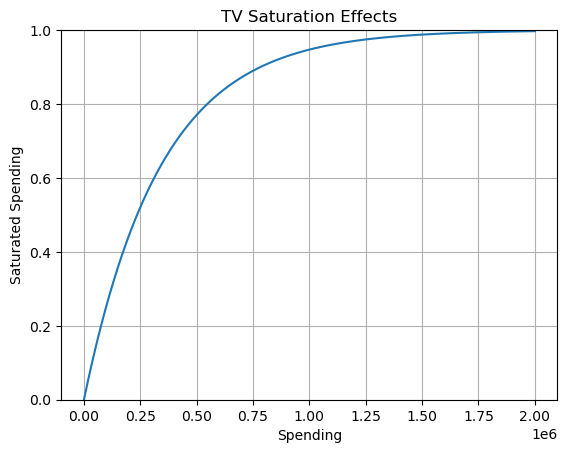

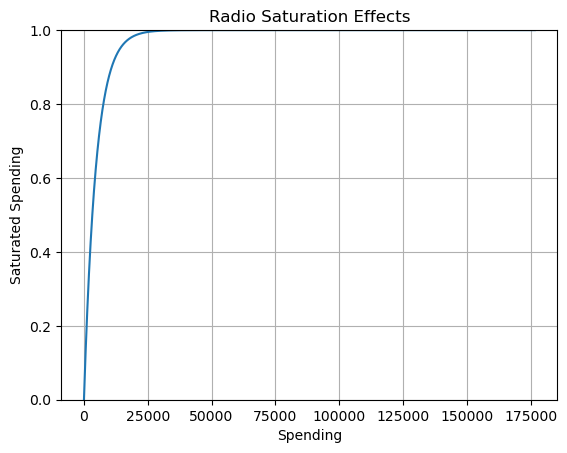

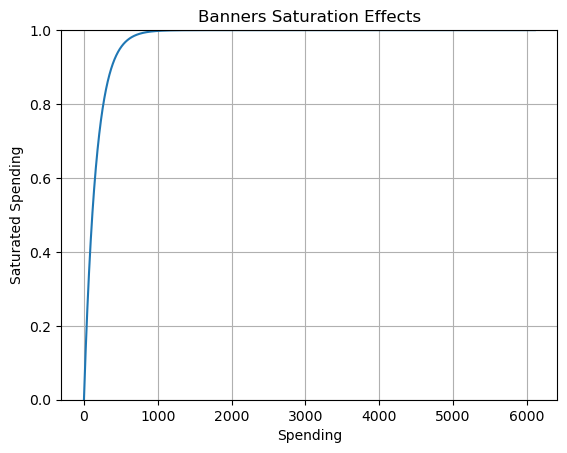

In [47]:
# Interpreting the model
#Saturation effects
sat_dict = {}
for key, val in tuned_model.best_params_.items():
    if ('saturation' in key) and ('tv' in key):
        sat_dict['TV'] = val
    
    if ('saturation' in key) and ('radio' in key):
        sat_dict['Radio'] = val
    
    if ('saturation' in key) and ('banners' in key):
        sat_dict['Banners'] = val
        
for key, val in sat_dict.items():
    x = np.arange(0, 2000000)
    y_p = 1 - np.exp(-val*x)
    y_p = [i for i in y_p if i < 1]
    x = x[:len(y_p)]
    plt.plot(x,y_p)
    plt.xlabel('Spending')
    plt.ylabel('Saturated Spending')
    plt.title(key + ' Saturation Effects')
    plt.ylim(0,1)
    plt.grid()
    plt.show()

Here we can see that we may still be able to get some gain by increasing TV ads budget significantly up to '$1.75M'

for Radio we peak closer to a '$25k'

for Banners anything more than '$1000' does not offer us any addl returns

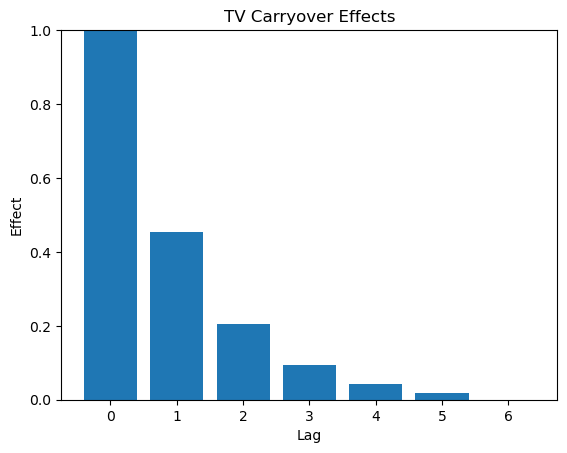

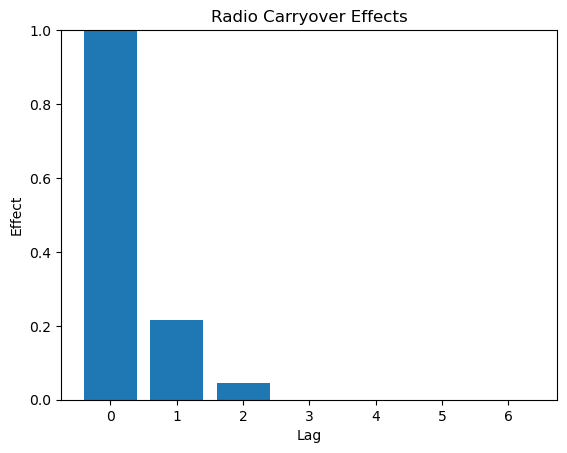

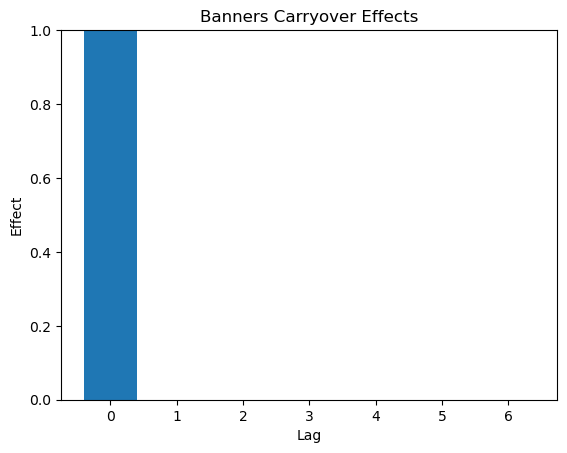

In [46]:
#Interpreting the model
#Carryover Effects
strength_dict = {}
length_dict = {}
for key, val in tuned_model.best_params_.items():
    if ('strength' in key) and ('tv' in key):
        strength_dict['TV'] = val
    
    if ('strength' in key) and ('radio' in key):
        strength_dict['Radio'] = val
    
    if ('strength' in key) and ('banners' in key):
        strength_dict['Banners'] = val
        
    if ('length' in key) and ('tv' in key):
        length_dict['TV'] = val
    
    if ('length' in key) and ('radio' in key):
        length_dict['Radio'] = val
    
    if ('length' in key) and ('banners' in key):
        length_dict['Banners'] = val
        
maxlength = max(length_dict.values()) + 1  
        
for key, val in strength_dict.items():
    x = np.arange(0, maxlength+1)
    y_p = [strength_dict[key]**i for i in range(0,length_dict[key]+1)]
    y_p.extend([0]*(len(x)-len(y_p)))
    plt.bar(x,y_p)
    plt.xlabel('Lag')
    plt.ylabel('Effect')
    plt.title(key + ' Carryover Effects')
    plt.ylim(0,1)
    plt.show()

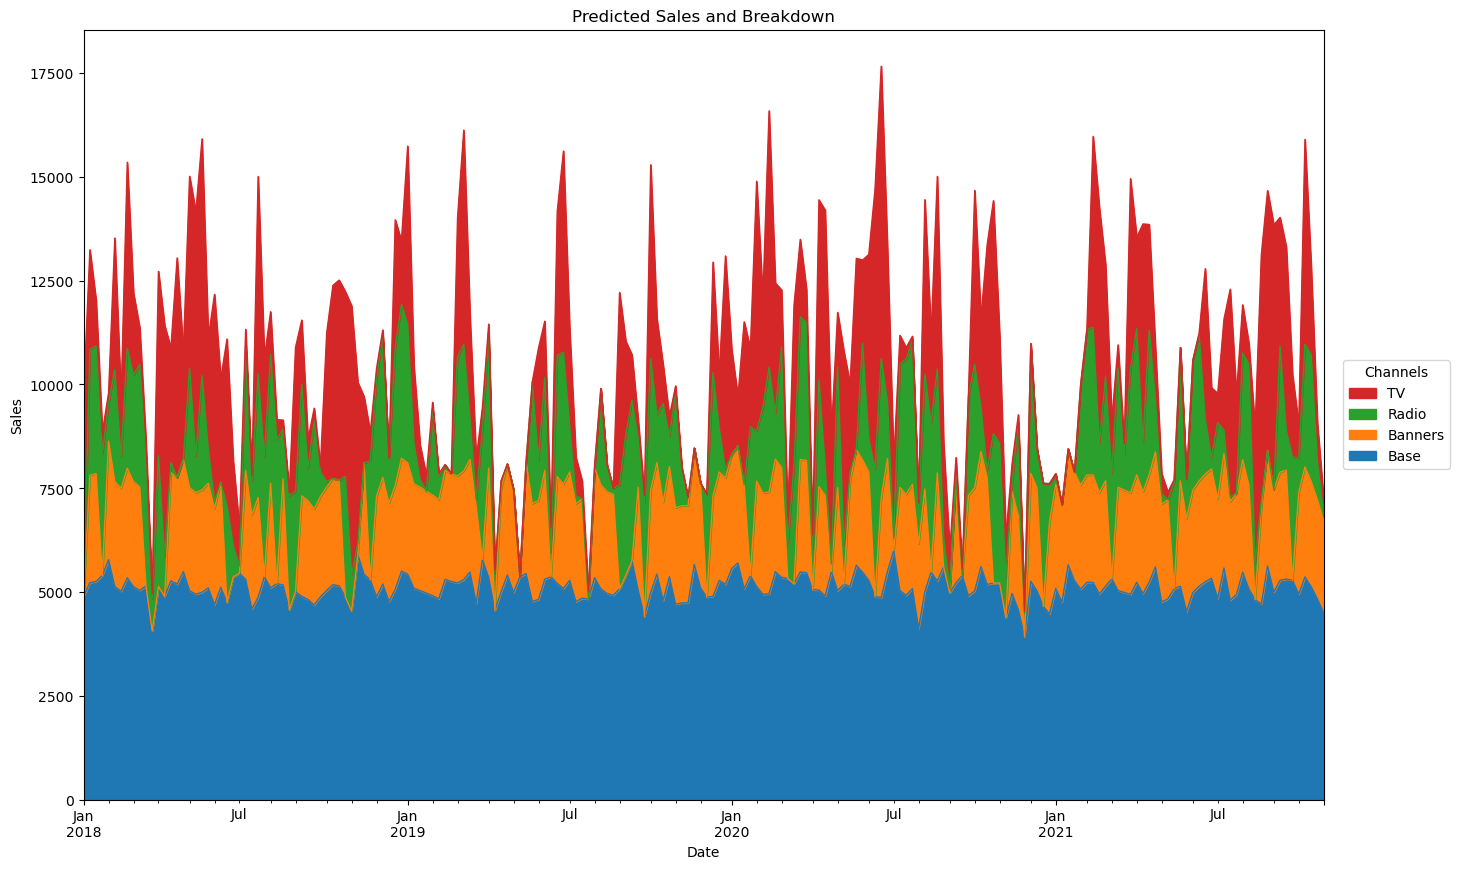

In [49]:
#Channel contribution plot
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [50]:
adstock_data

TV     Radio   Banners
Date                                    
2018-01-07  0.039040  0.000000  0.000000
2018-01-14  0.017921  0.678166  0.999999
2018-01-21  0.008178  0.680556  0.999996
2018-01-28  0.003722  0.632125  0.000000
2018-02-04  0.001692  0.184165  0.999998
...              ...       ...       ...
2021-10-03  0.006372  0.194717  0.999968
2021-10-10  0.036027  0.641065  1.000000
2021-10-17  0.016256  0.691375  0.999992
2021-10-24  0.007415  0.223139  0.999971
2021-10-31  0.003177  0.043562  0.999989

[200 rows x 3 columns]